Data loaded. Shape: (6929, 98)
Removed highly correlated numeric features: ['HE_LDL_drct', 'HE_alt', 'HE_wt', 'HE_BMI']
Selected numeric features after correlation check: ['HE_sbp1', 'HE_dbp1', 'HE_wc', 'HE_glu', 'HE_HbA1c', 'HE_chol', 'HE_HDL_st2', 'HE_crea', 'HE_ast', 'HE_ht', 'age', 'L_OUT_FQ', 'LS_VEG1', 'LS_FRUIT']

=== Iteration 1: Baseline Clustering (Full initial feature set) ===

--- Running Iteration with 23 features ---

--- Preprocessing ---
Numeric columns in current df: ['HE_sbp1', 'HE_dbp1', 'HE_wc', 'HE_glu', 'HE_HbA1c', 'HE_chol', 'HE_HDL_st2', 'HE_crea', 'HE_ast', 'HE_ht', 'age', 'L_OUT_FQ', 'LS_VEG1', 'LS_FRUIT']
Categorical columns in current df: ['BD1_11', 'BP16_1', 'BS3_2', 'BE5_1', 'HE_HP', 'HE_DM_HbA1c', 'sex', 'BS1_1', 'BP5']
Shape after preprocessing (scaled and OHE): (6929, 86)
PCA reduced dimensions to: 32
Explained variance ratio: 0.9541

--- Running Agglomerative (k=5) ---
Agglomerative (k=5): Silhouette Score = 0.1075

Feature Importance (Random Forest) f

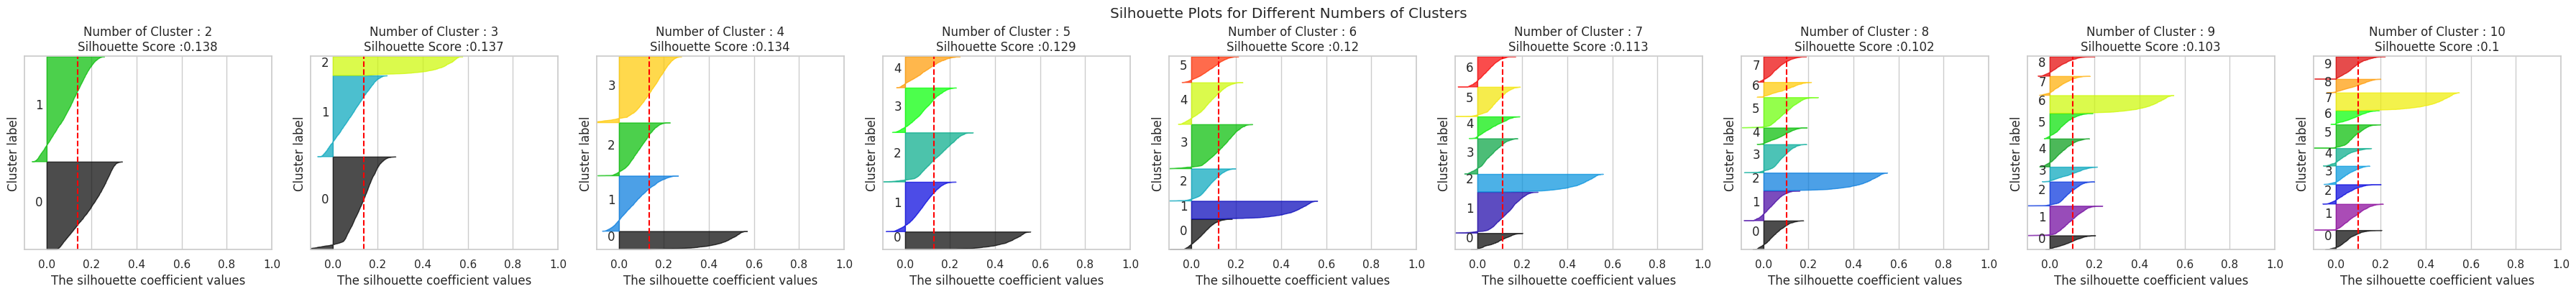


--- Analyzing Feature Importance for Selection ---
Feature importance threshold for removal (median): 0.033359

Identified 11 low importance features to potentially remove.
Remaining features for Iteration 2: 12

=== Iteration 2: Clustering with Selected Features ===

--- Running Iteration with 12 features ---

--- Preprocessing ---
Numeric columns in current df: ['HE_sbp1', 'HE_glu', 'HE_HbA1c', 'HE_crea', 'HE_ht', 'age']
Categorical columns in current df: ['BP16_1', 'HE_HP', 'HE_DM_HbA1c', 'sex', 'BS1_1', 'BP5']
Shape after preprocessing (scaled and OHE): (6929, 38)
PCA reduced dimensions to: 16
Explained variance ratio: 0.9517

--- Running Agglomerative (k=5) ---
Agglomerative (k=5): Silhouette Score = 0.1816

Feature Importance (Random Forest) for non-noise clusters:
sex            0.212540
HE_DM_HbA1c    0.132492
HE_HP          0.095736
age            0.095599
HE_HbA1c       0.091866
HE_ht          0.082968
HE_glu         0.078650
HE_crea        0.049425
BP5            0.043500
B

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.ensemble import RandomForestClassifier

# ÌÜµÍ≥Ñ Î∂ÑÏÑùÏùÑ ÏúÑÌïú ÎùºÏù¥Î∏åÎü¨Î¶¨ ÏûÑÌè¨Ìä∏
from scipy import stats
import statsmodels.api as sm # Ïπ¥Ïù¥Ï†úÍ≥± Í≤ÄÏ†ï Í≤∞Í≥ºÎ•º Ï¢Ä Îçî ÏÉÅÏÑ∏Ìûà Î≥¥Ïó¨Ï£ºÍ∏∞ ÏúÑÌï¥ Ï∂îÍ∞Ä (Optional)
from statsmodels.stats.contingency_tables import Table # Ïπ¥Ïù¥Ï†úÍ≥± Í≤ÄÏ†ïÏùÑ ÏúÑÌïú ÌÅ¥ÎûòÏä§

# ÏãúÍ∞ÅÌôî ÏÑ§Ï†ï
sns.set(style="whitegrid")

# Ï†ÑÏ≤òÎ¶¨ Ìï®Ïàò ÏàòÏ†ï (Ïù¥Ï†Ñ ÏΩîÎìúÏôÄ ÎèôÏùº)
def preprocess_data(df, original_numeric_cols, original_categorical_cols):
    """
    Preprocess data: impute missing values, handle outliers, encode categorical features.
    Processes only the columns present in the input df, based on original_numeric_cols and original_categorical_cols.
    """
    df_processed = df.copy()

    current_numeric_cols = [col for col in original_numeric_cols if col in df_processed.columns]
    current_categorical_cols = [col for col in original_categorical_cols if col in df_processed.columns]

    print(f"\n--- Preprocessing ---")
    print(f"Numeric columns in current df: {current_numeric_cols}")
    print(f"Categorical columns in current df: {current_categorical_cols}")

    df_processed = df_processed.replace([888, 999], np.nan)

    if current_numeric_cols:
        numeric_data_for_impute = df_processed[current_numeric_cols].values
        imputer = KNNImputer(n_neighbors=5)
        numeric_data_imputed = imputer.fit_transform(numeric_data_for_impute)
        df_processed[current_numeric_cols] = numeric_data_imputed

    if current_categorical_cols:
        for col in current_categorical_cols:
             if df_processed[col].isnull().any():
                 try:
                     mode_val = df_processed[col].mode()[0]
                     df_processed[col] = df_processed[col].fillna(mode_val)
                 except IndexError:
                     print(f"Warning: Could not compute mode for {col} or all values are NaN.")
                     pass

    if current_numeric_cols:
        for col in current_numeric_cols:
            Q1 = df_processed[col].quantile(0.25)
            Q3 = df_processed[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df_processed[col] = df_processed[col].clip(lower_bound, upper_bound)

    transformers = []
    if current_numeric_cols:
        transformers.append(('num', RobustScaler(), current_numeric_cols))
    if current_categorical_cols:
         transformers.append(('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), current_categorical_cols))

    if not transformers:
        print("No numeric or categorical columns remaining after filtering.")
        return pd.DataFrame(), [], None, df_processed

    preprocessor = ColumnTransformer(
        transformers=transformers,
        remainder='passthrough'
    )

    try:
        scaled_data = preprocessor.fit_transform(df_processed)
        all_transformed_features = preprocessor.get_feature_names_out()
        scaled_df = pd.DataFrame(scaled_data, columns=all_transformed_features)
        print(f"Shape after preprocessing (scaled and OHE): {scaled_df.shape}")
    except Exception as e:
        print(f"Error during preprocessing transformation: {e}")
        return pd.DataFrame(), [], None, df_processed

    return scaled_df, all_transformed_features, preprocessor, df_processed

# select_features Ìï®Ïàò (Ïù¥Ï†Ñ ÏΩîÎìúÏôÄ ÎèôÏùº)
def select_features(df, columns, corr_threshold=0.8):
    """Remove highly correlated numeric features."""
    numeric_df = df[columns].select_dtypes(include=[np.number])
    if numeric_df.empty:
        print("No numeric columns provided for correlation check.")
        return []

    corr_matrix = numeric_df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > corr_threshold)]
    selected_numeric_cols = [col for col in columns if col not in to_drop]
    print(f"Removed highly correlated numeric features: {to_drop}")
    print(f"Selected numeric features after correlation check: {selected_numeric_cols}")
    return selected_numeric_cols

# compute_feature_importance Ìï®Ïàò (Ïù¥Ï†Ñ ÏΩîÎìúÏôÄ ÎèôÏùº)
def compute_feature_importance(df_processed, selected_cols, cluster_labels):
    """Compute feature importance using Random Forest."""
    if len(np.unique(cluster_labels[cluster_labels != -1])) < 2:
         print("\nFeature Importance: Not enough non-noise clusters (>= 2 required).")
         return pd.Series([], dtype=float)

    non_noise_indices = cluster_labels != -1
    df_filtered = df_processed.loc[non_noise_indices].copy()
    labels_filtered = cluster_labels[non_noise_indices]

    if df_filtered.empty:
         print("\nFeature Importance: No non-noise data points found.")
         return pd.Series([], dtype=float)

    try:
        rf = RandomForestClassifier(random_state=42)
        rf.fit(df_filtered[selected_cols], labels_filtered)
        importance = pd.Series(rf.feature_importances_, index=selected_cols).sort_values(ascending=False)
        print("\nFeature Importance (Random Forest) for non-noise clusters:")
        print(importance)
        return importance
    except Exception as e:
        print(f"\nError computing Feature Importance: {e}")
        return pd.Series([], dtype=float)

# visualize_silhouette Ìï®Ïàò (Ïù¥Ï†Ñ ÏΩîÎìúÏôÄ ÎèôÏùº)
def visualize_silhouette(cluster_lists, X_features):
    """
    Ï£ºÏñ¥ÏßÑ ÌÅ¥Îü¨Ïä§ÌÑ∞ Í∞úÏàò Î¶¨Ïä§Ìä∏Ïóê ÎåÄÌï¥ K-MeansÎ•º Ï†ÅÏö©ÌïòÍ≥† Ïã§Î£®Ïó£ Í≥ÑÏàòÎ•º ÏãúÍ∞ÅÌôîÌï©ÎãàÎã§.

    Args:
        cluster_lists (list): ÌÖåÏä§Ìä∏Ìï† ÌÅ¥Îü¨Ïä§ÌÑ∞ Í∞úÏàò(k)Ïùò Î¶¨Ïä§Ìä∏.
        X_features (numpy.ndarray or pandas.DataFrame): ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅ ÎåÄÏÉÅ Îç∞Ïù¥ÌÑ∞ (PCA Í≤∞Í≥º Îì±).
    """
    print(f"\n--- Visualizing Silhouette Scores for k in {cluster_lists} ---")

    n_cols = len(cluster_lists)

    fig, axs = plt.subplots(figsize=(4 * n_cols, 4), nrows=1, ncols=n_cols)
    if n_cols == 1: # axsÍ∞Ä Î∞∞Ïó¥Ïù¥ ÏïÑÎãê Í≤ΩÏö∞ Ï≤òÎ¶¨
        axs = [axs]

    for ind, n_cluster in enumerate(cluster_lists):
        ax = axs[ind] # Í∞Å ÏÑúÎ∏åÌîåÎ°Ø ÏÑ†ÌÉù

        try:
            if n_cluster < 2:
                 print(f"Skipping silhouette visualization for k={n_cluster} (< 2).")
                 ax.set_title(f'k={n_cluster} (Skipped)')
                 ax.text(0.5, 0.5, 'k < 2', horizontalalignment='center', verticalalignment='center')
                 ax.set_xticks([])
                 ax.set_yticks([])
                 continue # Îã§Ïùå kÎ°ú ÎÑòÏñ¥Í∞ê

            clusterer = KMeans(n_clusters=n_cluster, max_iter=500, random_state=0, n_init=10)
            cluster_labels = clusterer.fit_predict(X_features)

            sil_avg = silhouette_score(X_features, cluster_labels)
            sil_values = silhouette_samples(X_features, cluster_labels)

            y_lower = 10

            ax.set_title('Number of Cluster : ' + str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
            ax.set_xlabel("The silhouette coefficient values")
            ax.set_ylabel("Cluster label")
            ax.set_xlim([-0.1, 1])
            ax.set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
            ax.set_yticks([])
            ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

            for i in range(n_cluster):
                ith_cluster_sil_values = sil_values[cluster_labels == i]
                ith_cluster_sil_values.sort()
                size_cluster_i = ith_cluster_sil_values.shape[0]
                y_upper = y_lower + size_cluster_i
                color = cm.nipy_spectral(float(i) / n_cluster)
                ax.fill_betweenx(np.arange(y_lower, y_upper),
                                 0, ith_cluster_sil_values,
                                 facecolor=color, edgecolor=color, alpha=0.7)
                ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
                y_lower = y_upper + 10

            ax.axvline(x=sil_avg, color="red", linestyle="--")

        except Exception as e:
            print(f"Error visualizing silhouette for k={n_cluster}: {e}")
            ax.set_title(f'k={n_cluster} (Error)')
            ax.text(0.5, 0.5, 'Error', horizontalalignment='center', verticalalignment='center')
            ax.set_xticks([])
            ax.set_yticks([])

    plt.tight_layout()
    plt.suptitle('Silhouette Plots for Different Numbers of Clusters', y=1.02)
    plt.show()


# Îã®Ïùº ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅ Ïù¥ÌÑ∞Î†àÏù¥ÏÖòÏùÑ Ïã§ÌñâÌïòÎäî Ìï®Ïàò (Ïù¥Ï†Ñ ÏΩîÎìúÏôÄ ÎèôÏùº)
def run_clustering_iteration(df_original, features_to_use, original_numeric_cols, original_categorical_cols, n_clusters, algorithm):
    """
    Runs one iteration of preprocessing, PCA, clustering, scoring, and importance calculation
    using a specified subset of features.
    Returns scaled_df_pca instead of scaled_df for direct use in analysis functions.
    """
    print(f"\n--- Running Iteration with {len(features_to_use)} features ---")

    if not features_to_use:
        print("No features selected for this iteration. Skipping.")
        return None, None, None, None, None, None, None # scaled_df_pca Ï∂îÍ∞Ä Î∞òÌôòÍ∞í

    df_subset = df_original[features_to_use]

    try:
        scaled_df, all_transformed_features, preprocessor, df_processed_subset = preprocess_data(
            df_subset,
            original_numeric_cols,
            original_categorical_cols
        )
        if scaled_df.empty:
             print("Preprocessing returned empty data. Skipping iteration.")
             return features_to_use, None, None, None, df_processed_subset, None, None

    except Exception as e:
         print(f"An error occurred during preprocessing: {e}. Skipping iteration.")
         return features_to_use, None, None, None, None, None, None

    pca = PCA(n_components=0.95, random_state=42)
    scaled_df_pca = None
    try:
        scaled_df_pca = pca.fit_transform(scaled_df)
        print(f"PCA reduced dimensions to: {scaled_df_pca.shape[1]}")
        print(f"Explained variance ratio: {sum(pca.explained_variance_ratio_):.4f}")
    except Exception as e:
         print(f"PCA failed: {e}. Skipping clustering and importance.")
         return features_to_use, None, None, None, df_processed_subset, scaled_df, None # scaled_df_pca None

    if scaled_df_pca is None or scaled_df_pca.shape[0] == 0:
        print("PCA returned no data. Skipping clustering and importance.")
        return features_to_use, None, None, None, df_processed_subset, scaled_df, None # scaled_df_pca None


    clusters = None
    score = None
    algorithm_used = None

    try:
        if algorithm == 'Agglomerative':
            algorithm_used = f'Agglomerative (k={n_clusters})'
            print(f"\n--- Running {algorithm_used} ---")
            model = AgglomerativeClustering(n_clusters=n_clusters)
            clusters = model.fit_predict(scaled_df_pca)

        elif algorithm == 'KMeans':
             algorithm_used = f'KMeans (k={n_clusters})'
             print(f"\n--- Running {algorithm_used} ---")
             model = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
             clusters = model.fit_predict(scaled_df_pca)

        # Ïã§Î£®Ïó£ Ïä§ÏΩîÏñ¥ Í≥ÑÏÇ∞
        if len(np.unique(clusters)) > 1 and not (len(np.unique(clusters)) == 2 and -1 in np.unique(clusters)):
             # DBSCANÏùò Í≤ΩÏö∞ ÎÖ∏Ïù¥Ï¶à(-1) Ï†úÏô∏ ÌïÑÏöî. ÌòÑÏû¨ Agglomerative/KMeans ÏÇ¨Ïö©ÌïòÎØÄÎ°ú Î™®Îì† ÌÅ¥Îü¨Ïä§ÌÑ∞ Ìè¨Ìï®
             score = silhouette_score(scaled_df_pca, clusters)
             print(f"{algorithm_used}: Silhouette Score = {score:.4f}")
        else:
             print(f"{algorithm_used}: Silhouette Score not computable (less than 2 non-noise clusters).")
             score = None

    except Exception as e:
        print(f"{algorithm_used} failed: {e}")
        clusters = None
        score = None


    if clusters is None or score is None:
        print("Clustering failed or score could not be computed. Skipping importance calculation.")
        return features_to_use, clusters, score, None, df_processed_subset, scaled_df, scaled_df_pca # importance None

    importance = compute_feature_importance(df_processed_subset, features_to_use, clusters)

    # scaled_df_pcaÎèÑ Ìï®Íªò Î∞òÌôòÌïòÏó¨ Î∂ÑÏÑù Î∞è ÏãúÍ∞ÅÌôîÏóê ÏÇ¨Ïö©
    return features_to_use, clusters, score, importance, df_processed_subset, scaled_df, scaled_df_pca


# --- Íµ∞ÏßëÎ≥Ñ ÌîºÏ≤ò Ï∞®Ïù¥ ÌÜµÍ≥Ñ Î∂ÑÏÑù Ìï®Ïàò Ï∂îÍ∞Ä ---
def analyze_cluster_differences(df_processed, clusters, features_used, original_numeric_cols, original_categorical_cols, alpha=0.05):
    """
    Performs statistical tests to check for significant differences in features across clusters.
    ANOVA for numeric features, Chi-squared for categorical features.
    """
    print(f"\n=== Analyzing Statistical Differences Across Clusters (alpha={alpha}) ===")

    if df_processed is None or clusters is None:
        print("Analysis skipped: Processed data or cluster labels are missing.")
        return

    # ÎÖ∏Ïù¥Ï¶à(-1) ÌÅ¥Îü¨Ïä§ÌÑ∞Îäî Î∂ÑÏÑùÏóêÏÑú Ï†úÏô∏
    non_noise_indices = clusters != -1
    df_filtered = df_processed.loc[non_noise_indices].copy()
    clusters_filtered = clusters[non_noise_indices]

    if len(np.unique(clusters_filtered)) < 2:
        print("Analysis skipped: Less than 2 non-noise clusters found.")
        return

    df_filtered['Cluster'] = clusters_filtered

    # ÏÇ¨Ïö©Îêú ÌîºÏ≤òÎì§ÏùÑ Ïà´ÏûêÌòïÍ≥º Î≤îÏ£ºÌòïÏúºÎ°ú Î∂ÑÎ¶¨
    numeric_features_used = [col for col in features_used if col in original_numeric_cols]
    categorical_features_used = [col for col in features_used if col in original_categorical_cols]

    print("\n--- ANOVA Test for Numeric Features ---")
    if not numeric_features_used:
        print("No numeric features to test.")
    else:
        for col in numeric_features_used:
            # Í∞Å Íµ∞ÏßëÎ≥Ñ Îç∞Ïù¥ÌÑ∞ Í∑∏Î£π Ï∂îÏ∂ú
            # ÌÅ¥Îü¨Ïä§ÌÑ∞ Ïù∏Îç±Ïä§Í∞Ä Ïà´ÏûêÎ°ú ÏûêÎèô Î≥ÄÌôòÎêòÎØÄÎ°ú astype(int) ÌïÑÏöî ÏóÜÏùå
            groups = [df_filtered[col][df_filtered['Cluster'] == i].dropna() for i in np.unique(clusters_filtered)]

            # ÏÉòÌîå ÏàòÍ∞Ä 1Í∞ú Ïù¥ÌïòÏù∏ Í∑∏Î£πÏùÄ ANOVAÏóêÏÑú Ï†úÏô∏Ìï¥Ïïº Ìï®
            valid_groups = [group for group in groups if len(group) > 1]

            if len(valid_groups) < 2:
                print(f"  '{col}': ANOVA skipped (less than 2 groups with >1 sample).")
                continue

            # Î™®Îì† Í∑∏Î£πÏóêÏÑú Ìï¥Îãπ ÌîºÏ≤òÏùò Í∞íÏù¥ ÎèôÏùºÌïúÏßÄ ÌôïÏù∏ (ANOVA Ïò§Î•ò Î∞©ÏßÄ)
            all_values = np.concatenate(valid_groups)
            if np.all(all_values == all_values[0]):
                 print(f"  '{col}': ANOVA skipped (feature has constant value across groups).")
                 continue


            # ANOVA Í≤ÄÏ†ï Ïã§Ìñâ
            try:
                fvalue, pvalue = stats.f_oneway(*valid_groups)
                print(f"  '{col}': F-statistic={fvalue:.4f}, p-value={pvalue:.4f} {'*' if pvalue < alpha else ''}")
            except Exception as e:
                print(f"  '{col}': ANOVA failed ({e}).")


    print("\n--- Chi-squared Test for Categorical Features ---")
    if not categorical_features_used:
        print("No categorical features to test.")
    else:
        for col in categorical_features_used:
            # ÍµêÏ∞®Ìëú ÏÉùÏÑ±
            contingency_table = pd.crosstab(df_filtered['Cluster'], df_filtered[col])

            # Ïπ¥Ïù¥Ï†úÍ≥± Í≤ÄÏ†ïÏùÑ ÏúÑÌïú ÏµúÏÜå ÏöîÍµ¨ÏÇ¨Ìï≠ Ï∂©Ï°± ÌôïÏù∏
            # Î≥¥ÌÜµ expected frequencyÍ∞Ä 5 ÎØ∏ÎßåÏù∏ ÏÖÄÏù¥ Ï†ÑÏ≤¥ ÏÖÄÏùò 20%Î•º ÎÑòÏßÄ ÏïäÏïÑÏïº Ìï®
            # stats.chi2_contingencyÎäî ÏûëÏùÄ ÏÉòÌîå ÌÅ¨Í∏∞Ïóê ÎåÄÌï¥ Í≤ΩÍ≥†Î•º ÎùÑÏö∞Í±∞ÎÇò Yates Î≥¥Ï†ïÏùÑ Ï†ÅÏö©Ìï† Ïàò ÏûàÏùå
            # Ïó¨Í∏∞ÏÑúÎäî ÏùºÎã® Î∞îÎ°ú Ïã§Ìñâ
            if contingency_table.shape[0] < 2 or contingency_table.shape[1] < 2:
                 print(f"  '{col}': Chi-squared skipped (table size < 2x2).")
                 continue

            # Î™®Îì† Ìñâ ÎòêÎäî Ïó¥Ïùò Ìï©Ïù¥ 0Ïù∏ÏßÄ ÌôïÏù∏ (Ïπ¥Ïù¥Ï†úÍ≥± Ïò§Î•ò Î∞©ÏßÄ)
            if np.any(contingency_table.sum(axis=0) == 0) or np.any(contingency_table.sum(axis=1) == 0):
                 print(f"  '{col}': Chi-squared skipped (zero row/column sum).")
                 continue

            try:
                chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
                print(f"  '{col}': Chi2-statistic={chi2:.4f}, p-value={p:.4f}, df={dof} {'*' if p < alpha else ''}")

                # statsmodelsÎ•º ÏÇ¨Ïö©ÌïòÎ©¥ Îçî ÏÉÅÏÑ∏Ìïú Í≤∞Í≥º ÌôïÏù∏ Í∞ÄÎä• (Optional)
                # table = Table(contingency_table)
                # rslt = table.test_nominal_association()
                # print(rslt.pvalue)

            except ValueError as ve:
                 print(f"  '{col}': Chi-squared failed ({ve}). Check for zero counts or other table issues.")
            except Exception as e:
                print(f"  '{col}': Chi-squared failed ({e}).")

    print("\n(*) indicates statistically significant difference (p < alpha)")


# run_clustering_iteration Ìï®Ïàò Î∞òÌôòÍ∞í ÏàòÏ†ï (scaled_df_pca Ï∂îÍ∞Ä)
# run_clustering_iteration Ìï®Ïàò (Ïù¥Ï†Ñ ÏΩîÎìúÏôÄ ÎèôÏùº)
def run_clustering_iteration(df_original, features_to_use, original_numeric_cols, original_categorical_cols, n_clusters, algorithm):
    """
    Runs one iteration of preprocessing, PCA, clustering, scoring, and importance calculation
    using a specified subset of features.
    Returns scaled_df_pca for direct use in analysis functions.
    """
    print(f"\n--- Running Iteration with {len(features_to_use)} features ---")

    if not features_to_use:
        print("No features selected for this iteration. Skipping.")
        # scaled_df_pca Ï∂îÍ∞Ä Î∞òÌôòÍ∞í None
        return None, None, None, None, None, None, None

    df_subset = df_original[features_to_use].copy() # Î≥µÏÇ¨Î≥∏ ÏÇ¨Ïö©

    try:
        scaled_df, all_transformed_features, preprocessor, df_processed_subset = preprocess_data(
            df_subset,
            original_numeric_cols,
            original_categorical_cols
        )
        if scaled_df.empty:
             print("Preprocessing returned empty data. Skipping iteration.")
             return features_to_use, None, None, None, df_processed_subset, None, None

    except Exception as e:
         print(f"An error occurred during preprocessing: {e}. Skipping iteration.")
         return features_to_use, None, None, None, None, None, None

    pca = PCA(n_components=0.95, random_state=42)
    scaled_df_pca = None
    try:
        scaled_df_pca = pca.fit_transform(scaled_df)
        print(f"PCA reduced dimensions to: {scaled_df_pca.shape[1]}")
        print(f"Explained variance ratio: {sum(pca.explained_variance_ratio_):.4f}")
    except Exception as e:
         print(f"PCA failed: {e}. Skipping clustering and importance.")
         return features_to_use, None, None, None, df_processed_subset, scaled_df, None

    if scaled_df_pca is None or scaled_df_pca.shape[0] == 0:
        print("PCA returned no data. Skipping clustering and importance.")
        return features_to_use, None, None, None, df_processed_subset, scaled_df, None


    clusters = None
    score = None
    algorithm_used = None

    try:
        if algorithm == 'Agglomerative':
            algorithm_used = f'Agglomerative (k={n_clusters})'
            print(f"\n--- Running {algorithm_used} ---")
            model = AgglomerativeClustering(n_clusters=n_clusters)
            clusters = model.fit_predict(scaled_df_pca)

        elif algorithm == 'KMeans':
             algorithm_used = f'KMeans (k={n_clusters})'
             print(f"\n--- Running {algorithm_used} ---")
             model = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
             clusters = model.fit_predict(scaled_df_pca)

        else:
            raise ValueError(f"Unsupported algorithm: {algorithm}")

        if len(np.unique(clusters)) > 1 and not (len(np.unique(clusters)) == 2 and -1 in np.unique(clusters)):
             # DBSCANÏùò Í≤ΩÏö∞ ÎÖ∏Ïù¥Ï¶à(-1) Ï†úÏô∏ ÌïÑÏöî. ÌòÑÏû¨ Agglomerative/KMeans ÏÇ¨Ïö©ÌïòÎØÄÎ°ú Î™®Îì† ÌÅ¥Îü¨Ïä§ÌÑ∞ Ìè¨Ìï®
             score = silhouette_score(scaled_df_pca, clusters)
             print(f"{algorithm_used}: Silhouette Score = {score:.4f}")
        else:
             print(f"{algorithm_used}: Silhouette Score not computable (less than 2 non-noise clusters).")
             score = None

    except Exception as e:
        print(f"{algorithm_used} failed: {e}")
        clusters = None
        score = None


    if clusters is None or score is None:
        print("Clustering failed or score could not be computed. Skipping importance calculation.")
        return features_to_use, clusters, score, None, df_processed_subset, scaled_df, scaled_df_pca # importance None

    importance = compute_feature_importance(df_processed_subset, features_to_use, clusters)

    # scaled_df_pcaÎèÑ Ìï®Íªò Î∞òÌôòÌïòÏó¨ Î∂ÑÏÑùÏóê ÏÇ¨Ïö©
    return features_to_use, clusters, score, importance, df_processed_subset, scaled_df, scaled_df_pca


def main():
    """Iterative feature selection for clustering and statistical analysis."""
    # Îç∞Ïù¥ÌÑ∞ Î°úÎìú
    df_original = pd.read_csv("/content/ÏÑ†ÌÉùÏª¨Îüº_Í±¥Í∞ïÎç∞Ïù¥ÌÑ∞.csv")
    print(f"Data loaded. Shape: {df_original.shape}")

    # ÏõêÎ≥∏ Ï†ÑÏ≤¥ ÌîºÏ≤ò Ï†ïÏùò
    knn_columns = [
        'HE_sbp1', 'HE_dbp1', 'HE_wc', 'HE_glu', 'HE_HbA1c',
        'HE_chol', 'HE_HDL_st2', 'HE_LDL_drct', 'HE_crea',
        'HE_ast', 'HE_alt', 'HE_wt', 'HE_ht', 'HE_BMI'
    ]
    additional_numeric = ['age', 'L_OUT_FQ', 'LS_VEG1', 'LS_FRUIT']
    additional_categorical = ['HE_HP', 'HE_DM_HbA1c', 'sex', 'BS1_1', 'BP5']
    original_categorical = ["BD1_11", "BP16_1", "BS3_2", "BE5_1"]

    all_possible_numeric_cols = knn_columns + additional_numeric
    all_possible_categorical_cols = original_categorical + additional_categorical

    # Ï¥àÍ∏∞ Ïà´ÏûêÌòï ÌîºÏ≤ò ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ Í∏∞Î∞ò ÌïÑÌÑ∞ÎßÅ (ÌõÑÎ≥¥Íµ∞ Ï∂ïÏÜå)
    selected_numeric_after_corr = select_features(df_original.copy(), all_possible_numeric_cols, corr_threshold=0.8)
    current_features_for_selection = selected_numeric_after_corr + all_possible_categorical_cols

    if not current_features_for_selection:
         print("No features remaining after initial correlation check. Exiting.")
         return

    # ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅ Îß§Í∞úÎ≥ÄÏàò ÏÑ§Ï†ï
    n_clusters_to_use = 5 # <-- Íµ∞Ïßë Í∞úÏàòÎ•º 5Í∞úÎ°ú Í≥†Ï†ï!
    clustering_algorithm = 'Agglomerative' # ÏÇ¨Ïö©Ìï† ÏïåÍ≥†Î¶¨Ï¶ò ÏÑ†ÌÉù ('Agglomerative' ÎòêÎäî 'KMeans')


    # --- Iteration 1: Baseline Clustering with initial feature set ---
    print("\n=== Iteration 1: Baseline Clustering (Full initial feature set) ===")
    # run_clustering_iteration Ìï®ÏàòÎäî Ïù¥Ï†ú scaled_df_pcaÎèÑ Î∞òÌôò
    features_iter1, clusters_iter1, score_iter1, importance_iter1, df_processed_iter1, scaled_df_iter1, scaled_df_pca_iter1 = run_clustering_iteration(
        df_original,
        current_features_for_selection,
        all_possible_numeric_cols,
        all_possible_categorical_cols,
        n_clusters=n_clusters_to_use,
        algorithm=clustering_algorithm
    )

    print(f"\nIteration 1 Silhouette Score ({clustering_algorithm}, k={n_clusters_to_use}): {score_iter1 if score_iter1 is not None else 'N/A':.4f}")

    # --- Silhouette Plot Visualization for Different k (using Iteration 1 PCA data) ---
    # Ïù¥ ÏãúÍ∞ÅÌôîÎäî k=5Î°ú Í≥†Ï†ïÎêú Î∂ÑÏÑùÍ≥ºÎäî Î≥ÑÍ∞úÎ°ú, Îã§ÏñëÌïú kÎ•º ÌÉêÏÉâÌïòÎ©∞ ÏãúÍ∞ÅÏ†ÅÏúºÎ°ú Ï¢ãÏùÄ kÎ•º Ï∞æÎäîÎç∞ ÎèÑÏõÄÏùÑ Ï§çÎãàÎã§.
    # Îî∞ÎùºÏÑú n_clusters_to_useÏôÄ Í¥ÄÍ≥ÑÏóÜÏù¥ k_range_for_vizÎ•º ÏÇ¨Ïö©Ìï©ÎãàÎã§.
    # ÏãúÍ∞ÅÌôîÎäî Iteration 1Ïùò scaled_df Îç∞Ïù¥ÌÑ∞Î•º ÏÇ¨Ïö©Ìï©ÎãàÎã§.
    if scaled_df_iter1 is not None and not scaled_df_iter1.empty:
        pca_for_viz = PCA(n_components=0.95, random_state=42)
        try:
            scaled_df_pca_for_viz = pca_for_viz.fit_transform(scaled_df_iter1)
            k_range_for_viz = range(2, 11) # ÏãúÍ∞ÅÌôîÎ•º ÏúÑÌïú k Î≤îÏúÑ
            visualize_silhouette(list(k_range_for_viz), scaled_df_pca_for_viz)
        except Exception as e:
            print(f"Error during PCA or visualization for silhouette plot: {e}")
    else:
         print("\nSkipping silhouette visualization due to empty or None scaled_df from Iteration 1.")


    # Ïù¥ÌõÑ ÌîºÏ≤ò ÏÑ†ÌÉù Î∞è Iteration 2 ÏßÑÌñâ Î°úÏßÅÏùÄ Í∑∏ÎåÄÎ°ú Ïú†ÏßÄ
    # best Í≤∞Í≥ºÎäî Iteration 1 ÎòêÎäî 2 Ï§ë Îçî ÎÇòÏùÄ Ïã§Î£®Ïó£ Ï†êÏàòÎ•º Í∏∞Ï§ÄÏúºÎ°ú ÏÑ†ÌÉùÎê©ÎãàÎã§.

    best_features = features_iter1
    best_clusters = clusters_iter1
    best_score = score_iter1
    best_df_processed = df_processed_iter1
    best_scaled_df = scaled_df_iter1
    best_scaled_df_pca = scaled_df_pca_iter1 # PCA Í≤∞Í≥ºÎèÑ Ï†ÄÏû•
    selected_iteration = 1 # Í∏∞Î≥∏Í∞í

    # ÌîºÏ≤ò Ï§ëÏöîÎèÑ Í∏∞Î∞ò Ïù¥ÌÑ∞Î†àÏù¥ÏÖòÏùÑ ÏßÑÌñâÌï†ÏßÄ Ïó¨Î∂Ä ÌôïÏù∏
    if importance_iter1 is not None and not importance_iter1.empty and score_iter1 is not None:
         # Iteration 1 Í≤∞Í≥ºÍ∞Ä Ïú†Ìö®Ìï† Í≤ΩÏö∞ÏóêÎßå Iteration 2 ÏßÑÌñâ
        # --- Feature Selection Based on Importance from Iteration 1 ---
        print("\n--- Analyzing Feature Importance for Selection ---")
        importance_threshold = importance_iter1.median()
        print(f"Feature importance threshold for removal (median): {importance_threshold:.6f}")

        low_importance_features = importance_iter1[importance_iter1 < importance_threshold].index.tolist()
        features_for_iteration_2 = [f for f in current_features_for_selection if f not in low_importance_features]

        print(f"\nIdentified {len(low_importance_features)} low importance features to potentially remove.")
        print(f"Remaining features for Iteration 2: {len(features_for_iteration_2)}")

        min_features = 5
        if len(features_for_iteration_2) < min_features:
            print(f"\nWarning: Number of features dropped too low. Keeping minimum {min_features} features.")
            features_for_iteration_2 = importance_iter1.nlargest(min_features).index.tolist()
            print(f"Features kept (top {min_features}): {features_for_iteration_2}")

        if not features_for_iteration_2 or len(features_for_iteration_2) < 2: # ÏµúÏÜå 2Í∞ú ÌîºÏ≤ò ÌïÑÏöî
             print(f"\nNot enough features remaining ({len(features_for_iteration_2)}) for Iteration 2. Skipping.")
        else:
            # --- Iteration 2: Clustering with Selected Features ---
            print("\n=== Iteration 2: Clustering with Selected Features ===")
            features_iter2, clusters_iter2, score_iter2, importance_iter2, df_processed_iter2, scaled_df_iter2, scaled_df_pca_iter2 = run_clustering_iteration(
                df_original,
                features_for_iteration_2,
                all_possible_numeric_cols,
                all_possible_categorical_cols,
                n_clusters=n_clusters_to_use,
                algorithm=clustering_algorithm
            )

            print(f"\nIteration 2 Silhouette Score ({clustering_algorithm}, k={n_clusters_to_use}): {score_iter2 if score_iter2 is not None else 'N/A':.4f}")

            # --- Compare Results and Select Best ---
            print("\n--- Comparing Iteration Results ---")
            print(f"Iteration 1 Score: {score_iter1 if score_iter1 is not None else 'N/A':.4f}")
            print(f"Iteration 2 Score: {score_iter2 if score_iter2 is not None else 'N/A':.4f}")

            if score_iter2 is not None and (score_iter1 is None or score_iter2 > score_iter1):
                print("Iteration 2 resulted in a better (or the first valid) Silhouette Score.")
                best_features = features_iter2
                best_clusters = clusters_iter2
                best_score = score_iter2
                best_df_processed = df_processed_iter2
                best_scaled_df = scaled_df_iter2
                best_scaled_df_pca = scaled_df_pca_iter2
                selected_iteration = 2
            elif score_iter1 is not None:
                print("Iteration 1 resulted in a better or equal Silhouette Score.")
                pass
            else:
                print("Neither iteration produced a valid Silhouette Score.")
                # Î∂ÑÏÑùÌï† Í≤∞Í≥ºÍ∞Ä ÏóÜÏúºÎØÄÎ°ú Ïó¨Í∏∞ÏÑú Ï¢ÖÎ£å (best_clusters Îì±Ïù¥ NoneÏùº Ïàò ÏûàÏùå)
                best_clusters = None # Î™ÖÏãúÏ†ÅÏúºÎ°ú None ÏÑ§Ï†ï


    if best_clusters is None:
         print("\nNo valid clustering results to analyze after iterations. Exiting.")
         return

    # --- Final Analysis and Visualization for the Best Result (k=5) ---
    print(f"\n--- Final Analysis using Result from Iteration {selected_iteration} ({clustering_algorithm}, k={n_clusters_to_use}) ---")
    print(f"Best Silhouette Score: {best_score if best_score is not None else 'N/A':.4f}")
    print(f"Features used in best result ({len(best_features)}): {best_features}")


    # ÌÅ¥Îü¨Ïä§ÌÑ∞ Í≤∞Í≥º Ï†ÄÏû• (ÏõêÎ≥∏ dfÏóê Ï∂îÍ∞Ä)
    df_original['Cluster'] = best_clusters


    # Íµ∞ÏßëÎ≥Ñ ÌäπÏßï (Best Ïù¥ÌÑ∞Î†àÏù¥ÏÖòÏùò Ï†ÑÏ≤òÎ¶¨Îêú df_processedÎ•º ÏÇ¨Ïö©)
    df_with_labels = best_df_processed.copy()
    df_with_labels['Cluster'] = best_clusters

    # ÎÖ∏Ïù¥Ï¶à(-1) Íµ∞ÏßëÏùÄ ÌÜµÍ≥ÑÏóêÏÑú Ï†úÏô∏
    cluster_characteristics = df_with_labels[df_with_labels['Cluster'] != -1].groupby('Cluster')[best_features].mean()
    print("\nCluster Characteristics (Mean values per feature, excluding noise points if any):")
    print(cluster_characteristics)
    print("-" * 60)


    # --- Íµ∞ÏßëÎ≥Ñ ÌîºÏ≤ò ÌÜµÍ≥ÑÏ†Å Ï∞®Ïù¥ Î∂ÑÏÑù Ïã§Ìñâ (ANOVA, Chi-squared) ---
    # alpha Í∞íÏùÑ Ï°∞Ï†ïÌïòÏó¨ Ïú†ÏùòÏàòÏ§Ä Î≥ÄÍ≤Ω Í∞ÄÎä• (Ïòà: 0.01)
    analyze_cluster_differences(best_df_processed, best_clusters, best_features, all_possible_numeric_cols, all_possible_categorical_cols, alpha=0.05)


    # ÌîºÏ≤ò Ï§ëÏöîÎèÑ Ï∂úÎ†• (Best Ïù¥ÌÑ∞Î†àÏù¥ÏÖò Í≤∞Í≥º ÏÇ¨Ïö©)
    print(f"\nFeature Importance from Iteration {selected_iteration}:")
    if selected_iteration == 1 and importance_iter1 is not None:
         print(importance_iter1)
    elif selected_iteration == 2 and importance_iter2 is not None:
         print(importance_iter2)
    else:
         print("Feature importance not available for the selected iteration.")


    # PCA ÏãúÍ∞ÅÌôî (2D) - Best Ïù¥ÌÑ∞Î†àÏù¥ÏÖò Í≤∞Í≥ºÎ°ú Í∑∏Î¶¨Í∏∞
    # best_scaled_dfÎäî OHEÍπåÏßÄ Îêú Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ
    if best_scaled_df is not None and not best_scaled_df.empty:
        pca_2d = PCA(n_components=2, random_state=42)
        try:
            pca_result_2d = pca_2d.fit_transform(best_scaled_df)
            pca_df_2d = pd.DataFrame(data=pca_result_2d, columns=['PC1', 'PC2'])
            pca_df_2d['Cluster'] = best_clusters.astype(str)

            plt.figure(figsize=(8, 6))
            sns.scatterplot(data=pca_df_2d, x='PC1', y='PC2', hue='Cluster', palette='tab10', s=60, alpha=0.7)
            plt.title(f'PCA Visualization ({clustering_algorithm}, k={n_clusters_to_use}) Iteration {selected_iteration}')
            plt.xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}%)')
            plt.ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}%)')
            plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.tight_layout()
            plt.savefig(f'pca_plot_iter{selected_iteration}_{clustering_algorithm.lower()}_k{n_clusters_to_use}.png')
            plt.close()
            print(f"\nPCA plot saved as 'pca_plot_iter{selected_iteration}_{clustering_algorithm.lower()}_k{n_clusters_to_use}.png'")
        except Exception as e:
            print(f"\nError generating PCA visualization: {e}")
    else:
        print("\nCould not generate PCA visualization (scaled_df for best result is None or empty).")


    # ÌÅ¥Îü¨Ïä§ÌÑ∞ Î∂ÑÌè¨ Ï∂úÎ†• (ÎÖ∏Ïù¥Ï¶à Ìè¨Ìï®)
    print("\nCluster Distribution:")
    print(df_original['Cluster'].value_counts().sort_index())

    # HE_HPÏôÄ ÌÅ¥Îü¨Ïä§ÌÑ∞ ÍµêÏ∞®Ìëú (ÏõêÎ≥∏ df ÏÇ¨Ïö©)
    print("\nCross-tabulation with HE_HP:")
    print(pd.crosstab(df_original['Cluster'], df_original['HE_HP']))


    # Í≤∞Í≥º CSV Ï†ÄÏû• (ÏõêÎ≥∏ dfÏóê ÌÅ¥Îü¨Ïä§ÌÑ∞ Ïª¨Îüº Ï∂îÍ∞ÄÎêú ÏÉÅÌÉú)
    df_original.to_csv(f'clustering_results_iter{selected_iteration}_{clustering_algorithm.lower()}_k{n_clusters_to_use}.csv', index=False)
    print(f"\nClustering results saved to 'clustering_results_iter{selected_iteration}_{clustering_algorithm.lower()}_k{n_clusters_to_use}.csv'")


if __name__ == "__main__":
    main()

Data loaded. Shape: (6929, 98)

Numeric columns found in data: ['HE_sbp1', 'HE_dbp1', 'HE_wc', 'HE_HbA1c', 'HE_chol', 'HE_HDL_st2', 'HE_LDL_drct', 'HE_crea', 'HE_ast', 'HE_alt', 'HE_BMI', 'age', 'L_OUT_FQ', 'LS_VEG1']
Categorical columns found in data: ['HE_HP', 'HE_DM_HbA1c', 'sex', 'BS1_1', 'BP5', 'BD1_11', 'BP16_1', 'BS3_2', 'BE5_1']
Removed highly correlated numeric features (>0.8): ['HE_LDL_drct', 'HE_alt', 'HE_BMI']
Selected numeric features after correlation check: ['HE_sbp1', 'HE_dbp1', 'HE_wc', 'HE_HbA1c', 'HE_chol', 'HE_HDL_st2', 'HE_crea', 'HE_ast', 'age', 'L_OUT_FQ', 'LS_VEG1']

Initial features for clustering (20): ['HE_sbp1', 'HE_dbp1', 'HE_wc', 'HE_HbA1c', 'HE_chol', 'HE_HDL_st2', 'HE_crea', 'HE_ast', 'age', 'L_OUT_FQ', 'LS_VEG1', 'HE_HP', 'HE_DM_HbA1c', 'sex', 'BS1_1', 'BP5', 'BD1_11', 'BP16_1', 'BS3_2', 'BE5_1']

--- Preprocessing ---
Numeric columns in current df: ['HE_sbp1', 'HE_dbp1', 'HE_wc', 'HE_HbA1c', 'HE_chol', 'HE_HDL_st2', 'HE_crea', 'HE_ast', 'age', 'L_OUT_F

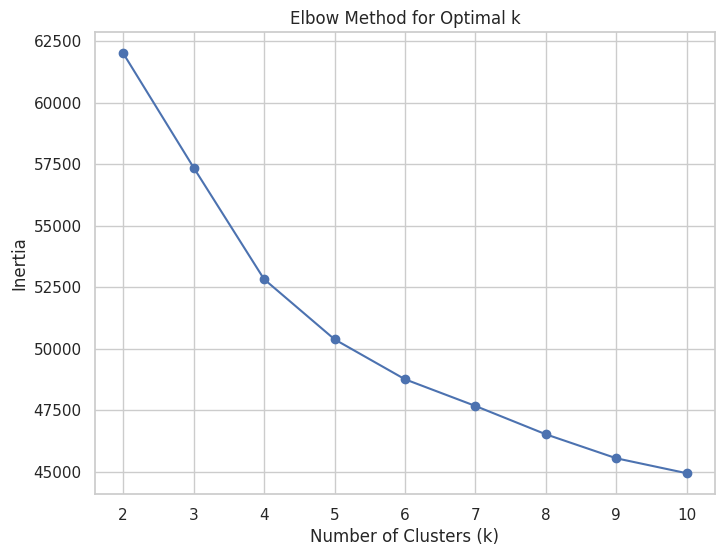


--- Visualizing Silhouette Scores for k in [2, 3, 4, 5, 6, 7, 8, 9, 10] ---


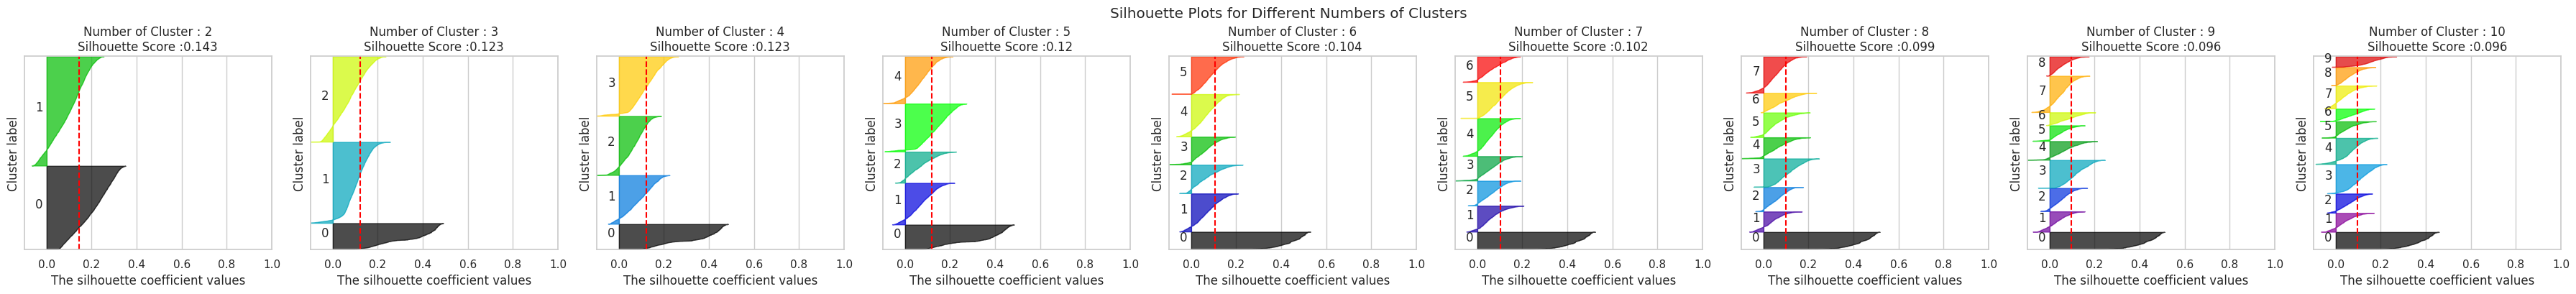


>>> Please examine the plots and set the 'optimal_k' variable in the code. <<<
>>> Currently using optimal_k = 4 (example value). <<<

=== Iteration 1: Baseline Clustering (KMeans, k=4) ===

--- Running Iteration with 20 features ---

--- Preprocessing ---
Numeric columns in current df: ['HE_sbp1', 'HE_dbp1', 'HE_wc', 'HE_HbA1c', 'HE_chol', 'HE_HDL_st2', 'HE_crea', 'HE_ast', 'age', 'L_OUT_FQ', 'LS_VEG1']
Categorical columns in current df: ['HE_HP', 'HE_DM_HbA1c', 'sex', 'BS1_1', 'BP5', 'BD1_11', 'BP16_1', 'BS3_2', 'BE5_1']
Shape after preprocessing (scaled and OHE): (6929, 83)
PCA reduced dimensions to: 31
Explained variance ratio: 0.9544

--- Running KMeans (k=4) ---
KMeans (k=4): Silhouette Score = 0.1232

Feature Importance (Random Forest) for non-noise clusters:
sex            0.160503
age            0.137195
BS1_1          0.115499
HE_HP          0.093358
HE_crea        0.070443
HE_HbA1c       0.059616
HE_wc          0.057929
HE_sbp1        0.056770
BD1_11         0.031570
HE_HDL

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm # For silhouette plot colors
import seaborn as sns

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.ensemble import RandomForestClassifier

# ÌÜµÍ≥Ñ Î∂ÑÏÑùÏùÑ ÏúÑÌïú ÎùºÏù¥Î∏åÎü¨Î¶¨ ÏûÑÌè¨Ìä∏
from scipy import stats
import statsmodels.api as sm # Ïπ¥Ïù¥Ï†úÍ≥± Í≤ÄÏ†ï Í≤∞Í≥ºÎ•º Ï¢Ä Îçî ÏÉÅÏÑ∏Ìûà Î≥¥Ïó¨Ï£ºÍ∏∞ ÏúÑÌï¥ Ï∂îÍ∞Ä (Optional)
from statsmodels.stats.contingency_tables import Table # Ïπ¥Ïù¥Ï†úÍ≥± Í≤ÄÏ†ïÏùÑ ÏúÑÌïú ÌÅ¥ÎûòÏä§

# ÏãúÍ∞ÅÌôî ÏÑ§Ï†ï
sns.set(style="whitegrid")

# Ï†ÑÏ≤òÎ¶¨ Ìï®Ïàò (Ïù¥Ï†Ñ ÏΩîÎìúÏôÄ ÎèôÏùº)
def preprocess_data(df, original_numeric_cols, original_categorical_cols):
    """
    Preprocess data: impute missing values, handle outliers, encode categorical features.
    Processes only the columns present in the input df, based on original_numeric_cols and original_categorical_cols.
    """
    df_processed = df.copy()

    current_numeric_cols = [col for col in original_numeric_cols if col in df_processed.columns]
    current_categorical_cols = [col for col in original_categorical_cols if col in df_processed.columns]

    print(f"\n--- Preprocessing ---")
    print(f"Numeric columns in current df: {current_numeric_cols}")
    print(f"Categorical columns in current df: {current_categorical_cols}")

    # 888, 999 Í∞íÏùÑ NaNÏúºÎ°ú ÎåÄÏ≤¥
    df_processed = df_processed.replace([888, 999], np.nan)

    # Ïà´ÏûêÌòï ÏπºÎüº Í≤∞Ï∏°Ïπò KNN ImputerÎ°ú Ï≤òÎ¶¨
    if current_numeric_cols:
        # ImputerÎäî fit_transform ÏãúÏ†êÏóê Í≤∞Ï∏°ÏπòÎ•º ÌïôÏäµÌïòÍ≥† Ï±ÑÏõÅÎãàÎã§.
        # Ïù¥ Ìï®ÏàòÎäî Îß§Î≤à ÏÉàÎ°úÏö¥ ImputerÎ•º ÏÉùÏÑ±ÌïòÏó¨ fit_transform Ìï©ÎãàÎã§.
        # ÎßåÏïΩ ÏùºÍ¥ÄÎêú ImputerÎ•º ÏÇ¨Ïö©ÌïòÎ†§Î©¥ Ìï®Ïàò Ïô∏Î∂ÄÏóêÏÑú fit Îêú ImputerÎ•º Ï†ÑÎã¨Ìï¥Ïïº Ìï©ÎãàÎã§.
        # ÌòÑÏû¨ ÏΩîÎìú ÌùêÎ¶Ñ ÏÉÅ Í∑∏Î£πÎ≥Ñ/ÌîºÏ≤òÏÖãÎ≥ÑÎ°ú Îã§Î•∏ ImputerÍ∞Ä ÌïÑÏöîÌï† Ïàò ÏûàÏúºÎØÄÎ°ú Ïù¥ Î∞©Ïãù Ïú†ÏßÄ
        numeric_data_for_impute = df_processed[current_numeric_cols].values
        imputer = KNNImputer(n_neighbors=5)
        numeric_data_imputed = imputer.fit_transform(numeric_data_for_impute)
        df_processed[current_numeric_cols] = numeric_data_imputed

    # Î≤îÏ£ºÌòï ÏπºÎüº Í≤∞Ï∏°Ïπò ÏµúÎπàÍ∞íÏúºÎ°ú Ï≤òÎ¶¨
    if current_categorical_cols:
        for col in current_categorical_cols:
             if df_processed[col].isnull().any():
                 try:
                     # mode() Í≤∞Í≥ºÎäî SeriesÏù¥ÎØÄÎ°ú [0]ÏúºÎ°ú Ï≤´ Î≤àÏß∏ Í∞í ÏÑ†ÌÉù
                     mode_val = df_processed[col].mode()[0]
                     df_processed[col] = df_processed[col].fillna(mode_val)
                 except IndexError:
                     # mode()Í∞Ä ÎπÑÏñ¥ÏûàÎäî Í≤ΩÏö∞ (Î™®Îì† Í∞íÏù¥ NaNÏùº Îïå)
                     print(f"Warning: Could not compute mode for {col} or all values are NaN. Skipping fillna for this column.")
                     pass # fillnaÎ•º Í±¥ÎÑàÎõ∞Ïñ¥ Ìï¥Îãπ ÏπºÎüºÏùÄ Ïó¨Ï†ÑÌûà NaNÏùÑ Í∞ÄÏßà Ïàò ÏûàÏùå (Ï£ºÏùò ÌïÑÏöî)
                 except Exception as e:
                     print(f"Error filling categorical missing values for {col}: {e}")
                     pass


    # Ïù¥ÏÉÅÏπò Ï≤òÎ¶¨ (IQR Í∏∞Ï§Ä) - Ïà´ÏûêÌòï ÏπºÎüºÏóêÎßå Ï†ÅÏö©
    if current_numeric_cols:
        for col in current_numeric_cols:
            # IQR Í≥ÑÏÇ∞
            Q1 = df_processed[col].quantile(0.25)
            Q3 = df_processed[col].quantile(0.75)
            IQR = Q3 - Q1
            # Ïù¥ÏÉÅÏπò Í≤ΩÍ≥Ñ Í≥ÑÏÇ∞
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            # Ïù¥ÏÉÅÏπò Í∞íÏùÑ Í≤ΩÍ≥ÑÍ∞íÏúºÎ°ú ÎåÄÏ≤¥ (ÌÅ¥Î¶¨Ìïë)
            df_processed[col] = df_processed[col].clip(lower_bound, upper_bound)

    # Ï†ÑÏ≤òÎ¶¨Î•º ÏúÑÌïú ColumnTransformer ÏÑ§Ï†ï
    transformers = []
    if current_numeric_cols:
        # Ïà´ÏûêÌòï ÏπºÎüºÏóê RobustScaler Ï†ÅÏö© (Ïù¥ÏÉÅÏπòÏóê Í∞ïÌï®)
        transformers.append(('num', RobustScaler(), current_numeric_cols))
    if current_categorical_cols:
        # Î≤îÏ£ºÌòï ÏπºÎüºÏóê OneHotEncoder Ï†ÅÏö©
        # handle_unknown='ignore': ÌïôÏäµ Îç∞Ïù¥ÌÑ∞Ïóê ÏóÜÎçò ÏÉàÎ°úÏö¥ Î≤îÏ£ºÍ∞Ä ÏòàÏ∏° Ïãú ÎÇòÌÉÄÎÇòÎ©¥ Î¨¥Ïãú
        transformers.append(('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), current_categorical_cols))

    # Î≥ÄÌôòÌï† ÏπºÎüºÏù¥ ÏóÜÏúºÎ©¥ Îπà Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ Î∞òÌôò
    if not transformers:
        print("No numeric or categorical columns remaining after filtering.")
        # scaled_df, all_transformed_features, preprocessor, df_processed_subset Î∞òÌôò
        return pd.DataFrame(), [], None, df_processed

    # ColumnTransformer ÏÉùÏÑ± Î∞è ÌïôÏäµ/Î≥ÄÌôò
    preprocessor = ColumnTransformer(
        transformers=transformers,
        remainder='passthrough' # Î≥ÄÌôòÍ∏∞Ïóê ÏßÄÏ†ïÎêòÏßÄ ÏïäÏùÄ ÏπºÎüºÏùÄ Í∑∏ÎåÄÎ°ú Ïú†ÏßÄ
    )

    try:
        # preprocessorÎ•º Îç∞Ïù¥ÌÑ∞Ïóê fit_transform Ìï©ÎãàÎã§.
        scaled_data = preprocessor.fit_transform(df_processed)
        # Î≥ÄÌôò ÌõÑ ÏπºÎüº Ïù¥Î¶Ñ Í∞ÄÏ†∏Ïò§Í∏∞
        all_transformed_features = preprocessor.get_feature_names_out()
        # Î≥ÄÌôòÎêú Îç∞Ïù¥ÌÑ∞Î•º DataFrameÏúºÎ°ú Î≥ÄÌôò (ÏπºÎüº Ïù¥Î¶Ñ Ìè¨Ìï®)
        scaled_df = pd.DataFrame(scaled_data, columns=all_transformed_features)
        print(f"Shape after preprocessing (scaled and OHE): {scaled_df.shape}")
    except Exception as e:
        print(f"Error during preprocessing transformation: {e}")
        # Ïò§Î•ò Î∞úÏÉù Ïãú Îπà Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ Îì± Î∞òÌôò
        return pd.DataFrame(), [], None, df_processed

    # Ï†ÑÏ≤òÎ¶¨Îêú Ïä§ÏºÄÏùºÎßÅ/OHE Îç∞Ïù¥ÌÑ∞, Î≥ÄÌôòÎêú ÌîºÏ≤ò Ïù¥Î¶Ñ Î™©Î°ù, ÌïôÏäµÎêú preprocessor Í∞ùÏ≤¥, Ïù¥ÏÉÅÏπò/Í≤∞Ï∏°Ïπò Ï≤òÎ¶¨Îêú ÏõêÎ≥∏ ÌòïÌÉú Îç∞Ïù¥ÌÑ∞ Î∞òÌôò
    return scaled_df, all_transformed_features, preprocessor, df_processed

# select_features Ìï®Ïàò (Ïù¥Ï†Ñ ÏΩîÎìúÏôÄ ÎèôÏùº)
def select_features(df, columns, corr_threshold=0.8):
    """Remove highly correlated numeric features."""
    # ÏûÖÎ†•Îêú ÏπºÎüº Î™©Î°ù Ï§ë Ïà´ÏûêÌòï ÏπºÎüºÎßå ÏÑ†ÌÉù
    numeric_df = df[columns].select_dtypes(include=[np.number])
    if numeric_df.empty:
        print("No numeric columns provided for correlation check.")
        return [] # Ïà´ÏûêÌòï ÏπºÎüºÏù¥ ÏóÜÏúºÎ©¥ Îπà Î¶¨Ïä§Ìä∏ Î∞òÌôò

    # ÏÉÅÍ¥Ä ÌñâÎ†¨ Í≥ÑÏÇ∞ (Ï†àÎåÄÍ∞í ÏÇ¨Ïö©)
    corr_matrix = numeric_df.corr().abs()
    # ÏÉÅÍ¥Ä ÌñâÎ†¨Ïùò ÏÉÅÏÇºÍ∞Å ÌñâÎ†¨Îßå Í∞ÄÏ†∏Ïò¥ (ÎåÄÍ∞ÅÏÑ† Ï†úÏô∏)
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    # ÏÉÅÍ¥ÄÍ≥ÑÏàòÍ∞Ä ÏûÑÍ≥ÑÍ∞íÎ≥¥Îã§ ÎÜíÏùÄ ÏπºÎüºÎì§ÏùÑ Ï∞æÏùå
    to_drop = [column for column in upper.columns if any(upper[column] > corr_threshold)]
    # Ï†úÍ±∞Ìï† ÏπºÎüºÏùÑ Ï†úÏô∏Ìïú Ïà´ÏûêÌòï ÏπºÎüº Î™©Î°ù ÏÉùÏÑ±
    selected_numeric_cols = [col for col in columns if col not in to_drop]
    print(f"Removed highly correlated numeric features (>{corr_threshold}): {to_drop}")
    print(f"Selected numeric features after correlation check: {selected_numeric_cols}")
    return selected_numeric_cols # ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ ÌïÑÌÑ∞ÎßÅ ÌõÑ Ïà´ÏûêÌòï ÏπºÎüº Î™©Î°ù Î∞òÌôò

# compute_feature_importance Ìï®Ïàò (Ïù¥Ï†Ñ ÏΩîÎìúÏôÄ ÎèôÏùº)
def compute_feature_importance(df_processed, selected_cols, cluster_labels):
    """Compute feature importance using Random Forest."""
    # ÌÅ¥Îü¨Ïä§ÌÑ∞ ÎùºÎ≤®Ïù¥ 2Í∞ú Ïù¥ÏÉÅÏù¥Í≥† ÎÖ∏Ïù¥Ï¶à ÌÅ¥Îü¨Ïä§ÌÑ∞(-1)Îßå ÏûàÎäî Í≤ΩÏö∞Í∞Ä ÏïÑÎãê ÎïåÎßå Ï§ëÏöîÎèÑ Í≥ÑÏÇ∞
    if len(np.unique(cluster_labels[cluster_labels != -1])) < 2:
        print("\nFeature Importance: Not enough non-noise clusters (>= 2 required) or only noise cluster.")
        return pd.Series([], dtype=float) # Í≥ÑÏÇ∞ Î∂àÍ∞Ä Ïãú Îπà Series Î∞òÌôò

    # ÎÖ∏Ïù¥Ï¶à ÌÅ¥Îü¨Ïä§ÌÑ∞(-1)Ïóê Ìï¥ÎãπÌïòÎäî Îç∞Ïù¥ÌÑ∞ Ìè¨Ïù∏Ìä∏ Ï†úÏô∏
    non_noise_indices = cluster_labels != -1
    df_filtered = df_processed.loc[non_noise_indices].copy() # ÌïÑÌÑ∞ÎßÅÎêú Îç∞Ïù¥ÌÑ∞ Î≥µÏÇ¨
    labels_filtered = cluster_labels[non_noise_indices] # ÌïÑÌÑ∞ÎßÅÎêú ÎùºÎ≤®

    # ÌïÑÌÑ∞ÎßÅ ÌõÑ Îç∞Ïù¥ÌÑ∞Í∞Ä ÎπÑÏñ¥ÏûàÏúºÎ©¥ Í≥ÑÏÇ∞ Î∂àÍ∞Ä
    if df_filtered.empty:
        print("\nFeature Importance: No non-noise data points found after filtering.")
        return pd.Series([], dtype=float) # Í≥ÑÏÇ∞ Î∂àÍ∞Ä Ïãú Îπà Series Î∞òÌôò

    try:
        # Random Forest Classifier Î™®Îç∏ ÏÉùÏÑ± Î∞è ÌïôÏäµ
        rf = RandomForestClassifier(random_state=42)
        # ÌïôÏäµ Îç∞Ïù¥ÌÑ∞Îäî ÌïÑÌÑ∞ÎßÅÎêú Îç∞Ïù¥ÌÑ∞ÏôÄ Ìï¥Îãπ ÌîºÏ≤òÎì§, ÌïÑÌÑ∞ÎßÅÎêú ÎùºÎ≤® ÏÇ¨Ïö©
        # df_filteredÎäî Ïù¥ÏÉÅÏπò/Í≤∞Ï∏°Ïπò Ï≤òÎ¶¨Îêú ÏõêÎ≥∏ ÌòïÌÉúÏùò Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏûÖÎãàÎã§.
        # OHEÎêú Îç∞Ïù¥ÌÑ∞Í∞Ä ÌïÑÏöîÌïòÎã§Î©¥ scaled_dfÎ•º ÏÇ¨Ïö©Ìï¥Ïïº Ìï©ÎãàÎã§.
        # ÌòÑÏû¨ ÏΩîÎìúÎäî df_processed_subset (Ïù¥ÏÉÅÏπò/Í≤∞Ï∏°Ïπò Ï≤òÎ¶¨Îêú ÏõêÎ≥∏ ÌòïÌÉú)Î•º ÏÇ¨Ïö©Ìï©ÎãàÎã§.
        # ÎßåÏïΩ OHEÎêú Îç∞Ïù¥ÌÑ∞Î°ú Ï§ëÏöîÎèÑÎ•º Í≥ÑÏÇ∞ÌïòÎ†§Î©¥ scaled_dfÏôÄ all_transformed_featuresÎ•º ÏÇ¨Ïö©ÌïòÎèÑÎ°ù ÏàòÏ†ï ÌïÑÏöî.
        # Ïó¨Í∏∞ÏÑúÎäî Í∏∞Ï°¥ ÏΩîÎìúÎåÄÎ°ú df_processed_subsetÏùÑ ÏÇ¨Ïö©Ìï©ÎãàÎã§.
        rf.fit(df_filtered[selected_cols], labels_filtered)
        # ÌîºÏ≤ò Ï§ëÏöîÎèÑ Ï∂îÏ∂ú Î∞è SeriesÎ°ú Î≥ÄÌôò ÌõÑ ÎÇ¥Î¶ºÏ∞®Ïàú Ï†ïÎ†¨
        importance = pd.Series(rf.feature_importances_, index=selected_cols).sort_values(ascending=False)
        print("\nFeature Importance (Random Forest) for non-noise clusters:")
        print(importance)
        return importance # ÌîºÏ≤ò Ï§ëÏöîÎèÑ Series Î∞òÌôò

    except Exception as e:
        print(f"\nError computing Feature Importance: {e}")
        return pd.Series([], dtype=float) # Ïò§Î•ò Î∞úÏÉù Ïãú Îπà Series Î∞òÌôò

# visualize_silhouette Ìï®Ïàò (Ïù¥Ï†Ñ ÏΩîÎìúÏôÄ ÎèôÏùº)
def visualize_silhouette(cluster_lists, X_features):
    """
    Ï£ºÏñ¥ÏßÑ ÌÅ¥Îü¨Ïä§ÌÑ∞ Í∞úÏàò Î¶¨Ïä§Ìä∏Ïóê ÎåÄÌï¥ K-MeansÎ•º Ï†ÅÏö©ÌïòÍ≥† Ïã§Î£®Ïó£ Í≥ÑÏàòÎ•º ÏãúÍ∞ÅÌôîÌï©ÎãàÎã§.

    Args:
        cluster_lists (list): ÌÖåÏä§Ìä∏Ìï† ÌÅ¥Îü¨Ïä§ÌÑ∞ Í∞úÏàò(k)Ïùò Î¶¨Ïä§Ìä∏.
        X_features (numpy.ndarray or pandas.DataFrame): ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅ ÎåÄÏÉÅ Îç∞Ïù¥ÌÑ∞ (PCA Í≤∞Í≥º Îì±).
    """
    print(f"\n--- Visualizing Silhouette Scores for k in {cluster_lists} ---")

    n_cols = len(cluster_lists)
    # ÏÑúÎ∏åÌîåÎ°Ø ÏÉùÏÑ±. n_colsÍ∞Ä 1Ïùº Îïå axsÍ∞Ä Î∞∞Ïó¥Ïù¥ ÏïÑÎãàÎØÄÎ°ú reshape(-1)Î°ú Ìï≠ÏÉÅ Î∞∞Ïó¥ ÌòïÌÉúÎ°ú ÎßåÎì¶
    fig, axs = plt.subplots(figsize=(4 * n_cols, 4), nrows=1, ncols=n_cols, squeeze=False)
    axs = axs.reshape(-1) # 1D Î∞∞Ïó¥Î°ú ÌèâÌÉÑÌôî

    for ind, n_cluster in enumerate(cluster_lists):
        ax = axs[ind] # Í∞Å ÏÑúÎ∏åÌîåÎ°Ø ÏÑ†ÌÉù

        try:
            # ÌÅ¥Îü¨Ïä§ÌÑ∞ Í∞úÏàòÍ∞Ä 2Í∞ú ÎØ∏ÎßåÏù¥Î©¥ Ïã§Î£®Ïó£ Ï†êÏàò Í≥ÑÏÇ∞ Î∂àÍ∞Ä
            if n_cluster < 2:
                print(f"Skipping silhouette visualization for k={n_cluster} (< 2).")
                ax.set_title(f'k={n_cluster} (Skipped)')
                ax.text(0.5, 0.5, 'k < 2', horizontalalignment='center', verticalalignment='center')
                ax.set_xticks([])
                ax.set_yticks([])
                continue # Îã§Ïùå kÎ°ú ÎÑòÏñ¥Í∞ê

            # K-Means Î™®Îç∏ ÏÉùÏÑ± Î∞è ÌïôÏäµ
            # n_init='auto' ÎòêÎäî Î™ÖÏãúÏ†ÅÏù∏ Ïà´ÏûêÎ°ú ÏßÄÏ†ï ÌïÑÏöî
            clusterer = KMeans(n_clusters=n_cluster, max_iter=500, random_state=0, n_init='auto')
            cluster_labels = clusterer.fit_predict(X_features)

            # Ïã§Î£®Ïó£ Ï†êÏàò Í≥ÑÏÇ∞
            sil_avg = silhouette_score(X_features, cluster_labels)
            sil_values = silhouette_samples(X_features, cluster_labels)

            # Ïã§Î£®Ïó£ ÌîåÎ°Ø Í∑∏Î¶¨Í∏∞ ÏÑ§Ï†ï
            y_lower = 10 # Ï≤´ Î≤àÏß∏ ÌÅ¥Îü¨Ïä§ÌÑ∞ ÌîåÎ°ØÏùò ÏãúÏûë ÏúÑÏπò

            # ÌîåÎ°Ø Ï†úÎ™© ÏÑ§Ï†ï (kÍ∞í Î∞è ÌèâÍ∑† Ïã§Î£®Ïó£ Ï†êÏàò Ìè¨Ìï®)
            ax.set_title('Number of Cluster : ' + str(n_cluster)+'\n' \
                         'Silhouette Score :' + str(round(sil_avg,3)) )
            ax.set_xlabel("The silhouette coefficient values")
            ax.set_ylabel("Cluster label")
            ax.set_xlim([-0.1, 1]) # xÏ∂ï Î≤îÏúÑ ÏÑ§Ï†ï
            ax.set_ylim([0, len(X_features) + (n_cluster + 1) * 10]) # yÏ∂ï Î≤îÏúÑ ÏÑ§Ï†ï
            ax.set_yticks([]) # yÏ∂ï Ìã± Ï†úÍ±∞
            ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1]) # xÏ∂ï Ìã± ÏÑ§Ï†ï

            # Í∞Å ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ Ïã§Î£®Ïó£ ÌîåÎ°Ø Í∑∏Î¶¨Í∏∞
            for i in range(n_cluster):
                # iÎ≤àÏß∏ ÌÅ¥Îü¨Ïä§ÌÑ∞Ïóê Ìï¥ÎãπÌïòÎäî Ïã§Î£®Ïó£ Ï†êÏàò Í∞ÄÏ†∏Ïò§Í∏∞
                ith_cluster_sil_values = sil_values[cluster_labels == i]
                ith_cluster_sil_values.sort() # Ï†êÏàò Ï†ïÎ†¨

                size_cluster_i = ith_cluster_sil_values.shape[0] # ÌÅ¥Îü¨Ïä§ÌÑ∞ iÏùò ÏÉòÌîå Ïàò
                y_upper = y_lower + size_cluster_i # ÌòÑÏû¨ ÌÅ¥Îü¨Ïä§ÌÑ∞ ÌîåÎ°ØÏùò ÎÅù ÏúÑÏπò

                # ÌÅ¥Îü¨Ïä§ÌÑ∞ ÏÉâÏÉÅ ÏÑ§Ï†ï
                color = cm.nipy_spectral(float(i) / n_cluster)
                # fill_betweenxÎ•º ÏÇ¨Ïö©ÌïòÏó¨ Ïã§Î£®Ïó£ Ï†êÏàò ÏòÅÏó≠ Ï±ÑÏö∞Í∏∞
                ax.fill_betweenx(np.arange(y_lower, y_upper),
                                 0, ith_cluster_sil_values,
                                 facecolor=color, edgecolor=color, alpha=0.7)

                # ÌÅ¥Îü¨Ïä§ÌÑ∞ Î≤àÌò∏ ÌÖçÏä§Ìä∏ Ï∂îÍ∞Ä
                ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

                # Îã§Ïùå ÌÅ¥Îü¨Ïä§ÌÑ∞ ÌîåÎ°ØÏùÑ ÏúÑÌïú y_lower ÏúÑÏπò ÏóÖÎç∞Ïù¥Ìä∏
                y_lower = y_upper + 10 # ÌÅ¥Îü¨Ïä§ÌÑ∞ Í∞Ñ Í∞ÑÍ≤© Ï∂îÍ∞Ä

            # ÌèâÍ∑† Ïã§Î£®Ïó£ Ï†êÏàò ÎùºÏù∏ Ï∂îÍ∞Ä
            ax.axvline(x=sil_avg, color="red", linestyle="--")

        except Exception as e:
            print(f"Error visualizing silhouette for k={n_cluster}: {e}")
            ax.set_title(f'k={n_cluster} (Error)')
            ax.text(0.5, 0.5, 'Error', horizontalalignment='center', verticalalignment='center')
            ax.set_xticks([])
            ax.set_yticks([])

    # Ï†ÑÏ≤¥ ÌîåÎ°Ø Î†àÏù¥ÏïÑÏõÉ Ï°∞Ï†ï Î∞è Ï†úÎ™© Ï∂îÍ∞Ä
    plt.tight_layout()
    plt.suptitle('Silhouette Plots for Different Numbers of Clusters', y=1.02)
    plt.show()


# Îã®Ïùº ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅ Ïù¥ÌÑ∞Î†àÏù¥ÏÖòÏùÑ Ïã§ÌñâÌïòÎäî Ìï®Ïàò (Ïù¥Ï†Ñ ÏΩîÎìúÏôÄ ÎèôÏùº)
def run_clustering_iteration(df_original, features_to_use, original_numeric_cols, original_categorical_cols, n_clusters, algorithm):
    """
    Runs one iteration of preprocessing, PCA, clustering, scoring, and importance calculation
    using a specified subset of features.
    Returns scaled_df_pca for direct use in analysis functions.
    """
    print(f"\n--- Running Iteration with {len(features_to_use)} features ---")

    if not features_to_use:
        print("No features selected for this iteration. Skipping.")
        # scaled_df_pca Ï∂îÍ∞Ä Î∞òÌôòÍ∞í None
        return None, None, None, None, None, None, None

    # ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏóêÏÑú ÏÇ¨Ïö©Ìï† ÌîºÏ≤òÎßå ÏÑ†ÌÉùÌïòÏó¨ Î≥µÏÇ¨Î≥∏ ÏÉùÏÑ±
    df_subset = df_original[features_to_use].copy()

    try:
        # Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨ (Í≤∞Ï∏°Ïπò, Ïù¥ÏÉÅÏπò Ï≤òÎ¶¨, Ïä§ÏºÄÏùºÎßÅ, OHE)
        # preprocess_data Ìï®ÏàòÎäî scaled_df (Ïä§ÏºÄÏùºÎßÅ/OHE ÏôÑÎ£å), all_transformed_features,
        # preprocessor Í∞ùÏ≤¥, df_processed_subset (Ïù¥ÏÉÅÏπò/Í≤∞Ï∏°Ïπò Ï≤òÎ¶¨Îêú ÏõêÎ≥∏ ÌòïÌÉú) Î∞òÌôò
        scaled_df, all_transformed_features, preprocessor, df_processed_subset = preprocess_data(
            df_subset,
            original_numeric_cols,
            original_categorical_cols
        )
        # Ï†ÑÏ≤òÎ¶¨ Í≤∞Í≥º Îç∞Ïù¥ÌÑ∞Í∞Ä ÎπÑÏñ¥ÏûàÏúºÎ©¥ Ïä§ÌÇµ
        if scaled_df.empty:
            print("Preprocessing returned empty data. Skipping iteration.")
            return features_to_use, None, None, None, df_processed_subset, None, None

    except Exception as e:
        print(f"An error occurred during preprocessing: {e}. Skipping iteration.")
        return features_to_use, None, None, None, None, None, None

    # PCAÎ•º ÏÇ¨Ïö©ÌïòÏó¨ Ï∞®Ïõê Ï∂ïÏÜå
    pca = PCA(n_components=0.95, random_state=42) # ÏÑ§Î™ÖÎêú Î∂ÑÏÇ∞Ïùò 95%Î•º Ïú†ÏßÄÌïòÎèÑÎ°ù Ï∞®Ïõê Ï∂ïÏÜå
    scaled_df_pca = None # PCA Í≤∞Í≥º Î≥ÄÏàò Ï¥àÍ∏∞Ìôî
    try:
        # Ïä§ÏºÄÏùºÎßÅ/OHE ÏôÑÎ£åÎêú Îç∞Ïù¥ÌÑ∞Ïóê PCA Ï†ÅÏö©
        scaled_df_pca = pca.fit_transform(scaled_df)
        print(f"PCA reduced dimensions to: {scaled_df_pca.shape[1]}")
        print(f"Explained variance ratio: {sum(pca.explained_variance_ratio_):.4f}")
    except Exception as e:
        print(f"PCA failed: {e}. Skipping clustering and importance.")
        # PCA Ïã§Ìå® Ïãú Í¥ÄÎ†® Î≥ÄÏàò NoneÏúºÎ°ú Î∞òÌôò
        return features_to_use, None, None, None, df_processed_subset, scaled_df, None

    # PCA Í≤∞Í≥º Îç∞Ïù¥ÌÑ∞Í∞Ä ÎπÑÏñ¥ÏûàÍ±∞ÎÇò Ìñâ ÏàòÍ∞Ä 0Ïù¥Î©¥ Ïä§ÌÇµ
    if scaled_df_pca is None or scaled_df_pca.shape[0] == 0:
        print("PCA returned no data. Skipping clustering and importance.")
        return features_to_use, None, None, None, df_processed_subset, scaled_df, None


    # ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅ ÏïåÍ≥†Î¶¨Ï¶ò ÏÑ†ÌÉù Î∞è Ïã§Ìñâ
    clusters = None # ÌÅ¥Îü¨Ïä§ÌÑ∞ ÎùºÎ≤® Î≥ÄÏàò Ï¥àÍ∏∞Ìôî
    score = None # Ïã§Î£®Ïó£ Ï†êÏàò Î≥ÄÏàò Ï¥àÍ∏∞Ìôî
    algorithm_used = None # ÏÇ¨Ïö©Îêú ÏïåÍ≥†Î¶¨Ï¶ò Ïù¥Î¶Ñ Î≥ÄÏàò Ï¥àÍ∏∞Ìôî

    try:
        if algorithm == 'Agglomerative':
            algorithm_used = f'Agglomerative (k={n_clusters})'
            print(f"\n--- Running {algorithm_used} ---")
            # Agglomerative Clustering Î™®Îç∏ ÏÉùÏÑ± Î∞è ÌïôÏäµ/ÏòàÏ∏°
            model = AgglomerativeClustering(n_clusters=n_clusters)
            clusters = model.fit_predict(scaled_df_pca)

        elif algorithm == 'KMeans':
            algorithm_used = f'KMeans (k={n_clusters})'
            print(f"\n--- Running {algorithm_used} ---")
            # K-Means Î™®Îç∏ ÏÉùÏÑ± Î∞è ÌïôÏäµ/ÏòàÏ∏°
            # n_init='auto' ÎòêÎäî Î™ÖÏãúÏ†ÅÏù∏ Ïà´ÏûêÎ°ú ÏßÄÏ†ï ÌïÑÏöî
            model = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
            clusters = model.fit_predict(scaled_df_pca)

        # DBSCAN ÏïåÍ≥†Î¶¨Ï¶ò (ÌïÑÏöîÌïòÎã§Î©¥ Ï∂îÍ∞Ä)
        # elif algorithm == 'DBSCAN':
        #     algorithm_used = f'DBSCAN (eps={eps}, min_samples={min_samples})'
        #     print(f"\n--- Running {algorithm_used} ---")
        #     model = DBSCAN(eps=eps, min_samples=min_samples)
        #     clusters = model.fit_predict(scaled_df_pca)

        else:
            # ÏßÄÏõêÌïòÏßÄ ÏïäÎäî ÏïåÍ≥†Î¶¨Ï¶òÏù∏ Í≤ΩÏö∞ Ïò§Î•ò Î∞úÏÉù
            raise ValueError(f"Unsupported algorithm: {algorithm}")

        # Ïã§Î£®Ïó£ Ïä§ÏΩîÏñ¥ Í≥ÑÏÇ∞
        # ÌÅ¥Îü¨Ïä§ÌÑ∞ Í∞úÏàòÍ∞Ä 1Í∞úÎ≥¥Îã§ ÎßéÍ≥†, Î™®Îì† Îç∞Ïù¥ÌÑ∞Í∞Ä ÎÖ∏Ïù¥Ï¶à ÌÅ¥Îü¨Ïä§ÌÑ∞(-1)Ïóê ÏÜçÌïòÏßÄ ÏïäÏùÑ ÎïåÎßå Í≥ÑÏÇ∞ Í∞ÄÎä•
        # Agglomerative/KMeansÎäî Í∏∞Î≥∏Ï†ÅÏúºÎ°ú Î™®Îì† Îç∞Ïù¥ÌÑ∞Ïóê ÎùºÎ≤®ÏùÑ Ìï†ÎãπÌïòÎØÄÎ°ú -1 ÌÅ¥Îü¨Ïä§ÌÑ∞Îäî ÏóÜÏäµÎãàÎã§.
        if len(np.unique(clusters)) > 1: # ÌÅ¥Îü¨Ïä§ÌÑ∞ Í∞úÏàòÍ∞Ä 2Í∞ú Ïù¥ÏÉÅÏùº Îïå
             score = silhouette_score(scaled_df_pca, clusters)
             print(f"{algorithm_used}: Silhouette Score = {score:.4f}")
        else:
             print(f"{algorithm_used}: Silhouette Score not computable (less than 2 clusters).")
             score = None # Í≥ÑÏÇ∞ Î∂àÍ∞Ä Ïãú score None ÏÑ§Ï†ï

    except Exception as e:
        print(f"{algorithm_used} failed: {e}")
        clusters = None # ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅ Ïã§Ìå® Ïãú clusters None ÏÑ§Ï†ï
        score = None # Ïä§ÏΩîÏñ¥ Í≥ÑÏÇ∞ Ïã§Ìå® Ïãú score None ÏÑ§Ï†ï


    # ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅÏù¥ ÏÑ±Í≥µÌïòÍ≥† Ïã§Î£®Ïó£ Ïä§ÏΩîÏñ¥ Í≥ÑÏÇ∞Ïù¥ Í∞ÄÎä•ÌñàÏùÑ ÎïåÎßå ÌîºÏ≤ò Ï§ëÏöîÎèÑ Í≥ÑÏÇ∞
    if clusters is None or score is None:
        print("Clustering failed or score could not be computed. Skipping importance calculation.")
        # features_to_use, clusters, score, importance, df_processed_subset, scaled_df, scaled_df_pca Î∞òÌôò
        return features_to_use, clusters, score, None, df_processed_subset, scaled_df, scaled_df_pca # importance None


    # ÌîºÏ≤ò Ï§ëÏöîÎèÑ Í≥ÑÏÇ∞
    # compute_feature_importance Ìï®ÏàòÎäî Ïù¥ÏÉÅÏπò/Í≤∞Ï∏°Ïπò Ï≤òÎ¶¨Îêú ÏõêÎ≥∏ ÌòïÌÉú Îç∞Ïù¥ÌÑ∞(df_processed_subset)ÏôÄ ÌÅ¥Îü¨Ïä§ÌÑ∞ ÎùºÎ≤® ÏÇ¨Ïö©
    importance = compute_feature_importance(df_processed_subset, features_to_use, clusters)

    # ÏÇ¨Ïö©Îêú ÌîºÏ≤ò Î™©Î°ù, ÌÅ¥Îü¨Ïä§ÌÑ∞ ÎùºÎ≤®, Ïã§Î£®Ïó£ Ï†êÏàò, ÌîºÏ≤ò Ï§ëÏöîÎèÑ, Ïù¥ÏÉÅÏπò/Í≤∞Ï∏°Ïπò Ï≤òÎ¶¨Îêú Îç∞Ïù¥ÌÑ∞,
    # Ïä§ÏºÄÏùºÎßÅ/OHE ÏôÑÎ£åÎêú Îç∞Ïù¥ÌÑ∞, PCA Í≤∞Í≥º Îç∞Ïù¥ÌÑ∞ Î∞òÌôò
    return features_to_use, clusters, score, importance, df_processed_subset, scaled_df, scaled_df_pca


def main():
    """K-Means Clustering analysis using Elbow and Silhouette methods for optimal k."""
    # Îç∞Ïù¥ÌÑ∞ Î°úÎìú
    df_original = pd.read_csv("/content/ÏÑ†ÌÉùÏª¨Îüº_Í±¥Í∞ïÎç∞Ïù¥ÌÑ∞.csv")
    print(f"Data loaded. Shape: {df_original.shape}")

    # ÏõêÎ≥∏ Ï†ÑÏ≤¥ ÌîºÏ≤ò Ï†ïÏùò (Ïã§Ï†ú Îç∞Ïù¥ÌÑ∞ ÏπºÎüºÎ™ÖÍ≥º ÏùºÏπòÌï¥Ïïº Ìï©ÎãàÎã§)
    # Ïù¥ Î™©Î°ùÏùÄ Îç∞Ïù¥ÌÑ∞ÏÖãÏóê Ï°¥Ïû¨ÌïòÎäî Î™®Îì† Ïû†Ïû¨Ï†ÅÏù∏ Ïà´ÏûêÌòï/Î≤îÏ£ºÌòï ÌîºÏ≤òÎ•º Ìè¨Ìï®Ìï¥Ïïº Ìï©ÎãàÎã§.
    original_numeric_cols = [
        'HE_sbp1', 'HE_dbp1', 'HE_wc', 'HE_HbA1c',
        'HE_chol', 'HE_HDL_st2', 'HE_LDL_drct', 'HE_crea',
        'HE_ast', 'HE_alt', 'HE_BMI',
        'age', 'L_OUT_FQ', 'LS_VEG1'
    ]
    original_categorical_cols = [
        'HE_HP', 'HE_DM_HbA1c', 'sex', 'BS1_1', 'BP5',
        "BD1_11", "BP16_1", "BS3_2", "BE5_1", # Ïù¥Ï†Ñ ÏΩîÎìúÏóêÏÑú selected_colsÏóê Ï∂îÍ∞ÄÎêòÏóàÎçò Î≤îÏ£ºÌòïÎì§
    ] # Ïã§Ï†ú Îç∞Ïù¥ÌÑ∞Ïùò Î™®Îì† Î≤îÏ£ºÌòï ÏπºÎüºÏùÑ Ïó¨Í∏∞Ïóê Ìè¨Ìï®ÏãúÏºúÏïº Ìï©ÎãàÎã§.

    # Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏóê Ïã§Ï†úÎ°ú Ï°¥Ïû¨ÌïòÎäî ÏπºÎüºÎì§Îßå ÌïÑÌÑ∞ÎßÅ
    original_numeric_cols = [col for col in original_numeric_cols if col in df_original.columns]
    original_categorical_cols = [col for col in original_categorical_cols if col in df_original.columns]

    print(f"\nNumeric columns found in data: {original_numeric_cols}")
    print(f"Categorical columns found in data: {original_categorical_cols}")

    # Ï¥àÍ∏∞ Ïà´ÏûêÌòï ÌîºÏ≤ò ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ Í∏∞Î∞ò ÌïÑÌÑ∞ÎßÅ (ÌõÑÎ≥¥Íµ∞ Ï∂ïÏÜå)
    # Ï†ÑÏ≤¥ Ïà´ÏûêÌòï ÏπºÎüºÏùÑ ÎåÄÏÉÅÏúºÎ°ú ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ ÌïÑÌÑ∞ÎßÅ ÏàòÌñâ
    selected_numeric_after_corr = select_features(df_original.copy(), original_numeric_cols, corr_threshold=0.8)

    # Íµ∞Ïßë Î∂ÑÏÑùÏóê ÏÇ¨Ïö©Ìï† Ï¥àÍ∏∞ Ï†ÑÏ≤¥ ÌîºÏ≤ò Î™©Î°ù (ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ ÌïÑÌÑ∞ÎßÅÎêú Ïà´ÏûêÌòï + Ï†ÑÏ≤¥ Î≤îÏ£ºÌòï)
    current_features_for_clustering = selected_numeric_after_corr + original_categorical_cols

    if not current_features_for_clustering:
        print("No features remaining for clustering after initial filtering. Exiting.")
        return

    print(f"\nInitial features for clustering ({len(current_features_for_clustering)}): {current_features_for_clustering}")

    # --- Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨ (ÏóòÎ≥¥Ïö∞ Î∞è Ïã§Î£®Ïó£ ÏãúÍ∞ÅÌôîÎ•º ÏúÑÌï¥ ÌïÑÏöî) ---
    # Íµ∞Ïßë Î∂ÑÏÑùÏóê ÏÇ¨Ïö©Ìï† Ï¥àÍ∏∞ Ï†ÑÏ≤¥ ÌîºÏ≤ò Î™©Î°ùÏúºÎ°ú Îç∞Ïù¥ÌÑ∞Î•º Ï†ÑÏ≤òÎ¶¨Ìï©ÎãàÎã§.
    # Ïù¥ Ï†ÑÏ≤òÎ¶¨ Í≤∞Í≥ºÎäî ÏóòÎ≥¥Ïö∞ Î∞©Î≤ï Î∞è Ïã§Î£®Ïó£ ÏãúÍ∞ÅÌôîÏóê ÏÇ¨Ïö©Îê©ÎãàÎã§.
    try:
        scaled_df_initial, all_transformed_features_initial, preprocessor_initial, df_processed_initial = preprocess_data(
            df_original[current_features_for_clustering].copy(), # Ï¥àÍ∏∞ ÌîºÏ≤ò Î™©Î°ùÏúºÎ°ú ÏÑúÎ∏åÏÖã ÎßåÎì§Í≥† Î≥µÏÇ¨
            original_numeric_cols,
            original_categorical_cols
        )
        if scaled_df_initial.empty:
            print("Initial preprocessing returned empty data. Cannot proceed with Elbow/Silhouette.")
            return
    except Exception as e:
        print(f"An error occurred during initial preprocessing: {e}. Cannot proceed.")
        return

    # --- PCA Ï†ÅÏö© (ÏóòÎ≥¥Ïö∞ Î∞è Ïã§Î£®Ïó£ ÏãúÍ∞ÅÌôîÎ•º ÏúÑÌï¥ ÌïÑÏöî) ---
    # Ï†ÑÏ≤òÎ¶¨Îêú Îç∞Ïù¥ÌÑ∞Ïóê PCAÎ•º Ï†ÅÏö©Ìï©ÎãàÎã§.
    pca_initial = PCA(n_components=0.95, random_state=42)
    try:
        scaled_df_pca_initial = pca_initial.fit_transform(scaled_df_initial)
        print(f"\nInitial PCA reduced dimensions to: {scaled_df_pca_initial.shape[1]}")
        print(f"Initial Explained variance ratio: {sum(pca_initial.explained_variance_ratio_):.4f}")
        if scaled_df_pca_initial.shape[0] == 0:
             print("Initial PCA returned no data. Cannot proceed.")
             return
    except Exception as e:
        print(f"Initial PCA failed: {e}. Cannot proceed.")
        return


    # --- ÏóòÎ≥¥Ïö∞ Î∞©Î≤ï Î∞è Ïã§Î£®Ïó£ ÏãúÍ∞ÅÌôîÎ•º ÌÜµÌïú ÏµúÏ†Å k ÌÉêÏÉâ ---
    print("\n=== Exploring Optimal k using Elbow and Silhouette Methods ===")
    k_range_for_viz = range(2, 11) # ÏãúÍ∞ÅÌôîÎ•º ÏúÑÌïú k Î≤îÏúÑ (ÏµúÏÜå 2Î∂ÄÌÑ∞ ÏãúÏûë)

    # ÏóòÎ≥¥Ïö∞ Î∞©Î≤ï: Í∞Å kÏóê ÎåÄÌï¥ Í¥ÄÏÑ±(Inertia) Í≥ÑÏÇ∞ Î∞è ÏãúÍ∞ÅÌôî
    # PCA Í≤∞Í≥º Îç∞Ïù¥ÌÑ∞Î•º ÏÇ¨Ïö©Ìï©ÎãàÎã§.
    inertias = []
    for k in k_range_for_viz:
        # n_init='auto' ÎòêÎäî Î™ÖÏãúÏ†ÅÏù∏ Ïà´ÏûêÎ°ú ÏßÄÏ†ï ÌïÑÏöî
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        kmeans.fit(scaled_df_pca_initial)
        inertias.append(kmeans.inertia_)

    # ÏóòÎ≥¥Ïö∞ ÌîåÎ°Ø ÏãúÍ∞ÅÌôî
    plt.figure(figsize=(8, 6))
    plt.plot(k_range_for_viz, inertias, marker='o')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.xticks(k_range_for_viz) # xÏ∂ï Ìã±ÏùÑ k Î≤îÏúÑÎ°ú ÏÑ§Ï†ï
    plt.grid(True)
    plt.show()

    # Ïã§Î£®Ïó£ Ïä§ÏΩîÏñ¥ ÏãúÍ∞ÅÌôî
    # PCA Í≤∞Í≥º Îç∞Ïù¥ÌÑ∞Î•º ÏÇ¨Ïö©Ìï©ÎãàÎã§.
    visualize_silhouette(list(k_range_for_viz), scaled_df_pca_initial)

    # --- ÏÇ¨Ïö©Ïûê ÏûÖÎ†•: ÏµúÏ†Å k Í∞í ÏÑ§Ï†ï ---
    # TODO: ÏúÑÏùò ÏóòÎ≥¥Ïö∞ ÌîåÎ°ØÍ≥º Ïã§Î£®Ïó£ ÌîåÎ°ØÏùÑ Î≥¥Í≥† ÏµúÏ†ÅÏùò k Í∞íÏùÑ Í≤∞Ï†ïÌïòÏÑ∏Ïöî.
    # Í≤∞Ï†ïÎêú k Í∞íÏùÑ ÏïÑÎûò optimal_k Î≥ÄÏàòÏóê Ìï†ÎãπÌïòÏÑ∏Ïöî.
    optimal_k = 4 # ÏòàÏãú Í∞íÏûÖÎãàÎã§. Ïã§Ï†ú Î∂ÑÏÑù Í≤∞Í≥ºÎ•º Î≥¥Í≥† Ï†ÅÏ†àÌïú kÎ°ú Î≥ÄÍ≤ΩÌïòÏÑ∏Ïöî.
    print(f"\n>>> Please examine the plots and set the 'optimal_k' variable in the code. <<<")
    print(f">>> Currently using optimal_k = {optimal_k} (example value). <<<")

    # Í≤∞Ï†ïÎêú ÏµúÏ†Å kÏôÄ K-Means ÏïåÍ≥†Î¶¨Ï¶ò ÏÇ¨Ïö© ÏÑ§Ï†ï
    n_clusters_to_use = optimal_k
    clustering_algorithm = 'KMeans'


    # --- Iteration 1: Clustering with initial feature set using K-Means and optimal k ---
    print(f"\n=== Iteration 1: Baseline Clustering ({clustering_algorithm}, k={n_clusters_to_use}) ===")
    # run_clustering_iteration Ìï®ÏàòÎäî Ïù¥Ï†ú scaled_df_pcaÎèÑ Î∞òÌôò
    # Iteration 1ÏùÄ Ï¥àÍ∏∞ ÌïÑÌÑ∞ÎßÅÎêú Ï†ÑÏ≤¥ ÌîºÏ≤òÏÖãÏùÑ ÏÇ¨Ïö©Ìï©ÎãàÎã§.
    features_iter1, clusters_iter1, score_iter1, importance_iter1, df_processed_iter1, scaled_df_iter1, scaled_df_pca_iter1 = run_clustering_iteration(
        df_original,
        current_features_for_clustering, # Ï¥àÍ∏∞ Ï†ÑÏ≤¥ ÌîºÏ≤òÏÖã ÏÇ¨Ïö©
        original_numeric_cols,
        original_categorical_cols,
        n_clusters=n_clusters_to_use, # ÏµúÏ†Å k ÏÇ¨Ïö©
        algorithm=clustering_algorithm # K-Means ÏÇ¨Ïö©
    )

    print(f"\nIteration 1 Silhouette Score ({clustering_algorithm}, k={n_clusters_to_use}): {score_iter1 if score_iter1 is not None else 'N/A':.4f}")


    # --- ÌîºÏ≤ò Ï§ëÏöîÎèÑ Í∏∞Î∞ò Ïù¥ÌÑ∞Î†àÏù¥ÏÖò (Iteration 2) Ï§ÄÎπÑ ---
    best_features = features_iter1
    best_clusters = clusters_iter1
    best_score = score_iter1
    best_df_processed = df_processed_iter1
    best_scaled_df = scaled_df_iter1
    best_scaled_df_pca = scaled_df_pca_iter1 # PCA Í≤∞Í≥ºÎèÑ Ï†ÄÏû•
    selected_iteration = 1 # Í∏∞Î≥∏Í∞í

    # Iteration 1 Í≤∞Í≥ºÍ∞Ä Ïú†Ìö®ÌïòÍ≥† ÌîºÏ≤ò Ï§ëÏöîÎèÑ Í≥ÑÏÇ∞Ïù¥ Í∞ÄÎä•ÌñàÏùÑ Í≤ΩÏö∞ÏóêÎßå Iteration 2 ÏßÑÌñâ
    if importance_iter1 is not None and not importance_iter1.empty and score_iter1 is not None:
        print("\n--- Analyzing Feature Importance for Selection ---")
        # ÌîºÏ≤ò Ï§ëÏöîÎèÑ Ï§ëÏïôÍ∞íÏùÑ ÏûÑÍ≥ÑÍ∞íÏúºÎ°ú ÏÑ§Ï†ï
        importance_threshold = importance_iter1.median()
        print(f"Feature importance threshold for removal (median): {importance_threshold:.6f}")

        # ÏûÑÍ≥ÑÍ∞íÎ≥¥Îã§ Ï§ëÏöîÎèÑÍ∞Ä ÎÇÆÏùÄ ÌîºÏ≤ò Î™©Î°ù
        low_importance_features = importance_iter1[importance_iter1 < importance_threshold].index.tolist()
        # Iteration 2ÏóêÏÑú ÏÇ¨Ïö©Ìï† ÌîºÏ≤ò Î™©Î°ù (Ï§ëÏöîÎèÑ ÎÇÆÏùÄ ÌîºÏ≤ò Ï†úÏô∏)
        features_for_iteration_2 = [f for f in current_features_for_clustering if f not in low_importance_features]

        print(f"\nIdentified {len(low_importance_features)} low importance features to potentially remove.")
        print(f"Remaining features for Iteration 2: {len(features_for_iteration_2)}")

        # ÏµúÏÜå ÌîºÏ≤ò Í∞úÏàò ÏÑ§Ï†ï (ÎÑàÎ¨¥ Ï†ÅÏùÄ ÌîºÏ≤òÎ°ú Íµ∞ÏßëÌôîÌïòÎäî Í≤É Î∞©ÏßÄ)
        min_features = 5
        if len(features_for_iteration_2) < min_features:
             print(f"\nWarning: Number of features dropped too low. Keeping minimum {min_features} features (top by importance).")
             # Ï§ëÏöîÎèÑ ÏÉÅÏúÑ min_features Í∞úÎßå ÎÇ®ÍπÄ
             features_for_iteration_2 = importance_iter1.nlargest(min_features).index.tolist()
             print(f"Features kept (top {min_features}): {features_for_iteration_2}")

        # Iteration 2Î•º ÏßÑÌñâÌï† Ï∂©Î∂ÑÌïú ÌîºÏ≤òÍ∞Ä ÏûàÎäîÏßÄ ÌôïÏù∏ (ÏµúÏÜå 2Í∞ú ÌîºÏ≤ò ÌïÑÏöî)
        if not features_for_iteration_2 or len(features_for_iteration_2) < 2:
             print(f"\nNot enough features remaining ({len(features_for_iteration_2)}) for Iteration 2. Skipping.")
        else:
            # --- Iteration 2: Clustering with Selected Features using K-Means and optimal k ---
            print(f"\n=== Iteration 2: Clustering with Selected Features ({clustering_algorithm}, k={n_clusters_to_use}) ===")
            # Iteration 2Îäî ÌîºÏ≤ò Ï§ëÏöîÎèÑ Í∏∞Î∞òÏúºÎ°ú ÏÑ†ÌÉùÎêú ÌîºÏ≤òÏÖãÏùÑ ÏÇ¨Ïö©Ìï©ÎãàÎã§.
            features_iter2, clusters_iter2, score_iter2, importance_iter2, df_processed_iter2, scaled_df_iter2, scaled_df_pca_iter2 = run_clustering_iteration(
                df_original,
                features_for_iteration_2, # ÏÑ†ÌÉùÎêú ÌîºÏ≤òÏÖã ÏÇ¨Ïö©
                original_numeric_cols,
                original_categorical_cols,
                n_clusters=n_clusters_to_use, # ÏµúÏ†Å k ÏÇ¨Ïö©
                algorithm=clustering_algorithm # K-Means ÏÇ¨Ïö©
            )

            print(f"\nIteration 2 Silhouette Score ({clustering_algorithm}, k={n_clusters_to_use}): {score_iter2 if score_iter2 is not None else 'N/A':.4f}")

            # --- Compare Results and Select Best ---
            print("\n--- Comparing Iteration Results ---")
            print(f"Iteration 1 Score: {score_iter1 if score_iter1 is not None else 'N/A':.4f}")
            print(f"Iteration 2 Score: {score_iter2 if score_iter2 is not None else 'N/A':.4f}")

            # Iteration 2 Í≤∞Í≥ºÍ∞Ä Ïú†Ìö®ÌïòÍ≥† Iteration 1Î≥¥Îã§ Ïã§Î£®Ïó£ Ï†êÏàòÍ∞Ä ÎÜíÏúºÎ©¥ Iteration 2 Í≤∞Í≥º ÏÑ†ÌÉù
            if score_iter2 is not None and (score_iter1 is None or score_iter2 > score_iter1):
                print("Iteration 2 resulted in a better (or the first valid) Silhouette Score. Selecting Iteration 2 results.")
                best_features = features_iter2
                best_clusters = clusters_iter2
                best_score = score_iter2
                best_df_processed = df_processed_iter2
                best_scaled_df = scaled_df_iter2
                best_scaled_df_pca = scaled_df_pca_iter2
                selected_iteration = 2
            elif score_iter1 is not None:
                print("Iteration 1 resulted in a better or equal Silhouette Score. Selecting Iteration 1 results.")
                pass # best_ variables already hold Iteration 1 results
            else:
                print("Neither iteration produced a valid Silhouette Score.")
                # Î∂ÑÏÑùÌï† Ïú†Ìö®Ìïú Í≤∞Í≥ºÍ∞Ä ÏóÜÏúºÎØÄÎ°ú best_clusters Îì±ÏùÑ NoneÏúºÎ°ú ÏÑ§Ï†ï
                best_clusters = None
                best_score = None
                best_features = [] # ÌîºÏ≤ò Î™©Î°ùÎèÑ ÎπÑÏõÄ


    # --- ÏµúÏ¢Ö Î∂ÑÏÑù Î∞è ÏãúÍ∞ÅÌôî (ÏµúÏ†ÅÏùò Í≤∞Í≥º ÏÇ¨Ïö©) ---
    # Ïú†Ìö®Ìïú ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅ Í≤∞Í≥ºÍ∞Ä ÏûàÏùÑ ÎïåÎßå ÏµúÏ¢Ö Î∂ÑÏÑù ÏßÑÌñâ
    if best_clusters is None or best_score is None:
        print("\nNo valid clustering results to analyze after iterations. Exiting.")
        return

    print(f"\n--- Final Analysis using Result from Iteration {selected_iteration} ({clustering_algorithm}, k={n_clusters_to_use}) ---")
    print(f"Best Silhouette Score: {best_score:.4f}")
    print(f"Features used in best result ({len(best_features)}): {best_features}")


    # ÌÅ¥Îü¨Ïä§ÌÑ∞ Í≤∞Í≥º Ï†ÄÏû• (ÏõêÎ≥∏ dfÏóê 'Cluster' ÏπºÎüº Ï∂îÍ∞Ä)
    # best_clustersÎäî NumPy Î∞∞Ïó¥ ÌòïÌÉúÏù¥ÎØÄÎ°ú, ÏõêÎ≥∏ dfÏôÄ Ïù∏Îç±Ïä§Í∞Ä ÏùºÏπòÌï¥Ïïº Ìï©ÎãàÎã§.
    # run_clustering_iterationÏóêÏÑú df_subsetÏùÑ copy() ÌñàÍ≥†, Ï†ÑÏ≤òÎ¶¨ Í≥ºÏ†ïÏóêÏÑú Ìñâ ÏàúÏÑúÍ∞Ä Î∞îÎÄåÏßÄ ÏïäÏïòÎã§Î©¥ Ïù∏Îç±Ïä§Í∞Ä Ïú†ÏßÄÎê©ÎãàÎã§.
    # ÎßåÏïΩ Ï†ÑÏ≤òÎ¶¨ Í≥ºÏ†ïÏóêÏÑú ÌñâÏù¥ ÏÇ≠Ï†úÎêòÍ±∞ÎÇò ÏàúÏÑúÍ∞Ä Î∞îÎÄåÏóàÎã§Î©¥ Îã§Î•∏ Î∞©ÏãùÏúºÎ°ú Îß§ÌïëÌï¥Ïïº Ìï©ÎãàÎã§.
    # ÌòÑÏû¨ ÏΩîÎìúÎäî Ïù∏Îç±Ïä§Í∞Ä Ïú†ÏßÄÎêúÎã§Í≥† Í∞ÄÏ†ïÌï©ÎãàÎã§.
    try:
        df_original['Cluster'] = best_clusters
    except ValueError as e:
        print(f"\nError assigning cluster labels to original DataFrame: {e}")
        print("This might happen if the number of rows in the clustering result does not match the original DataFrame.")
        print("Check if any rows were dropped during preprocessing or if indexing was altered.")
        # Ïò§Î•ò Î∞úÏÉù Ïãú ÌÅ¥Îü¨Ïä§ÌÑ∞ ÎùºÎ≤® Ï†ÄÏû•ÏùÑ Í±¥ÎÑàÎõ∞Í≥† ÏßÑÌñâ
        pass


    # Íµ∞ÏßëÎ≥Ñ ÌäπÏßï Î∂ÑÏÑù (ÌèâÍ∑†Í∞í)
    # best_df_processedÎäî Ïù¥ÏÉÅÏπò/Í≤∞Ï∏°Ïπò Ï≤òÎ¶¨Îêú ÏõêÎ≥∏ ÌòïÌÉúÏùò Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏûÖÎãàÎã§.
    # Ïó¨Í∏∞Ïóê best_clusters ÎùºÎ≤®ÏùÑ Ï∂îÍ∞ÄÌïòÏó¨ ÏÇ¨Ïö©Ìï©ÎãàÎã§.
    df_with_labels = best_df_processed.copy()
    df_with_labels['Cluster'] = best_clusters

    # ÎÖ∏Ïù¥Ï¶à(-1) Íµ∞ÏßëÏùÄ ÌäπÏßï Í≥ÑÏÇ∞ÏóêÏÑú Ï†úÏô∏ (KMeansÎäî -1 ÌÅ¥Îü¨Ïä§ÌÑ∞ ÏóÜÏùå)
    # DBSCAN ÏÇ¨Ïö© ÏãúÏóêÎßå Ïú†Ìö®Ìï©ÎãàÎã§. KMeans ÏÇ¨Ïö© ÏãúÏóêÎäî Î™®Îì† ÌÅ¥Îü¨Ïä§ÌÑ∞ Ìè¨Ìï®.
    if -1 in np.unique(best_clusters):
         cluster_characteristics = df_with_labels[df_with_labels['Cluster'] != -1].groupby('Cluster')[best_features].mean()
         print("\nCluster Characteristics (Mean values per feature, excluding noise points):")
    else:
         cluster_characteristics = df_with_labels.groupby('Cluster')[best_features].mean()
         print("\nCluster Characteristics (Mean values per feature):")

    print(cluster_characteristics)
    print("-" * 60)


    # --- Íµ∞ÏßëÎ≥Ñ ÌîºÏ≤ò ÌÜµÍ≥ÑÏ†Å Ï∞®Ïù¥ Î∂ÑÏÑù Ïã§Ìñâ (ANOVA, Chi-squared) ---
    # analyze_cluster_differences Ìï®ÏàòÎäî Ïù¥ÏÉÅÏπò/Í≤∞Ï∏°Ïπò Ï≤òÎ¶¨Îêú ÏõêÎ≥∏ ÌòïÌÉú Îç∞Ïù¥ÌÑ∞(df_processed)ÏôÄ ÌÅ¥Îü¨Ïä§ÌÑ∞ ÎùºÎ≤® ÏÇ¨Ïö©
    # alpha Í∞íÏùÑ Ï°∞Ï†ïÌïòÏó¨ Ïú†ÏùòÏàòÏ§Ä Î≥ÄÍ≤Ω Í∞ÄÎä• (Ïòà: 0.01)
    analyze_cluster_differences(best_df_processed, best_clusters, best_features, original_numeric_cols, original_categorical_cols, alpha=0.05)


    # ÌîºÏ≤ò Ï§ëÏöîÎèÑ Ï∂úÎ†• (Best Ïù¥ÌÑ∞Î†àÏù¥ÏÖò Í≤∞Í≥º ÏÇ¨Ïö©)
    print(f"\nFeature Importance from Iteration {selected_iteration}:")
    if selected_iteration == 1 and importance_iter1 is not None:
        print(importance_iter1)
    elif selected_iteration == 2 and importance_iter2 is not None:
        print(importance_iter2)
    else:
        print("Feature importance not available for the selected iteration.")


    # PCA ÏãúÍ∞ÅÌôî (2D) - Best Ïù¥ÌÑ∞Î†àÏù¥ÏÖò Í≤∞Í≥ºÎ°ú Í∑∏Î¶¨Í∏∞
    # best_scaled_dfÎäî OHEÍπåÏßÄ Îêú Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏûÖÎãàÎã§.
    # best_scaled_df_pcaÎäî best_scaled_dfÏóê PCAÎ•º Ï†ÅÏö©Ìïú Í≤∞Í≥º (NumPy Î∞∞Ïó¥)ÏûÖÎãàÎã§.
    # ÏãúÍ∞ÅÌôîÏóêÎäî best_scaled_df_pcaÏôÄ best_clustersÎ•º ÏÇ¨Ïö©Ìï©ÎãàÎã§.
    if best_scaled_df_pca is not None and best_scaled_df_pca.shape[0] > 0:
        # PCA Í≤∞Í≥ºÎ•º DataFrameÏúºÎ°ú Î≥ÄÌôò
        pca_df_2d = pd.DataFrame(data=best_scaled_df_pca, columns=[f'PC{i+1}' for i in range(best_scaled_df_pca.shape[1])])
        # 2Ï∞®Ïõê ÏãúÍ∞ÅÌôîÏù¥ÎØÄÎ°ú Ï≤òÏùå 2Í∞ú Ï£ºÏÑ±Î∂ÑÎßå ÏÇ¨Ïö©
        if pca_df_2d.shape[1] >= 2:
            pca_df_2d = pca_df_2d[['PC1', 'PC2']]
            # ÌÅ¥Îü¨Ïä§ÌÑ∞ ÎùºÎ≤®ÏùÑ Î¨∏ÏûêÏó¥Î°ú Î≥ÄÌôòÌïòÏó¨ hueÎ°ú ÏÇ¨Ïö© (seabornÏù¥ Î≤îÏ£ºÌòïÏúºÎ°ú Ïù∏ÏãùÌïòÎèÑÎ°ù)
            pca_df_2d['Cluster'] = best_clusters.astype(str)

            plt.figure(figsize=(8, 6))
            # ÏÇ∞Ï†êÎèÑ Í∑∏Î¶¨Í∏∞
            sns.scatterplot(data=pca_df_2d, x='PC1', y='PC2', hue='Cluster', palette='tab10', s=60, alpha=0.7)
            # Ï†úÎ™© ÏÑ§Ï†ï
            plt.title(f'PCA Visualization ({clustering_algorithm}, k={n_clusters_to_use}) Iteration {selected_iteration}')
            # Ï∂ï ÎùºÎ≤® ÏÑ§Ï†ï (PCA ÏÑ§Î™ÖÎêú Î∂ÑÏÇ∞ ÎπÑÏú® Ìè¨Ìï®)
            # best_scaled_df_pcaÎ•º ÎßåÎì§ Îïå ÏÇ¨Ïö©Îêú PCA Í∞ùÏ≤¥Ïùò ÏÑ§Î™ÖÎêú Î∂ÑÏÇ∞ ÎπÑÏú®ÏùÑ ÏÇ¨Ïö©Ìï¥Ïïº Ìï©ÎãàÎã§.
            # run_clustering_iteration Ìï®ÏàòÏóêÏÑú PCA Í∞ùÏ≤¥Î•º Î∞òÌôòÌïòÎèÑÎ°ù ÏàòÏ†ïÌïòÍ±∞ÎÇò,
            # Ïó¨Í∏∞ÏÑúÎäî ÏûÑÏãúÎ°ú Iteration 1 ÎòêÎäî 2ÏóêÏÑú ÏÇ¨Ïö©Îêú PCA Í∞ùÏ≤¥Ïùò ÎπÑÏú®ÏùÑ ÏÇ¨Ïö©Ìï©ÎãàÎã§.
            # Ï†ïÌôïÌïòÍ≤å ÌïòÎ†§Î©¥ run_clustering_iterationÏóêÏÑú PCA Í∞ùÏ≤¥ÎèÑ Î∞òÌôòÎ∞õÏïÑ ÏÇ¨Ïö©Ìï¥Ïïº Ìï©ÎãàÎã§.
            # Ïó¨Í∏∞ÏÑúÎäî best_scaled_df_pcaÍ∞Ä ÏÉùÏÑ±Îê† Îïå ÏÇ¨Ïö©Îêú pca Í∞ùÏ≤¥Ïùò explained_variance_ratioÎ•º ÏÇ¨Ïö©ÌïúÎã§Í≥† Í∞ÄÏ†ïÌï©ÎãàÎã§.
            # (run_clustering_iteration Ìï®Ïàò ÎÇ¥Î∂ÄÏùò pca Í∞ùÏ≤¥)
            # ÏûÑÏãú Î∞©Ìé∏ÏúºÎ°ú, PCA Í∞ùÏ≤¥ ÏûêÏ≤¥Î•º Î∞òÌôòÎ∞õÏßÄ ÏïäÏúºÎØÄÎ°ú, ÏÑ§Î™ÖÎêú Î∂ÑÏÇ∞ ÎπÑÏú®ÏùÄ Iteration Ï∂úÎ†•ÏóêÏÑú ÌôïÏù∏ÌïòÍ±∞ÎÇò,
            # run_clustering_iteration Ìï®Ïàò Î∞òÌôòÍ∞íÏóê pca.explained_variance_ratio_Î•º Ï∂îÍ∞ÄÌï¥Ïïº Ìï©ÎãàÎã§.
            # Ïó¨Í∏∞ÏÑúÎäî Í∑∏ÎÉ• 'PC1', 'PC2'Î°úÎßå ÎùºÎ≤®ÎßÅÌï©ÎãàÎã§.
            plt.xlabel('PC1') # ({pca_2d.explained_variance_ratio_[0]*100:.1f}%)
            plt.ylabel('PC2') # ({pca_2d.explained_variance_ratio_[1]*100:.1f}%)

            plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.tight_layout()
            # ÌååÏùº Ïù¥Î¶ÑÏóê ÏïåÍ≥†Î¶¨Ï¶ò, k, Ïù¥ÌÑ∞Î†àÏù¥ÏÖò Ï†ïÎ≥¥ Ìè¨Ìï®
            plt.savefig(f'pca_plot_iter{selected_iteration}_{clustering_algorithm.lower()}_k{n_clusters_to_use}.png')
            plt.close() # ÌîåÎ°Ø Ï∞Ω Îã´Í∏∞
            print(f"\nPCA plot saved as 'pca_plot_iter{selected_iteration}_{clustering_algorithm.lower()}_k{n_clusters_to_use}.png'")
        else:
            print("\nPCA resulted in less than 2 components. Cannot generate 2D PCA visualization.")

    else:
        print("\nCould not generate PCA visualization (PCA result for best result is None or empty).")


    # ÌÅ¥Îü¨Ïä§ÌÑ∞ Î∂ÑÌè¨ Ï∂úÎ†• (ÏõêÎ≥∏ df ÏÇ¨Ïö©, 'Cluster' ÏπºÎüº Ï∂îÍ∞ÄÎêú ÏÉÅÌÉú)
    if 'Cluster' in df_original.columns:
        print("\nCluster Distribution:")
        # value_counts() Í≤∞Í≥ºÎäî Í∞úÏàòÍ∞Ä ÎßéÏùÄ ÏàúÏÑúÎåÄÎ°ú Ï†ïÎ†¨ÎêòÎØÄÎ°ú sort_index()Î°ú ÌÅ¥Îü¨Ïä§ÌÑ∞ ÎùºÎ≤® ÏàúÏÑúÎåÄÎ°ú Ï†ïÎ†¨
        print(df_original['Cluster'].value_counts().sort_index())

        # HE_HPÏôÄ ÌÅ¥Îü¨Ïä§ÌÑ∞ ÍµêÏ∞®Ìëú (ÏõêÎ≥∏ df ÏÇ¨Ïö©)
        # 'HE_HP' ÏπºÎüºÏù¥ df_originalÏóê ÏûàÎäîÏßÄ ÌôïÏù∏
        if 'HE_HP' in df_original.columns:
             print("\nCross-tabulation with HE_HP:")
             # pd.crosstab(Ìñâ, Ïó¥) ÌòïÌÉúÎ°ú ÏÇ¨Ïö©
             print(pd.crosstab(df_original['Cluster'], df_original['HE_HP']))
        else:
             print("\n'HE_HP' column not found in the original DataFrame. Skipping cross-tabulation.")
    else:
        print("\nCluster column not found in the original DataFrame. Skipping cluster distribution and cross-tabulation.")


    # Í≤∞Í≥º CSV Ï†ÄÏû• (ÏõêÎ≥∏ dfÏóê ÌÅ¥Îü¨Ïä§ÌÑ∞ ÏπºÎüº Ï∂îÍ∞ÄÎêú ÏÉÅÌÉú)
    if 'Cluster' in df_original.columns:
        try:
            df_original.to_csv(f'clustering_results_iter{selected_iteration}_{clustering_algorithm.lower()}_k{n_clusters_to_use}.csv', index=False)
            print(f"\nClustering results saved to 'clustering_results_iter{selected_iteration}_{clustering_algorithm.lower()}_k{n_clusters_to_use}.csv'")
        except Exception as e:
            print(f"\nError saving clustering results to CSV: {e}")
    else:
        print("\nCould not save clustering results to CSV as 'Cluster' column was not added to the original DataFrame.")


# Ïä§ÌÅ¨Î¶ΩÌä∏ Ïã§Ìñâ
if __name__ == "__main__":
    main()


ANOVA Í≤ÄÏ†ïÏù¥ÎÇò Ïπ¥Ïù¥Ï†úÍ≥± Í≤ÄÏ†ïÏóêÏÑú p-Í∞íÏù¥ 0.0000ÏúºÎ°ú ÎÇòÏôîÎã§Îäî Í≤ÉÏùÄ, Ìï¥Îãπ Ïà´ÏûêÌòï ÌîºÏ≤òÏùò ÌèâÍ∑†Ïù¥ÎÇò Ìï¥Îãπ Î≤îÏ£ºÌòï ÌîºÏ≤òÏùò Î∂ÑÌè¨Í∞Ä ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥ÑÎ°ú Ïú†ÏùòÎØ∏ÌïòÍ≤å Îã§Î•¥Îã§Îäî Í≤ÉÏùÑ ÏùòÎØ∏ÌïòÎ©∞, Ïù¥Îäî Íµ∞Ïßë Î∂ÑÏÑù Í≤∞Í≥ºÍ∞Ä Ìï¥Îãπ ÌîºÏ≤òÎì§ÏùÑ Ïûò Íµ¨Î∂ÑÌï¥ÎÉàÎã§Îäî Í∏çÏ†ïÏ†ÅÏù∏ Ïã†Ìò∏Î°ú Ìï¥ÏÑùÌï† Ïàò ÏûàÏäµÎãàÎã§.

Îî∞ÎùºÏÑú p-Í∞íÏù¥ 0.0000ÏúºÎ°ú ÎÇòÏò® Í≤∞Í≥ºÏóê ÎåÄÌï¥ Í±±Ï†ïÌïòÏã§ ÌïÑÏöîÎäî ÏóÜÏúºÎ©∞, Ïù¥Îäî Ìï¥Îãπ ÌîºÏ≤òÍ∞Ä ÌÅ¥Îü¨Ïä§ÌÑ∞Ïùò ÌäπÏßïÏùÑ Ïûò ÎÇòÌÉÄÎÇ¥Îäî Ï§ëÏöîÌïú ÌîºÏ≤òÏùº Í∞ÄÎä•ÏÑ±Ïù¥ ÎÜíÎã§Îäî Í≤ÉÏùÑ ÏãúÏÇ¨Ìï©ÎãàÎã§.

Cluster 0

Ï£ºÏöî ÌäπÏßï:
ÏàòÏ∂ïÍ∏∞ ÌòàÏïï (HE_sbp1)Í≥º ÎãπÌôîÌòàÏÉâÏÜå (HE_HbA1c)Í∞Ä ÎÜíÏùÄ Ìé∏ÏûÖÎãàÎã§.
ÌóàÎ¶¨ÎëòÎ†à (HE_wc)Í∞Ä ÏïΩÍ∞Ñ ÎÜíÏùÄ Ìé∏ÏûÖÎãàÎã§.
ÎÇòÏù¥ (age)Í∞Ä Í∞ÄÏû• ÎßéÏäµÎãàÎã§.
Í≥†ÌòàÏïï (HE_HP) ÏàòÏπòÍ∞Ä ÎÜíÏäµÎãàÎã§.
ÏÑ±Î≥Ñ (sex) ÌèâÍ∑†Ïù¥ 1.98Î°ú Ïó¨ÏÑ±Ïùò ÎπÑÏú®Ïù¥ Îß§Ïö∞ ÎÜíÍ±∞ÎÇò Í±∞Ïùò Ïó¨ÏÑ±ÏúºÎ°ú Íµ¨ÏÑ±Îêú Íµ∞ÏßëÏùº Í∞ÄÎä•ÏÑ±Ïù¥ ÎÜíÏäµÎãàÎã§.
HDL ÏΩúÎ†àÏä§ÌÖåÎ°§ (HE_HDL_st2)ÏùÄ ÎÜíÏùÄ Ìé∏ÏûÖÎãàÎã§.
Ìù°Ïó∞ (BS1_1) Î∞è ÏùåÏ£º (BD1_11) Í¥ÄÎ†® ÏΩîÎìúÎäî Ï§ëÍ∞Ñ Ï†ïÎèÑÏûÖÎãàÎã§.
ÏöîÏïΩ: Í≥†Î†πÏùò Ïó¨ÏÑ± Í∑∏Î£πÏúºÎ°ú, ÌòàÏïïÍ≥º ÎãπÌôîÌòàÏÉâÏÜåÍ∞Ä ÎÜíÏïÑ ÎãπÎá® Î∞è Í≥†ÌòàÏïï ÏúÑÌóòÏù¥ ÏÉÅÎåÄÏ†ÅÏúºÎ°ú ÎÜíÏùÑ Ïàò ÏûàÎäî Íµ∞ÏßëÏûÖÎãàÎã§.
Íµ∞Ïßë Ïù¥Î¶Ñ Ï†úÏïà: Í≥†Î†π Ïó¨ÏÑ± Í≥†ÌòàÏïï/ÎãπÎá® Ï£ºÏùòÍµ∞


Cluster 1

Ï£ºÏöî ÌäπÏßï:
Î™®Îì† ÌîºÏ≤òÏóêÏÑú Í∞ÄÏû• Í±¥Í∞ïÌïú ÏàòÏπòÎ•º Î≥¥ÏûÖÎãàÎã§.
ÏàòÏ∂ïÍ∏∞ ÌòàÏïï (HE_sbp1), ÌóàÎ¶¨ÎëòÎ†à (HE_wc), ÎãπÌôîÌòàÏÉâÏÜå (HE_HbA1c), ÌÅ¨Î†àÏïÑÌã∞Îãå (HE_crea) Îì± ÎåÄÎ∂ÄÎ∂ÑÏùò Í±¥Í∞ï ÏßÄÌëúÍ∞Ä Í∞ÄÏû• ÎÇÆÏäµÎãàÎã§.
ÎÇòÏù¥ (age)Í∞Ä Í∞ÄÏû• Ïñ¥Î¶ΩÎãàÎã§.
Í≥†ÌòàÏïï (HE_HP) ÏàòÏπòÍ∞Ä Í∞ÄÏû• ÎÇÆÏäµÎãàÎã§.
ÏÑ±Î≥Ñ (sex) ÌèâÍ∑†Ïù¥ 1.79Î°ú Ïó¨ÏÑ±Ïùò ÎπÑÏú®Ïù¥ ÎÜíÏùÄ Ìé∏ÏûÖÎãàÎã§.
Ìù°Ïó∞ (BS1_1) Î∞è ÏùåÏ£º (BD1_11) Í¥ÄÎ†® ÏΩîÎìúÍ∞Ä ÎÜíÏùÄ Ìé∏ÏûÖÎãàÎã§. (Í±¥Í∞ï ÏßÄÌëúÎäî Ï¢ãÏßÄÎßå ÏÉùÌôú ÏäµÍ¥ÄÏùÄ Ï¢ãÏßÄ ÏïäÏùÑ Ïàò ÏûàÏäµÎãàÎã§.)
HDL ÏΩúÎ†àÏä§ÌÖåÎ°§ (HE_HDL_st2)ÏùÄ Í∞ÄÏû• ÎÜíÏäµÎãàÎã§.
ÏöîÏïΩ: Ï†äÏùÄ Ïó¨ÏÑ± Í∑∏Î£πÏúºÎ°ú, ÌòÑÏû¨ Í±¥Í∞ï ÏßÄÌëúÎäî Îß§Ïö∞ Ï¢ãÏßÄÎßå, Ìù°Ïó∞/ÏùåÏ£º Í¥ÄÎ†® ÏÉùÌôú ÏäµÍ¥ÄÏùÄ Í∞úÏÑ†Ïù¥ ÌïÑÏöîÌï† Ïàò ÏûàÎäî Íµ∞ÏßëÏûÖÎãàÎã§.
Íµ∞Ïßë Ïù¥Î¶Ñ Ï†úÏïà: Ï†äÏùÄ Í±¥Í∞ï Ïú†ÏßÄÍµ∞ (ÏÉùÌôú ÏäµÍ¥Ä Í∞úÏÑ† ÌïÑÏöî)


Cluster 2

Ï£ºÏöî ÌäπÏßï:
ÏÑ±Î≥Ñ (sex) ÌèâÍ∑†Ïù¥ 1.03ÏúºÎ°ú ÎÇ®ÏÑ±Ïùò ÎπÑÏú®Ïù¥ Îß§Ïö∞ ÎÜíÍ±∞ÎÇò Í±∞Ïùò ÎÇ®ÏÑ±ÏúºÎ°ú Íµ¨ÏÑ±Îêú Íµ∞ÏßëÏùº Í∞ÄÎä•ÏÑ±Ïù¥ ÎÜíÏäµÎãàÎã§.
ÏàòÏ∂ïÍ∏∞ ÌòàÏïï (HE_sbp1), ÌóàÎ¶¨ÎëòÎ†à (HE_wc), ÎãπÌôîÌòàÏÉâÏÜå (HE_HbA1c) ÏàòÏπòÍ∞Ä Ï§ëÍ∞Ñ Ï†ïÎèÑÏûÖÎãàÎã§.
ÎÇòÏù¥ (age)Îäî Ï§ëÍ∞Ñ Ïó∞Î†πÎåÄÏûÖÎãàÎã§.
Í≥†ÌòàÏïï (HE_HP) ÏàòÏπòÎèÑ Ï§ëÍ∞Ñ Ï†ïÎèÑÏûÖÎãàÎã§.
Ìù°Ïó∞ (BS1_1) Î∞è ÏùåÏ£º (BD1_11) Í¥ÄÎ†® ÏΩîÎìúÍ∞Ä ÎÇÆÏùÄ Ìé∏ÏûÖÎãàÎã§.
ÌÅ¨Î†àÏïÑÌã∞Îãå (HE_crea) ÏàòÏπòÍ∞Ä Í∞ÄÏû• ÎÜíÏäµÎãàÎã§.
HDL ÏΩúÎ†àÏä§ÌÖåÎ°§ (HE_HDL_st2)ÏùÄ Ï§ëÍ∞Ñ Ï†ïÎèÑÏûÖÎãàÎã§.
ÏöîÏïΩ: Ï§ëÍ∞Ñ Ïó∞Î†πÎåÄÏùò ÎÇ®ÏÑ± Í∑∏Î£πÏúºÎ°ú, Í±¥Í∞ï ÏßÄÌëú Î∞è ÏÉùÌôú ÏäµÍ¥ÄÏùÄ ÎπÑÍµêÏ†Å ÏñëÌò∏ÌïòÏßÄÎßå, ÌÅ¨Î†àÏïÑÌã∞Îãå ÏàòÏπòÍ∞Ä ÎÜíÏïÑ Ïã†Ïû• Í∏∞Îä•Ïóê ÎåÄÌïú Ï£ºÏùòÍ∞Ä ÌïÑÏöîÌï† Ïàò ÏûàÎäî Íµ∞ÏßëÏûÖÎãàÎã§.
Íµ∞Ïßë Ïù¥Î¶Ñ Ï†úÏïà: Ï§ëÎÖÑ ÎÇ®ÏÑ± ÏñëÌò∏Íµ∞ (Ïã†Ïû• Í∏∞Îä• Ï£ºÏùò)


Cluster 3

Ï£ºÏöî ÌäπÏßï:
ÏàòÏ∂ïÍ∏∞ ÌòàÏïï (HE_sbp1)Í≥º ÎãπÌôîÌòàÏÉâÏÜå (HE_HbA1c)Í∞Ä Í∞ÄÏû• ÎÜíÏäµÎãàÎã§.
ÌóàÎ¶¨ÎëòÎ†à (HE_wc)Í∞Ä Í∞ÄÏû• ÎÜíÏäµÎãàÎã§.
ÎÇòÏù¥ (age)Í∞Ä Cluster 0Í≥º Ïú†ÏÇ¨ÌïòÍ≤å ÎßéÏùÄ Ìé∏ÏûÖÎãàÎã§.
Í≥†ÌòàÏïï (HE_HP) ÏàòÏπòÍ∞Ä Í∞ÄÏû• ÎÜíÏäµÎãàÎã§.
ÏÑ±Î≥Ñ (sex) ÌèâÍ∑†Ïù¥ 1.05Î°ú ÎÇ®ÏÑ±Ïùò ÎπÑÏú®Ïù¥ Îß§Ïö∞ ÎÜíÍ±∞ÎÇò Í±∞Ïùò ÎÇ®ÏÑ±ÏúºÎ°ú Íµ¨ÏÑ±Îêú Íµ∞ÏßëÏùº Í∞ÄÎä•ÏÑ±Ïù¥ ÎÜíÏäµÎãàÎã§.
HDL ÏΩúÎ†àÏä§ÌÖåÎ°§ (HE_HDL_st2)ÏùÄ Í∞ÄÏû• ÎÇÆÏäµÎãàÎã§.
Ìù°Ïó∞ (BS1_1) Î∞è ÏùåÏ£º (BD1_11) Í¥ÄÎ†® ÏΩîÎìúÍ∞Ä ÎÇÆÏùÄ Ìé∏ÏûÖÎãàÎã§.
ÌÅ¨Î†àÏïÑÌã∞Îãå (HE_crea) ÏàòÏπòÎèÑ ÎÜíÏùÄ Ìé∏ÏûÖÎãàÎã§.
ÏöîÏïΩ: Í≥†Î†πÏùò ÎÇ®ÏÑ± Í∑∏Î£πÏúºÎ°ú, ÌòàÏïï, ÎãπÌôîÌòàÏÉâÏÜå, ÌóàÎ¶¨ÎëòÎ†à, Í≥†ÌòàÏïï ÏàòÏπòÍ∞Ä Î™®Îëê Í∞ÄÏû• ÎÜíÏïÑ ÎãπÎá®, Í≥†ÌòàÏïï, ÎåÄÏÇ¨Ï¶ùÌõÑÍµ∞ ÏúÑÌóòÏù¥ Îß§Ïö∞ ÎÜíÏùÄ Í≥†ÏúÑÌóòÍµ∞ÏûÖÎãàÎã§.
Íµ∞Ïßë Ïù¥Î¶Ñ Ï†úÏïà: Í≥†Î†π ÎÇ®ÏÑ± Í≥†ÏúÑÌóòÍµ∞

In [25]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi
from sklearn.impute import SimpleImputer  # SimpleImputer Ï∂îÍ∞Ä


df = pd.read_csv('ÏÑ†ÌÉùÏª¨Îüº_Í±¥Í∞ïÎç∞Ïù¥ÌÑ∞.csv')  # Ïã§Ï†ú Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏΩîÎìúÎ°ú ÎåÄÏ≤¥
# Íµ∞ÏßëÌôîÏóê ÏÇ¨Ïö©Ìï† ÌîºÏ≤ò
selected_features = ['HE_sbp1', 'HE_wc', 'HE_HbA1c', 'HE_HDL_st2', 'HE_crea', 'age', 'HE_HP', 'sex', 'BS1_1', 'BD1_11']

# Ïà´ÏûêÌòï Î∞è Î≤îÏ£ºÌòï ÌîºÏ≤ò Î∂ÑÎ¶¨
numeric_features = ['HE_sbp1', 'HE_wc', 'HE_HbA1c', 'HE_HDL_st2', 'HE_crea', 'age']
categorical_features = ['HE_HP', 'sex', 'BS1_1', 'BD1_11']

# Ï†ÑÏ≤òÎ¶¨ ÌååÏù¥ÌîÑÎùºÏù∏ ÏÉùÏÑ± (Í≤∞Ï∏°Í∞í Ï≤òÎ¶¨Î•º Ìè¨Ìï®)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Ïà´ÏûêÌòï ÌîºÏ≤òÏùò Í≤∞Ï∏°Í∞íÏùÑ ÌèâÍ∑†ÏúºÎ°ú ÎåÄÏ≤¥
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Î≤îÏ£ºÌòï ÌîºÏ≤òÏùò Í≤∞Ï∏°Í∞íÏùÑ ÏµúÎπàÍ∞íÏúºÎ°ú ÎåÄÏ≤¥
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏóêÏÑú ÌïÑÏöîÌïú ÌîºÏ≤òÎßå ÏÑ†ÌÉù
# df = pd.read_csv('your_data.csv')  # Ïã§Ï†ú Îç∞Ïù¥ÌÑ∞ Î°úÎìú (Í∞ÄÏ†ï)
df_selected = df[selected_features].copy()

# Í≤∞Ï∏°Í∞í ÌôïÏù∏ (ÎîîÎ≤ÑÍπÖÏö©)
print("Í≤∞Ï∏°Í∞í ÌôïÏù∏:\n", df_selected.isna().sum())

# Íµ∞ÏßëÌôî ÏàòÌñâ
df_selected['Cluster'] = pipeline.fit_predict(df_selected)

# Íµ∞ÏßëÎ≥Ñ ÌèâÍ∑†Í∞í Í≥ÑÏÇ∞ (ÏãúÍ∞ÅÌôîÎ•º ÏúÑÌï¥)
cluster_means = df_selected.groupby('Cluster')[numeric_features].mean()


# ÏÇ¨Ïö©Ïûê ÏûÖÎ†• Îç∞Ïù¥ÌÑ∞ Ï≤òÎ¶¨ Ìï®Ïàò
def predict_user_cluster(user_data):
    # ÏÇ¨Ïö©Ïûê Îç∞Ïù¥ÌÑ∞Î•º DataFrameÏúºÎ°ú Î≥ÄÌôò
    user_df = pd.DataFrame([user_data], columns=selected_features)

    # Íµ∞Ïßë ÏòàÏ∏°
    user_cluster = pipeline.predict(user_df)[0]

    # Íµ∞Ïßë Ï†ïÎ≥¥ Ï∂úÎ†•
    print(f"\nüîπ ÏÇ¨Ïö©ÏûêÍ∞Ä ÏÜçÌïú ÌÅ¥Îü¨Ïä§ÌÑ∞: {user_cluster}")
    print(f"ÌÅ¥Îü¨Ïä§ÌÑ∞ Ïù¥Î¶Ñ: {cluster_info[user_cluster]['name']}")
    print(f"ÌÅ¥Îü¨Ïä§ÌÑ∞ ÏöîÏïΩ:\n{cluster_info[user_cluster]['summary']}\n")

    return user_cluster, user_df


# Íµ∞ÏßëÌôîÏóê ÏÇ¨Ïö©Ìï† ÌîºÏ≤ò
selected_features = ['HE_sbp1', 'HE_wc', 'HE_HbA1c', 'HE_HDL_st2', 'HE_crea', 'age', 'HE_HP', 'sex', 'BS1_1', 'BD1_11']

# Íµ∞ÏßëÎ≥Ñ ÏöîÏïΩ Ï†ïÎ≥¥ Î∞è Ïù¥Î¶Ñ (Ï†úÍ≥µÎêú Ï†ïÎ≥¥ Í∏∞Î∞ò)
cluster_info = {
    0: {
        "name": "ÏùÄÎπõ ÌòàÎãπÍµ∞",
        "summary": "Í≥†ÌòàÏïïÍ≥º ÎãπÌôîÌòàÏÉâÏÜåÍ∞Ä ÎÜíÍ≥†, Ïó¨ÏÑ± ÎπÑÏú®Ïù¥ Îß§Ïö∞ ÎÜíÏùÄ Í≥†Î†πÏ∏µ.\nÎÖ∏ÌôîÏôÄ Ìï®Íªò ÎåÄÏÇ¨ Ïù¥ÏÉÅÏù¥ ÏßÑÌñâÎêú Í≥†ÌòàÏïï¬∑ÎãπÎá® ÏúÑÌóòÍµ∞ Ïó¨ÏÑ± Ï§ëÏã¨."
    },
    1: {
        "name": "Î∂àÌÉÄÎäî Ï≤≠Ï∂òÍµ∞",
        "summary": "Í±¥Í∞ï ÏßÄÌëúÎäî Îß§Ïö∞ Ïö∞ÏàòÌïòÏßÄÎßå, ÏùåÏ£º¬∑Ìù°Ïó∞ Îì± ÏÉùÌôúÏäµÍ¥ÄÏùÄ Îã§ÏÜå Ï¢ãÏßÄ ÏïäÏùå.\nÏ†äÏùÄ Ïó¨ÏÑ± Ï§ëÏã¨ÏúºÎ°ú Í±¥Í∞ïÏùÑ Ïú†ÏßÄ Ï§ëÏù∏ ÏòàÎ∞©Ï†Å Í¥ÄÎ¶¨ ÌïÑÏöîÍµ∞."
    },
    2: {
        "name": "Ïà®ÏùÄ ÏΩ©Ìå•Í≤ΩÎ≥¥Íµ∞",
        "summary": "Ï§ëÎÖÑ ÎÇ®ÏÑ± Ï§ëÏã¨, Í±¥Í∞ï ÏßÄÌëúÎäî ÏïàÏ†ïÏ†ÅÏù¥ÎÇò ÌÅ¨Î†àÏïÑÌã∞Îãå ÏàòÏπòÍ∞Ä ÎÜíÏïÑ Ïã†Ïû• Í∏∞Îä• Ï£ºÏùò ÌïÑÏöî.\nÏÉùÌôúÏäµÍ¥ÄÏùÄ ÏñëÌò∏Ìïú Ìé∏Ïù¥ÏßÄÎßå Ïû†Ïû¨Ï†Å ÏúÑÌóò Ï°¥Ïû¨."
    },
    3: {
        "name": "ÎåÄÏÇ¨ Ìè≠ÌíçÍµ∞",
        "summary": "ÌòàÏïï, ÌòàÎãπ, Î≥µÎ∂ÄÎπÑÎßå Îì± Î™®Îì† ÎåÄÏÇ¨ ÏúÑÌóò ÏöîÏù∏Ïù¥ ÏµúÍ≥†ÏπòÏù∏ Í≥†Î†π ÎÇ®ÏÑ±.\nÎåÄÏÇ¨Ï¶ùÌõÑÍµ∞, Í≥†ÌòàÏïï, ÎãπÎá® Í≥†ÏúÑÌóòÍµ∞."
    }
}

# Ïà´ÏûêÌòï Î∞è Î≤îÏ£ºÌòï ÌîºÏ≤ò Î∂ÑÎ¶¨
numeric_features = ['HE_sbp1', 'HE_wc', 'HE_HbA1c', 'HE_HDL_st2', 'HE_crea', 'age']
categorical_features = ['HE_HP', 'sex', 'BS1_1', 'BD1_11']

# Í≤∞Ï∏°Í∞í Ï≤òÎ¶¨Î•º Ìè¨Ìï®Ìïú Ï†ÑÏ≤òÎ¶¨ ÌååÏù¥ÌîÑÎùºÏù∏ ÏÉùÏÑ±
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# KMeans Î™®Îç∏ ÏÑ§Ï†ï
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)

# ÌååÏù¥ÌîÑÎùºÏù∏ ÏÉùÏÑ±
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clusterer', kmeans)
])

# Îç∞Ïù¥ÌÑ∞ Î°úÎìú Î∞è Íµ∞ÏßëÌôî (Í∞ÄÏ†ï: dfÎäî Ïù¥ÎØ∏ Ï°¥Ïû¨)
# df = pd.read_csv('your_data.csv')
df_selected = df[selected_features].copy()

# Í≤∞Ï∏°Í∞í ÌôïÏù∏
print("Í≤∞Ï∏°Í∞í ÌôïÏù∏:\n", df_selected.isna().sum())

# Íµ∞ÏßëÌôî ÏàòÌñâ
df_selected['Cluster'] = pipeline.fit_predict(df_selected)

# Íµ∞ÏßëÎ≥Ñ ÌèâÍ∑†Í∞í Í≥ÑÏÇ∞
cluster_means = df_selected.groupby('Cluster')[numeric_features].mean()

# ÏÇ¨Ïö©Ïûê Îç∞Ïù¥ÌÑ∞ Ï≤òÎ¶¨ Ìï®Ïàò
def predict_user_cluster(user_data):
    # ÏÇ¨Ïö©Ïûê Îç∞Ïù¥ÌÑ∞Î•º DataFrameÏúºÎ°ú Î≥ÄÌôò
    user_df = pd.DataFrame([user_data], columns=selected_features)

    # Íµ∞Ïßë ÏòàÏ∏°
    user_cluster = pipeline.predict(user_df)[0]

    # Íµ∞Ïßë Ï†ïÎ≥¥ Ï∂úÎ†•
    print(f"\nüîπ ÏÇ¨Ïö©ÏûêÍ∞Ä ÏÜçÌïú ÌÅ¥Îü¨Ïä§ÌÑ∞: {user_cluster}")
    print(f"ÌÅ¥Îü¨Ïä§ÌÑ∞ Ïù¥Î¶Ñ: {cluster_info[user_cluster]['name']}")
    print(f"ÌÅ¥Îü¨Ïä§ÌÑ∞ ÏöîÏïΩ:\n{cluster_info[user_cluster]['summary']}\n")

    return user_cluster, user_df

# Ïã§Î£®Ïó£ Ïä§ÏΩîÏñ¥ ÌîåÎ°Ø ÏÉùÏÑ± Ìï®Ïàò (k=2~8)
def plot_silhouette_scores(df_selected, preprocessor):
    silhouette_scores = []
    k_range = range(2, 8)

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        pipeline_temp = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('clusterer', kmeans)
        ])
        labels = pipeline_temp.fit_predict(df_selected)
        score = silhouette_score(preprocessor.fit_transform(df_selected), labels)
        silhouette_scores.append(score)
        print(f"Silhouette Score for k={k}: {score:.4f}")

    # ÌîåÎ°Ø ÏÉùÏÑ±
    plt.figure(figsize=(10, 4))
    plt.plot(k_range, silhouette_scores, marker='o')
    plt.title('Silhouette Scores for Different k Values')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.grid(True)
    plt.show()

Í≤∞Ï∏°Í∞í ÌôïÏù∏:
 HE_sbp1        335
HE_wc          419
HE_HbA1c       764
HE_HDL_st2     745
HE_crea        745
age              0
HE_HP         1122
sex              0
BS1_1            1
BD1_11           1
dtype: int64
Í≤∞Ï∏°Í∞í ÌôïÏù∏:
 HE_sbp1        335
HE_wc          419
HE_HbA1c       764
HE_HDL_st2     745
HE_crea        745
age              0
HE_HP         1122
sex              0
BS1_1            1
BD1_11           1
dtype: int64



üîπ ÏÇ¨Ïö©ÏûêÍ∞Ä ÏÜçÌïú ÌÅ¥Îü¨Ïä§ÌÑ∞: 3
ÌÅ¥Îü¨Ïä§ÌÑ∞ Ïù¥Î¶Ñ: ÎåÄÏÇ¨ Ìè≠ÌíçÍµ∞
ÌÅ¥Îü¨Ïä§ÌÑ∞ ÏöîÏïΩ:
ÌòàÏïï, ÌòàÎãπ, Î≥µÎ∂ÄÎπÑÎßå Îì± Î™®Îì† ÎåÄÏÇ¨ ÏúÑÌóò ÏöîÏù∏Ïù¥ ÏµúÍ≥†ÏπòÏù∏ Í≥†Î†π ÎÇ®ÏÑ±.
ÎåÄÏÇ¨Ï¶ùÌõÑÍµ∞, Í≥†ÌòàÏïï, ÎãπÎá® Í≥†ÏúÑÌóòÍµ∞.


--- Visualizing Silhouette Scores for k in [2, 3, ..., 10] ---
Silhouette Score for k=2: 0.1920
Silhouette Score for k=3: 0.1637
Silhouette Score for k=4: 0.1697
Silhouette Score for k=5: 0.1760
Silhouette Score for k=6: 0.1777
Silhouette Score for k=7: 0.1592


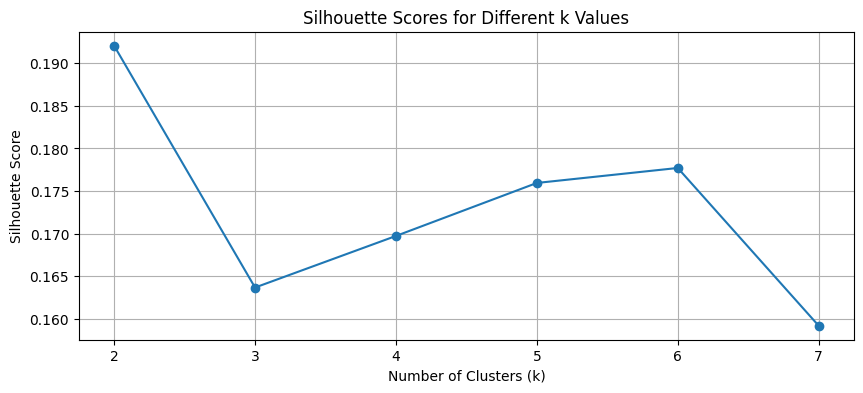

In [26]:
# ÏÇ¨Ïö©Ïûê Îç∞Ïù¥ÌÑ∞ ÏûÖÎ†• ÏòàÏãú
user_data = {
    'HE_sbp1': 130, 'HE_wc': 85, 'HE_HbA1c': 5.8, 'HE_HDL_st2': 55, 'HE_crea': 0.9, 'age': 60,
    'HE_HP': 2.0, 'sex': 1, 'BS1_1': 3, 'BD1_11': 4
}

# Íµ∞Ïßë ÏòàÏ∏° Î∞è Ï†ïÎ≥¥ Ï∂úÎ†•
user_cluster, user_df = predict_user_cluster(user_data)

# Ïã§Î£®Ïó£ Ïä§ÏΩîÏñ¥ ÌîåÎ°Ø ÏÉùÏÑ±
print("\n--- Visualizing Silhouette Scores for k in [2, 3, ..., 10] ---")
plot_silhouette_scores(df_selected, preprocessor)



Í∑∏ÎûòÌîÑ Ï∂îÍ∞Ä

Í≤∞Ï∏°Í∞í ÌôïÏù∏:
 HE_sbp1        335
HE_wc          419
HE_HbA1c       764
HE_HDL_st2     745
HE_crea        745
age              0
HE_HP         1122
sex              0
BS1_1            1
BD1_11           1
dtype: int64

üîπ ÏÇ¨Ïö©ÏûêÍ∞Ä ÏÜçÌïú ÌÅ¥Îü¨Ïä§ÌÑ∞: 0
ÌÅ¥Îü¨Ïä§ÌÑ∞ Ïù¥Î¶Ñ: ÏùÄÎπõ ÌòàÎãπÍµ∞
ÌÅ¥Îü¨Ïä§ÌÑ∞ ÏöîÏïΩ:
Í≥†ÌòàÏïïÍ≥º ÎãπÌôîÌòàÏÉâÏÜåÍ∞Ä ÎÜíÍ≥†, Ïó¨ÏÑ± ÎπÑÏú®Ïù¥ Îß§Ïö∞ ÎÜíÏùÄ Í≥†Î†πÏ∏µ.
ÎÖ∏ÌôîÏôÄ Ìï®Íªò ÎåÄÏÇ¨ Ïù¥ÏÉÅÏù¥ ÏßÑÌñâÎêú Í≥†ÌòàÏïï¬∑ÎãπÎá® ÏúÑÌóòÍµ∞ Ïó¨ÏÑ± Ï§ëÏã¨.


--- Visualizing Silhouette Scores for k in [2, 3, ..., 10] ---
Silhouette Score for k=2: 0.2503
Silhouette Score for k=3: 0.2236
Silhouette Score for k=4: 0.2163
Silhouette Score for k=5: 0.1805
Silhouette Score for k=6: 0.1755
Silhouette Score for k=7: 0.1713


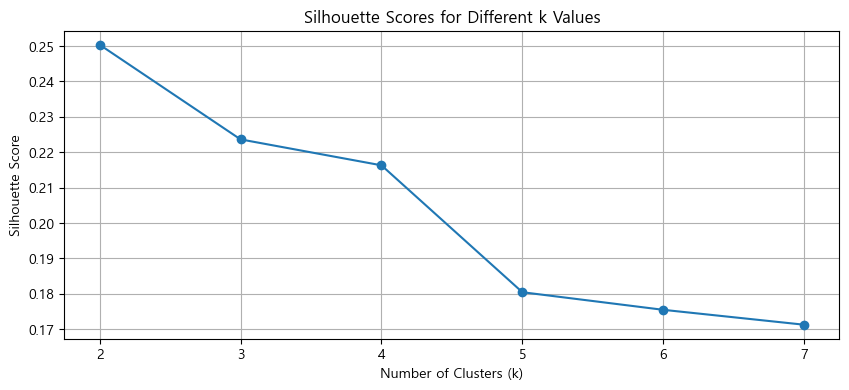


--- Generating Radar Chart ---


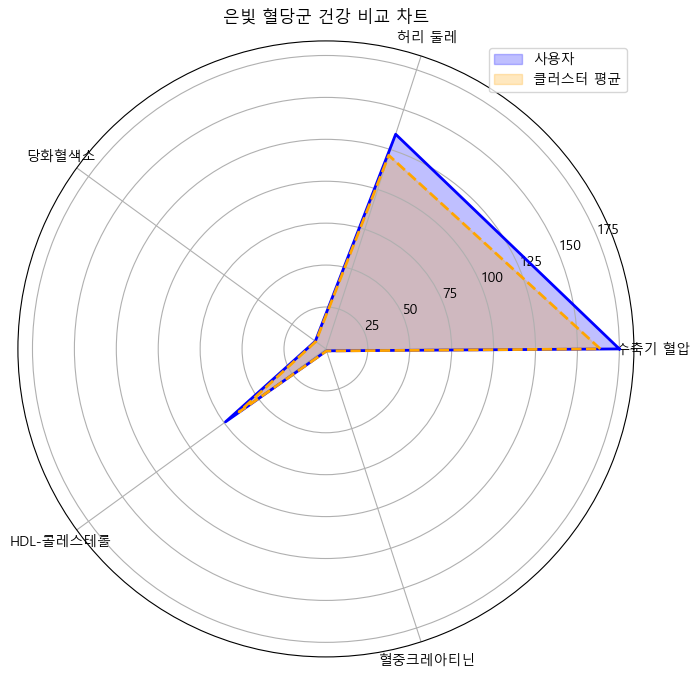

In [37]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi
from sklearn.impute import SimpleImputer

# --- MatplotlibÏóêÏÑú ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ïÏùÑ ÏúÑÌïú ÏΩîÎìú ---
# Ìè∞Ìä∏ ÏÑ§Ï†ï
plt.rcParams['font.family'] = 'Malgun Gothic' # ÏòàÏãú: Windows ÌôòÍ≤ΩÏùò 'ÎßëÏùÄ Í≥†Îîï'
# ÎßåÏïΩ Îã§Î•∏ OSÎ•º ÏÇ¨Ïö©ÌïòÍ±∞ÎÇò Ìï¥Îãπ Ìè∞Ìä∏Í∞Ä ÏóÜÏúºÎ©¥ Îã§Î•∏ ÌïúÍµ≠Ïñ¥ Ìè∞Ìä∏ Ïù¥Î¶ÑÏúºÎ°ú Î≥ÄÍ≤ΩÌï¥Ïïº Ìï©ÎãàÎã§.
# Ïòà: macOSÏùò Í≤ΩÏö∞ 'AppleGothic', LinuxÏùò Í≤ΩÏö∞ 'NanumGothic' Îì±
# Ìè∞Ìä∏ Í≤ΩÎ°úÎ•º ÏßÅÏ†ë ÏßÄÏ†ïÌï† ÏàòÎèÑ ÏûàÏäµÎãàÎã§:
# plt.rcParams['font.family'] = '/path/to/your/korean/font.ttf'

# ÎßàÏù¥ÎÑàÏä§ Î∂ÄÌò∏Í∞Ä Íπ®ÏßÄÎäî Í≤ÉÏùÑ Î∞©ÏßÄ
plt.rcParams['axes.unicode_minus'] = False

# Load the data
# Replace 'ÏÑ†ÌÉùÏª¨Îüº_Í±¥Í∞ïÎç∞Ïù¥ÌÑ∞.csv' with the actual path to your data file
try:
    df = pd.read_csv('ÏÑ†ÌÉùÏª¨Îüº_Í±¥Í∞ïÎç∞Ïù¥ÌÑ∞.csv')
except FileNotFoundError:
    print("Error: 'ÏÑ†ÌÉùÏª¨Îüº_Í±¥Í∞ïÎç∞Ïù¥ÌÑ∞.csv' not found. Please provide the correct file path.")
    exit()


# Features to use for clustering
selected_features = ['HE_sbp1', 'HE_wc', 'HE_HbA1c', 'HE_HDL_st2', 'HE_crea', 'age', 'HE_HP', 'sex', 'BS1_1', 'BD1_11']

# Separate numeric and categorical features
numeric_features = ['HE_sbp1', 'HE_wc', 'HE_HbA1c', 'HE_HDL_st2', 'HE_crea']
categorical_features = ['HE_HP', 'sex', 'BS1_1', 'BD1_11', 'age'] # 'age' is treated as categorical as per your snippet

# Define cluster information and names
cluster_info = {
    0: {
        "name": "ÏùÄÎπõ ÌòàÎãπÍµ∞",
        "summary": "Í≥†ÌòàÏïïÍ≥º ÎãπÌôîÌòàÏÉâÏÜåÍ∞Ä ÎÜíÍ≥†, Ïó¨ÏÑ± ÎπÑÏú®Ïù¥ Îß§Ïö∞ ÎÜíÏùÄ Í≥†Î†πÏ∏µ.\nÎÖ∏ÌôîÏôÄ Ìï®Íªò ÎåÄÏÇ¨ Ïù¥ÏÉÅÏù¥ ÏßÑÌñâÎêú Í≥†ÌòàÏïï¬∑ÎãπÎá® ÏúÑÌóòÍµ∞ Ïó¨ÏÑ± Ï§ëÏã¨."
    },
    1: {
        "name": "Î∂àÌÉÄÎäî Ï≤≠Ï∂òÍµ∞",
        "summary": "Í±¥Í∞ï ÏßÄÌëúÎäî Îß§Ïö∞ Ïö∞ÏàòÌïòÏßÄÎßå, ÏùåÏ£º¬∑Ìù°Ïó∞ Îì± ÏÉùÌôúÏäµÍ¥ÄÏùÄ Îã§ÏÜå Ï¢ãÏßÄ ÏïäÏùå.\nÏ†äÏùÄ Ïó¨ÏÑ± Ï§ëÏã¨ÏúºÎ°ú Í±¥Í∞ïÏùÑ Ïú†ÏßÄ Ï§ëÏù∏ ÏòàÎ∞©Ï†Å Í¥ÄÎ¶¨ ÌïÑÏöîÍµ∞."
    },
    2: {
        "name": "Ïà®ÏùÄ ÏΩ©Ìå•Í≤ΩÎ≥¥Íµ∞",
        "summary": "Ï§ëÎÖÑ ÎÇ®ÏÑ± Ï§ëÏã¨, Í±¥Í∞ï ÏßÄÌëúÎäî ÏïàÏ†ïÏ†ÅÏù¥ÎÇò ÌÅ¨Î†àÏïÑÌã∞Îãå ÏàòÏπòÍ∞Ä ÎÜíÏïÑ Ïã†Ïû• Í∏∞Îä• Ï£ºÏùò ÌïÑÏöî.\nÏÉùÌôúÏäµÍ¥ÄÏùÄ ÏñëÌò∏Ìïú Ìé∏Ïù¥ÏßÄÎßå Ïû†Ïû¨Ï†Å ÏúÑÌóò Ï°¥Ïû¨."
    },
    3: {
        "name": "ÎåÄÏÇ¨ Ìè≠ÌíçÍµ∞",
        "summary": "ÌòàÏïï, ÌòàÎãπ, Î≥µÎ∂ÄÎπÑÎßå Îì± Î™®Îì† ÎåÄÏÇ¨ ÏúÑÌóò ÏöîÏù∏Ïù¥ ÏµúÍ≥†ÏπòÏù∏ Í≥†Î†π ÎÇ®ÏÑ±.\nÎåÄÏÇ¨Ï¶ùÌõÑÍµ∞, Í≥†ÌòàÏïï, ÎãπÎá® Í≥†ÏúÑÌóòÍµ∞."
    }
}

# Create preprocessing pipelines (including missing value handling)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing numeric values with the mean
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing categorical values with the most frequent value
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Keep other columns (if any)
)

# Set up the KMeans model
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)

# Create the full pipeline including preprocessing and clustering
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clusterer', kmeans)
])

# Select the necessary features from the dataframe
df_selected = df[selected_features].copy()

# Check for missing values (for debugging)
print("Í≤∞Ï∏°Í∞í ÌôïÏù∏:\n", df_selected.isna().sum())

# Perform clustering
# The pipeline handles preprocessing and then clustering
df_selected['Cluster'] = pipeline.fit_predict(df_selected)

# Calculate mean values per cluster (for visualization)
# Calculate means for all selected features that are numeric *before* one-hot encoding
# This aligns with the radar chart features which are on their original scale
# Ensure all features needed for the radar chart are included here
radar_chart_features_for_means = list(set(numeric_features))
cluster_means_original_scale = df_selected.groupby('Cluster')[radar_chart_features_for_means].mean()


# Function to predict user cluster
def predict_user_cluster(user_data):
    # Convert user data to a DataFrame
    user_df = pd.DataFrame([user_data], columns=selected_features)

    # Predict the cluster
    user_cluster = pipeline.predict(user_df)[0]

    # Print cluster information
    print(f"\nüîπ ÏÇ¨Ïö©ÏûêÍ∞Ä ÏÜçÌïú ÌÅ¥Îü¨Ïä§ÌÑ∞: {user_cluster}")
    print(f"ÌÅ¥Îü¨Ïä§ÌÑ∞ Ïù¥Î¶Ñ: {cluster_info[user_cluster]['name']}")
    print(f"ÌÅ¥Îü¨Ïä§ÌÑ∞ ÏöîÏïΩ:\n{cluster_info[user_cluster]['summary']}\n")

    return user_cluster, user_df

# Function to generate silhouette score plot (k=2~8)
def plot_silhouette_scores(df_selected, preprocessor):
    silhouette_scores = []
    k_range = range(2, 8)

    # Apply preprocessing before calculating silhouette scores
    X_processed = preprocessor.fit_transform(df_selected)

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        pipeline_temp = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('clusterer', kmeans)
        ])
        labels = pipeline_temp.fit_predict(df_selected)
        score = silhouette_score(preprocessor.fit_transform(df_selected), labels)
        silhouette_scores.append(score)
        print(f"Silhouette Score for k={k}: {score:.4f}")

    # Create the plot
    plt.figure(figsize=(10, 4))
    plt.plot(k_range, silhouette_scores, marker='o')
    plt.title('Silhouette Scores for Different k Values')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.grid(True)
    plt.show()

# Function to generate radar chart comparing user data to cluster average
def plot_radar_chart(user_data, cluster_means_df, user_cluster):
    # Features and labels for the radar chart (matching the image order)
    # Note: Ensure these features are present in your user_data and cluster_means_df
    radar_features = ['HE_sbp1', 'HE_wc', 'HE_HbA1c', 'HE_HDL_st2', 'HE_crea'] 
    radar_labels = ['ÏàòÏ∂ïÍ∏∞ ÌòàÏïï','ÌóàÎ¶¨ ÎëòÎ†à', 'ÎãπÌôîÌòàÏÉâÏÜå', 'HDL-ÏΩúÎ†àÏä§ÌÖåÎ°§', 'ÌòàÏ§ëÌÅ¨Î†àÏïÑÌã∞Îãå']

    # Extract user values for radar features
    user_values = np.array([user_data.get(feature) for feature in radar_features])

    # Extract cluster average values for radar features
    # Ensure cluster_means_df has the radar_features columns
    if not all(feature in cluster_means_df.columns for feature in radar_features):
        print("Error: Cluster means DataFrame is missing some radar features for plotting.")
        print("Missing features:", [feature for feature in radar_features if feature not in cluster_means_df.columns])
        return

    cluster_avg_values = cluster_means_df.loc[user_cluster, radar_features].values

    # Apply the specific normalization (scaling to 0-175 based on max value)
    # Combine user and cluster values to find the overall max for normalization
    all_values = np.concatenate([user_values, cluster_avg_values])
    max_value = np.nanmax(all_values) # Use nanmax to handle potential NaNs

    # Handle case where max_value is 0 or NaN to avoid division by zero or errors
    if np.isnan(max_value) or max_value == 0:
         user_values_normalized = np.zeros_like(user_values)
         cluster_avg_values_normalized = np.zeros_like(cluster_avg_values)
    else:
        user_values_normalized = (user_values / max_value) * 175
        cluster_avg_values_normalized = (cluster_avg_values / max_value) * 175


    # Radar Chart Generation (in Korean)
    num_vars = len(radar_features)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    # Complete the circle for plotting
    user_values_normalized = np.concatenate((user_values_normalized, [user_values_normalized[0]]))
    cluster_avg_values_normalized = np.concatenate((cluster_avg_values_normalized, [cluster_avg_values_normalized[0]]))
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    ax.fill(angles, user_values_normalized, color='blue', alpha=0.25, label='ÏÇ¨Ïö©Ïûê')
    ax.plot(angles, user_values_normalized, color='blue', linewidth=2)
    ax.fill(angles, cluster_avg_values_normalized, color='orange', alpha=0.25, label='ÌÅ¥Îü¨Ïä§ÌÑ∞ ÌèâÍ∑†')
    ax.plot(angles, cluster_avg_values_normalized, color='orange', linewidth=2, linestyle='--')

    # Set y-ticks based on the normalization scale
    ax.set_yticks([25, 50, 75, 100, 125, 150, 175])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(radar_labels) # Use Korean labels
    #plt.title(f'ÌÅ¥Îü¨Ïä§ÌÑ∞ {int(user_cluster)} Í±¥Í∞ï ÎπÑÍµê Ï∞®Ìä∏') 
    plt.title(f"{cluster_info[user_cluster]['name']} Í±¥Í∞ï ÎπÑÍµê Ï∞®Ìä∏" )
    plt.legend(loc='upper right')
    plt.show()


# --- Example Usage ---

# ÏÇ¨Ïö©Ïûê Îç∞Ïù¥ÌÑ∞ ÏûÖÎ†• ÏòàÏãú
# Ensure all features used in selected_features and radar_features are included
user_data = {
    'HE_sbp1': 130, 'HE_wc': 100, 'HE_HbA1c': 5.8, 'HE_HDL_st2': 55, 'HE_crea': 0.9, 'age': 30,
    'HE_HP': 2.0, 'sex': 1, 'BS1_1': 3, 'BD1_11': 4,
}

# Íµ∞Ïßë ÏòàÏ∏° Î∞è Ï†ïÎ≥¥ Ï∂úÎ†•
user_cluster, user_df = predict_user_cluster(user_data)

# Ïã§Î£®Ïó£ Ïä§ÏΩîÏñ¥ ÌîåÎ°Ø ÏÉùÏÑ±
print("\n--- Visualizing Silhouette Scores for k in [2, 3, ..., 10] ---")
plot_silhouette_scores(df_selected, preprocessor)

# Î†àÏù¥Îçî Ï∞®Ìä∏ ÏÉùÏÑ±
print("\n--- Generating Radar Chart ---")
# Pass the user_data dictionary and the cluster_means_original_scale DataFrame
plot_radar_chart(user_data, cluster_means_original_scale, user_cluster)


Í∑∏ÎûòÌîÑ Ïä§ÏºÄÏùºÎßÅ

Í≤∞Ï∏°Í∞í ÌôïÏù∏:
 HE_sbp1        335
HE_wc          419
HE_HbA1c       764
HE_HDL_st2     745
HE_crea        745
age              0
HE_HP         1122
sex              0
BS1_1            1
BD1_11           1
dtype: int64

üîπ ÏÇ¨Ïö©ÏûêÍ∞Ä ÏÜçÌïú ÌÅ¥Îü¨Ïä§ÌÑ∞: 0
ÌÅ¥Îü¨Ïä§ÌÑ∞ Ïù¥Î¶Ñ: ÏùÄÎπõ ÌòàÎãπÍµ∞
ÌÅ¥Îü¨Ïä§ÌÑ∞ ÏöîÏïΩ:
Í≥†ÌòàÏïïÍ≥º ÎãπÌôîÌòàÏÉâÏÜåÍ∞Ä ÎÜíÍ≥†, Ïó¨ÏÑ± ÎπÑÏú®Ïù¥ Îß§Ïö∞ ÎÜíÏùÄ Í≥†Î†πÏ∏µ.
ÎÖ∏ÌôîÏôÄ Ìï®Íªò ÎåÄÏÇ¨ Ïù¥ÏÉÅÏù¥ ÏßÑÌñâÎêú Í≥†ÌòàÏïï¬∑ÎãπÎá® ÏúÑÌóòÍµ∞ Ïó¨ÏÑ± Ï§ëÏã¨.


--- Visualizing Silhouette Scores for k in [2, 3, ..., 10] ---
Silhouette Score for k=2: 0.2503
Silhouette Score for k=3: 0.2236
Silhouette Score for k=4: 0.2163
Silhouette Score for k=5: 0.1805
Silhouette Score for k=6: 0.1755
Silhouette Score for k=7: 0.1713


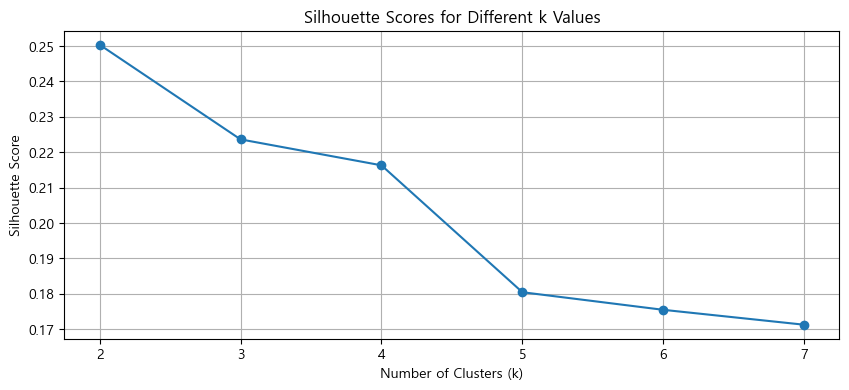


--- Generating Radar Chart ---


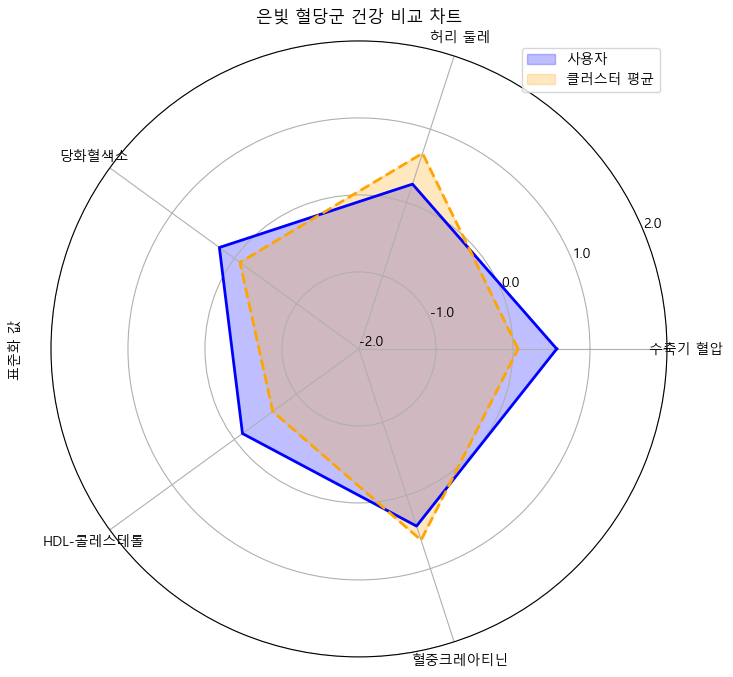

In [39]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi
from sklearn.impute import SimpleImputer

# --- MatplotlibÏóêÏÑú ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ïÏùÑ ÏúÑÌïú ÏΩîÎìú ---
# Ìè∞Ìä∏ ÏÑ§Ï†ï
plt.rcParams['font.family'] = 'Malgun Gothic' # ÏòàÏãú: Windows ÌôòÍ≤ΩÏùò 'ÎßëÏùÄ Í≥†Îîï'
# ÎßåÏïΩ Îã§Î•∏ OSÎ•º ÏÇ¨Ïö©ÌïòÍ±∞ÎÇò Ìï¥Îãπ Ìè∞Ìä∏Í∞Ä ÏóÜÏúºÎ©¥ Îã§Î•∏ ÌïúÍµ≠Ïñ¥ Ìè∞Ìä∏ Ïù¥Î¶ÑÏúºÎ°ú Î≥ÄÍ≤ΩÌï¥Ïïº Ìï©ÎãàÎã§.
# Ïòà: macOSÏùò Í≤ΩÏö∞ 'AppleGothic', LinuxÏùò Í≤ΩÏö∞ 'NanumGothic' Îì±
# Ìè∞Ìä∏ Í≤ΩÎ°úÎ•º ÏßÅÏ†ë ÏßÄÏ†ïÌï† ÏàòÎèÑ ÏûàÏäµÎãàÎã§:
# plt.rcParams['font.family'] = '/path/to/your/korean/font.ttf'

# ÎßàÏù¥ÎÑàÏä§ Î∂ÄÌò∏Í∞Ä Íπ®ÏßÄÎäî Í≤ÉÏùÑ Î∞©ÏßÄ
plt.rcParams['axes.unicode_minus'] = False
# -------------------------------------------------


# Load the data
# Replace 'ÏÑ†ÌÉùÏª¨Îüº_Í±¥Í∞ïÎç∞Ïù¥ÌÑ∞.csv' with the actual path to your data file
try:
    df = pd.read_csv('ÏÑ†ÌÉùÏª¨Îüº_Í±¥Í∞ïÎç∞Ïù¥ÌÑ∞.csv')
except FileNotFoundError:
    print("Error: 'ÏÑ†ÌÉùÏª¨Îüº_Í±¥Í∞ïÎç∞Ïù¥ÌÑ∞.csv' not found. Please provide the correct file path.")
    exit()


# Features to use for clustering
selected_features = ['HE_sbp1', 'HE_wc', 'HE_HbA1c', 'HE_HDL_st2', 'HE_crea', 'age', 'HE_HP', 'sex', 'BS1_1', 'BD1_11']

# Separate numeric and categorical features
numeric_features = ['HE_sbp1', 'HE_wc', 'HE_HbA1c', 'HE_HDL_st2', 'HE_crea']
categorical_features = ['HE_HP', 'sex', 'BS1_1', 'BD1_11', 'age'] # 'age' is treated as categorical as per your snippet

# Define cluster information and names
cluster_info = {
    0: {
        "name": "ÏùÄÎπõ ÌòàÎãπÍµ∞",
        "summary": "Í≥†ÌòàÏïïÍ≥º ÎãπÌôîÌòàÏÉâÏÜåÍ∞Ä ÎÜíÍ≥†, Ïó¨ÏÑ± ÎπÑÏú®Ïù¥ Îß§Ïö∞ ÎÜíÏùÄ Í≥†Î†πÏ∏µ.\nÎÖ∏ÌôîÏôÄ Ìï®Íªò ÎåÄÏÇ¨ Ïù¥ÏÉÅÏù¥ ÏßÑÌñâÎêú Í≥†ÌòàÏïï¬∑ÎãπÎá® ÏúÑÌóòÍµ∞ Ïó¨ÏÑ± Ï§ëÏã¨."
    },
    1: {
        "name": "Î∂àÌÉÄÎäî Ï≤≠Ï∂òÍµ∞",
        "summary": "Í±¥Í∞ï ÏßÄÌëúÎäî Îß§Ïö∞ Ïö∞ÏàòÌïòÏßÄÎßå, ÏùåÏ£º¬∑Ìù°Ïó∞ Îì± ÏÉùÌôúÏäµÍ¥ÄÏùÄ Îã§ÏÜå Ï¢ãÏßÄ ÏïäÏùå.\nÏ†äÏùÄ Ïó¨ÏÑ± Ï§ëÏã¨ÏúºÎ°ú Í±¥Í∞ïÏùÑ Ïú†ÏßÄ Ï§ëÏù∏ ÏòàÎ∞©Ï†Å Í¥ÄÎ¶¨ ÌïÑÏöîÍµ∞."
    },
    2: {
        "name": "Ïà®ÏùÄ ÏΩ©Ìå•Í≤ΩÎ≥¥Íµ∞",
        "summary": "Ï§ëÎÖÑ ÎÇ®ÏÑ± Ï§ëÏã¨, Í±¥Í∞ï ÏßÄÌëúÎäî ÏïàÏ†ïÏ†ÅÏù¥ÎÇò ÌÅ¨Î†àÏïÑÌã∞Îãå ÏàòÏπòÍ∞Ä ÎÜíÏïÑ Ïã†Ïû• Í∏∞Îä• Ï£ºÏùò ÌïÑÏöî.\nÏÉùÌôúÏäµÍ¥ÄÏùÄ ÏñëÌò∏Ìïú Ìé∏Ïù¥ÏßÄÎßå Ïû†Ïû¨Ï†Å ÏúÑÌóò Ï°¥Ïû¨."
    },
    3: {
        "name": "ÎåÄÏÇ¨ Ìè≠ÌíçÍµ∞",
        "summary": "ÌòàÏïï, ÌòàÎãπ, Î≥µÎ∂ÄÎπÑÎßå Îì± Î™®Îì† ÎåÄÏÇ¨ ÏúÑÌóò ÏöîÏù∏Ïù¥ ÏµúÍ≥†ÏπòÏù∏ Í≥†Î†π ÎÇ®ÏÑ±.\nÎåÄÏÇ¨Ï¶ùÌõÑÍµ∞, Í≥†ÌòàÏïï, ÎãπÎá® Í≥†ÏúÑÌóòÍµ∞."
    }
}

# Create preprocessing pipelines (including missing value handling)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing numeric values with the mean
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing categorical values with the most frequent value
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Keep other columns (if any)
)

# Set up the KMeans model
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)

# Create the full pipeline including preprocessing and clustering
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clusterer', kmeans)
])

# Select the necessary features from the dataframe
df_selected = df[selected_features].copy()

# Check for missing values (for debugging)
print("Í≤∞Ï∏°Í∞í ÌôïÏù∏:\n", df_selected.isna().sum())

# Perform clustering
# The pipeline handles preprocessing and then clustering
df_selected['Cluster'] = pipeline.fit_predict(df_selected)

# Calculate mean values per cluster (for visualization)
# Calculate means for all selected features that are numeric *before* one-hot encoding
# This aligns with the radar chart features which are on their original scale
# Ensure all features needed for the radar chart are included here
radar_chart_features_for_means = list(set(numeric_features + ['HE_TG', 'HE_LDL_drct', 'HE_chol', 'HE_ast', 'HE_alt', 'HE_wc', 'HE_HDL_st2']))
# Filter out features that are not in the original DataFrame
radar_chart_features_for_means = [feat for feat in radar_chart_features_for_means if feat in df_selected.columns]

cluster_means_original_scale = df_selected.groupby('Cluster')[radar_chart_features_for_means].mean()


# Function to predict user cluster
def predict_user_cluster(user_data):
    # Convert user data to a DataFrame
    user_df = pd.DataFrame([user_data], columns=selected_features)

    # Predict the cluster
    user_cluster = pipeline.predict(user_df)[0]

    # Print cluster information
    print(f"\nüîπ ÏÇ¨Ïö©ÏûêÍ∞Ä ÏÜçÌïú ÌÅ¥Îü¨Ïä§ÌÑ∞: {user_cluster}")
    print(f"ÌÅ¥Îü¨Ïä§ÌÑ∞ Ïù¥Î¶Ñ: {cluster_info[user_cluster]['name']}")
    print(f"ÌÅ¥Îü¨Ïä§ÌÑ∞ ÏöîÏïΩ:\n{cluster_info[user_cluster]['summary']}\n")

    return user_cluster, user_df

# Function to generate silhouette score plot (k=2~8)
def plot_silhouette_scores(df_selected, preprocessor):
    silhouette_scores = []
    k_range = range(2, 8)

    # Apply preprocessing before calculating silhouette scores
    X_processed = preprocessor.fit_transform(df_selected)

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        pipeline_temp = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('clusterer', kmeans)
        ])
        labels = pipeline_temp.fit_predict(df_selected)
        score = silhouette_score(preprocessor.fit_transform(df_selected), labels)
        silhouette_scores.append(score)
        print(f"Silhouette Score for k={k}: {score:.4f}")

    # Create the plot
    plt.figure(figsize=(10, 4))
    plt.plot(k_range, silhouette_scores, marker='o')
    plt.title('Silhouette Scores for Different k Values')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.grid(True)
    plt.show()

# Function to generate radar chart comparing user data to cluster average
def plot_radar_chart(user_data, cluster_means_df, user_cluster, df_for_scaler):
    # Features and labels for the radar chart
    # Using the features and labels provided in your latest request
    radar_features = ['HE_sbp1', 'HE_wc', 'HE_HbA1c', 'HE_HDL_st2', 'HE_crea']
    radar_labels = ['ÏàòÏ∂ïÍ∏∞ ÌòàÏïï','ÌóàÎ¶¨ ÎëòÎ†à', 'ÎãπÌôîÌòàÏÉâÏÜå', 'HDL-ÏΩúÎ†àÏä§ÌÖåÎ°§', 'ÌòàÏ§ëÌÅ¨Î†àÏïÑÌã∞Îãå']

    # Extract user values for radar features into a DataFrame
    # Use .get() with a default of NaN to handle missing features gracefully
    user_df_radar = pd.DataFrame([{feature: user_data.get(feature, np.nan) for feature in radar_features}])

    # Extract cluster average values for radar features into a DataFrame row
    if not all(feature in cluster_means_df.columns for feature in radar_features):
        print("Error: Cluster means DataFrame is missing some radar features for plotting.")
        print("Missing features:", [feature for feature in radar_features if feature not in cluster_means_df.columns])
        return
    cluster_avg_df_radar = pd.DataFrame([cluster_means_df.loc[user_cluster, radar_features].values], columns=radar_features)

    # --- Per-feature Normalization using StandardScaler ---
    # Fit a new scaler specifically on the radar features from the main dataset
    # This ensures scaling is based on the distribution of these features in the data
    scaler_radar = StandardScaler()
    # Fit the scaler on the relevant columns from the original data used for clustering
    scaler_radar.fit(df_for_scaler[radar_features])

    # Transform user data and cluster average data using this new scaler
    # .transform returns a numpy array, [0] is used to get the single row
    user_values_scaled = scaler_radar.transform(user_df_radar)[0]
    cluster_avg_values_scaled = scaler_radar.transform(cluster_avg_df_radar)[0]
    # --- End of Normalization ---


    # Radar Chart Generation (in Korean)
    num_vars = len(radar_features)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    # Complete the circle for plotting by repeating the first value
    user_values_scaled = np.concatenate((user_values_scaled, [user_values_scaled[0]]))
    cluster_avg_values_scaled = np.concatenate((cluster_avg_values_scaled, [cluster_avg_values_scaled[0]]))
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    # Plot data
    ax.fill(angles, user_values_scaled, color='blue', alpha=0.25, label='ÏÇ¨Ïö©Ïûê')
    ax.plot(angles, user_values_scaled, color='blue', linewidth=2)
    ax.fill(angles, cluster_avg_values_scaled, color='orange', alpha=0.25, label='ÌÅ¥Îü¨Ïä§ÌÑ∞ ÌèâÍ∑†')
    ax.plot(angles, cluster_avg_values_scaled, color='orange', linewidth=2, linestyle='--')

    # Set y-ticks based on the scaled values (StandardScaler results in mean ~0, std dev ~1)
    # We can set ticks at standard deviation intervals, e.g., -2, 0, 2
    # Determine a reasonable range based on the scaled data
    all_scaled_values = np.concatenate([user_values_scaled[:-1], cluster_avg_values_scaled[:-1]])
    min_scaled = np.nanmin(all_scaled_values)
    max_scaled = np.nanmax(all_scaled_values)

    # Set y-ticks to cover the range, e.g., from min_scaled to max_scaled with a few steps
    # Or use fixed steps like -2, 0, 2 if the scaling is expected to be around that range
    # Let's use a simple approach with a few ticks within a reasonable range for standard scaled data
    y_ticks = np.linspace(min(min_scaled, -2), max(max_scaled, 2), 5) # Example ticks
    ax.set_yticks(y_ticks)
    ax.set_yticklabels([f'{tick:.1f}' for tick in y_ticks]) # Format ticks to one decimal place
    ax.set_ylabel("ÌëúÏ§ÄÌôî Í∞í", labelpad=20) # Add a label for the y-axis (scaled value)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(radar_labels) # Use Korean labels for features

    # Use the cluster name for the title as requested
    plt.title(f"{cluster_info[user_cluster]['name']} Í±¥Í∞ï ÎπÑÍµê Ï∞®Ìä∏" )
    plt.legend(loc='upper right')
    plt.show()


# --- Example Usage ---

# ÏÇ¨Ïö©Ïûê Îç∞Ïù¥ÌÑ∞ ÏûÖÎ†• ÏòàÏãú
# Ensure all features used in selected_features and radar_features are included
user_data = {
    'HE_sbp1': 130, 'HE_wc': 85, 'HE_HbA1c': 5.8, 'HE_HDL_st2': 55, 'HE_crea': 0.9, 'age': 60,
    'HE_HP': 2.0, 'sex': 1, 'BS1_1': 3, 'BD1_11': 4
}

# Íµ∞Ïßë ÏòàÏ∏° Î∞è Ï†ïÎ≥¥ Ï∂úÎ†•
user_cluster, user_df = predict_user_cluster(user_data)

# Ïã§Î£®Ïó£ Ïä§ÏΩîÏñ¥ ÌîåÎ°Ø ÏÉùÏÑ±
print("\n--- Visualizing Silhouette Scores for k in [2, 3, ..., 10] ---")
plot_silhouette_scores(df_selected, preprocessor)

# Î†àÏù¥Îçî Ï∞®Ìä∏ ÏÉùÏÑ±
print("\n--- Generating Radar Chart ---")
# Pass the user_data dictionary, the cluster_means_original_scale DataFrame,
# the user_cluster, and the df_selected (to fit the scaler)
plot_radar_chart(user_data, cluster_means_original_scale, user_cluster, df_selected)


ÏµúÏ¢Ö

ÌÅ¥Îü¨Ïä§ÌÑ∞ Ïù¥Î¶Ñ: ÎåÄÏÇ¨ Ìè≠ÌíçÍµ∞
ÌÅ¥Îü¨Ïä§ÌÑ∞ ÏöîÏïΩ:
ÌòàÏïï, ÌòàÎãπ, Î≥µÎ∂ÄÎπÑÎßå Îì± Î™®Îì† ÎåÄÏÇ¨ ÏúÑÌóò ÏöîÏù∏Ïù¥ ÏµúÍ≥†ÏπòÏù∏ Í≥†Î†π ÎÇ®ÏÑ±Ï∏µ.
ÎåÄÏÇ¨Ï¶ùÌõÑÍµ∞, Í≥†ÌòàÏïï, ÎãπÎá® Í≥†ÏúÑÌóòÍµ∞.


--- Generating Radar Chart ---


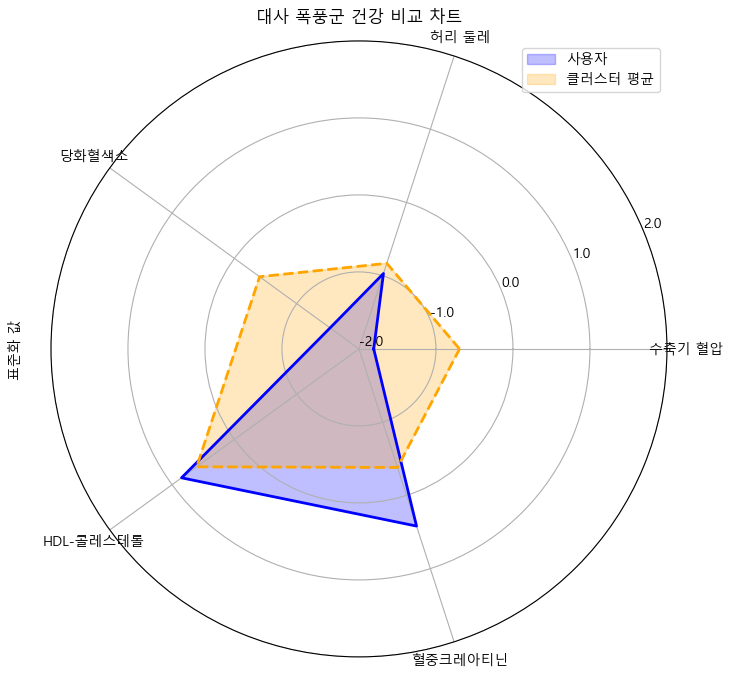

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi
from sklearn.impute import SimpleImputer

# --- MatplotlibÏóêÏÑú ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ïÏùÑ ÏúÑÌïú ÏΩîÎìú ---
# Ìè∞Ìä∏ ÏÑ§Ï†ï
plt.rcParams['font.family'] = 'Malgun Gothic' # ÏòàÏãú: Windows ÌôòÍ≤ΩÏùò 'ÎßëÏùÄ Í≥†Îîï'
# ÎßåÏïΩ Îã§Î•∏ OSÎ•º ÏÇ¨Ïö©ÌïòÍ±∞ÎÇò Ìï¥Îãπ Ìè∞Ìä∏Í∞Ä ÏóÜÏúºÎ©¥ Îã§Î•∏ ÌïúÍµ≠Ïñ¥ Ìè∞Ìä∏ Ïù¥Î¶ÑÏúºÎ°ú Î≥ÄÍ≤ΩÌï¥Ïïº Ìï©ÎãàÎã§.
# Ïòà: macOSÏùò Í≤ΩÏö∞ 'AppleGothic', LinuxÏùò Í≤ΩÏö∞ 'NanumGothic' Îì±
# Ìè∞Ìä∏ Í≤ΩÎ°úÎ•º ÏßÅÏ†ë ÏßÄÏ†ïÌï† ÏàòÎèÑ ÏûàÏäµÎãàÎã§:
# plt.rcParams['font.family'] = '/path/to/your/korean/font.ttf'

# ÎßàÏù¥ÎÑàÏä§ Î∂ÄÌò∏Í∞Ä Íπ®ÏßÄÎäî Í≤ÉÏùÑ Î∞©ÏßÄ
plt.rcParams['axes.unicode_minus'] = False
# -------------------------------------------------


# Load the data
# Replace 'ÏÑ†ÌÉùÏª¨Îüº_Í±¥Í∞ïÎç∞Ïù¥ÌÑ∞.csv' with the actual path to your data file
try:
    df = pd.read_csv('ÏÑ†ÌÉùÏª¨Îüº_Í±¥Í∞ïÎç∞Ïù¥ÌÑ∞.csv')
except FileNotFoundError:
    print("Error: 'ÏÑ†ÌÉùÏª¨Îüº_Í±¥Í∞ïÎç∞Ïù¥ÌÑ∞.csv' not found. Please provide the correct file path.")
    exit()


# Features to use for clustering
selected_features = ['HE_sbp1', 'HE_wc', 'HE_HbA1c', 'HE_HDL_st2', 'HE_crea', 'age', 'HE_HP', 'sex', 'BS1_1', 'BD1_11']

# Separate numeric and categorical features
numeric_features = ['HE_sbp1', 'HE_wc', 'HE_HbA1c', 'HE_HDL_st2', 'HE_crea']
categorical_features = ['HE_HP', 'sex', 'BS1_1', 'BD1_11', 'age'] # 'age' is treated as categorical as per your snippet

# Define cluster information and names
cluster_info = {
    0: {
        "name": "ÏùÄÎπõ ÌòàÎãπÍµ∞",
        "summary": "Í≥†ÌòàÏïïÍ≥º ÎãπÌôîÌòàÏÉâÏÜåÍ∞Ä ÎÜíÍ≥†, Ïó¨ÏÑ± ÎπÑÏú®Ïù¥ Îß§Ïö∞ ÎÜíÏùÄ Í≥†Î†πÏ∏µ.\nÎÖ∏ÌôîÏôÄ Ìï®Íªò ÎåÄÏÇ¨ Ïù¥ÏÉÅÏù¥ ÏßÑÌñâÎêú Í≥†ÌòàÏïï¬∑ÎãπÎá® ÏúÑÌóòÍµ∞"
    },
    1: {
        "name": "Î∂àÌÉÄÎäî Ï≤≠Ï∂òÍµ∞",
        "summary": "Í±¥Í∞ï ÏßÄÌëúÎäî Îß§Ïö∞ Ïö∞ÏàòÌïòÏßÄÎßå, ÏùåÏ£º¬∑Ìù°Ïó∞ Îì± ÏÉùÌôúÏäµÍ¥ÄÏùÄ Îã§ÏÜå Ï¢ãÏßÄ ÏïäÏùå.\nÏ†äÏùÄ Ïó¨ÏÑ± Ï§ëÏã¨ÏúºÎ°ú Í±¥Í∞ïÏùÑ Ïú†ÏßÄ Ï§ëÏù∏ ÏòàÎ∞©Ï†Å Í¥ÄÎ¶¨ ÌïÑÏöîÍµ∞."
    },
    2: {
        "name": "Ïà®ÏùÄ ÏΩ©Ìå•Í≤ΩÎ≥¥Íµ∞",
        "summary": "Ï§ëÎÖÑ ÎÇ®ÏÑ± Ï§ëÏã¨, Í±¥Í∞ï ÏßÄÌëúÎäî ÏïàÏ†ïÏ†ÅÏù¥ÎÇò ÌÅ¨Î†àÏïÑÌã∞Îãå ÏàòÏπòÍ∞Ä ÎÜíÏïÑ Ïã†Ïû• Í∏∞Îä• Ï£ºÏùò ÌïÑÏöî.\nÏÉùÌôúÏäµÍ¥ÄÏùÄ ÏñëÌò∏Ìïú Ìé∏Ïù¥ÏßÄÎßå Ïû†Ïû¨Ï†Å ÏúÑÌóò Ï°¥Ïû¨."
    },
    3: {
        "name": "ÎåÄÏÇ¨ Ìè≠ÌíçÍµ∞",
        "summary": "ÌòàÏïï, ÌòàÎãπ, Î≥µÎ∂ÄÎπÑÎßå Îì± Î™®Îì† ÎåÄÏÇ¨ ÏúÑÌóò ÏöîÏù∏Ïù¥ ÏµúÍ≥†ÏπòÏù∏ Í≥†Î†π ÎÇ®ÏÑ±Ï∏µ.\nÎåÄÏÇ¨Ï¶ùÌõÑÍµ∞, Í≥†ÌòàÏïï, ÎãπÎá® Í≥†ÏúÑÌóòÍµ∞."
    }
}

# Create preprocessing pipelines (including missing value handling)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing numeric values with the mean
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing categorical values with the most frequent value
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Keep other columns (if any)
)

# Set up the KMeans model
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)

# Create the full pipeline including preprocessing and clustering
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clusterer', kmeans)
])

# Select the necessary features from the dataframe
df_selected = df[selected_features].copy()

# Check for missing values (for debugging)
#print("Í≤∞Ï∏°Í∞í ÌôïÏù∏:\n", df_selected.isna().sum())

# Perform clustering
# The pipeline handles preprocessing and then clustering
df_selected['Cluster'] = pipeline.fit_predict(df_selected)

# Calculate mean values per cluster (for visualization)
# Calculate means for all selected features that are numeric *before* one-hot encoding
# This aligns with the radar chart features which are on their original scale
# Ensure all features needed for the radar chart are included here
radar_chart_features_for_means = list(set(numeric_features + ['HE_TG', 'HE_LDL_drct', 'HE_chol', 'HE_ast', 'HE_alt', 'HE_wc', 'HE_HDL_st2']))
# Filter out features that are not in the original DataFrame
radar_chart_features_for_means = [feat for feat in radar_chart_features_for_means if feat in df_selected.columns]

cluster_means_original_scale = df_selected.groupby('Cluster')[radar_chart_features_for_means].mean()


# Function to predict user cluster
def predict_user_cluster(user_data):
    # Convert user data to a DataFrame
    user_df = pd.DataFrame([user_data], columns=selected_features)

    # Predict the cluster
    user_cluster = pipeline.predict(user_df)[0]

    # Print cluster information
    #print(f"\nüîπ ÏÇ¨Ïö©ÏûêÍ∞Ä ÏÜçÌïú ÌÅ¥Îü¨Ïä§ÌÑ∞: {user_cluster}")
    print(f"ÌÅ¥Îü¨Ïä§ÌÑ∞ Ïù¥Î¶Ñ: {cluster_info[user_cluster]['name']}")
    print(f"ÌÅ¥Îü¨Ïä§ÌÑ∞ ÏöîÏïΩ:\n{cluster_info[user_cluster]['summary']}\n")

    return user_cluster, user_df

# Function to generate silhouette score plot (k=2~8)
def plot_silhouette_scores(df_selected, preprocessor):
    silhouette_scores = []
    k_range = range(2, 8)

    # Apply preprocessing before calculating silhouette scores
    X_processed = preprocessor.fit_transform(df_selected)

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        pipeline_temp = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('clusterer', kmeans)
        ])
        labels = pipeline_temp.fit_predict(df_selected)
        score = silhouette_score(preprocessor.fit_transform(df_selected), labels)
        silhouette_scores.append(score)
        print(f"Silhouette Score for k={k}: {score:.4f}")

    # Create the plot
    plt.figure(figsize=(10, 4))
    plt.plot(k_range, silhouette_scores, marker='o')
    plt.title('Silhouette Scores for Different k Values')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.grid(True)
    plt.show()

# Function to generate radar chart comparing user data to cluster average
def plot_radar_chart(user_data, cluster_means_df, user_cluster, df_for_scaler):
    # Features and labels for the radar chart
    # Using the features and labels provided in your latest request
    radar_features = ['HE_sbp1', 'HE_wc', 'HE_HbA1c', 'HE_HDL_st2', 'HE_crea']
    radar_labels = ['ÏàòÏ∂ïÍ∏∞ ÌòàÏïï','ÌóàÎ¶¨ ÎëòÎ†à', 'ÎãπÌôîÌòàÏÉâÏÜå', 'HDL-ÏΩúÎ†àÏä§ÌÖåÎ°§', 'ÌòàÏ§ëÌÅ¨Î†àÏïÑÌã∞Îãå']

    # Extract user values for radar features into a DataFrame
    # Use .get() with a default of NaN to handle missing features gracefully
    user_df_radar = pd.DataFrame([{feature: user_data.get(feature, np.nan) for feature in radar_features}])

    # Extract cluster average values for radar features into a DataFrame row
    if not all(feature in cluster_means_df.columns for feature in radar_features):
        print("Error: Cluster means DataFrame is missing some radar features for plotting.")
        print("Missing features:", [feature for feature in radar_features if feature not in cluster_means_df.columns])
        return
    cluster_avg_df_radar = pd.DataFrame([cluster_means_df.loc[user_cluster, radar_features].values], columns=radar_features)

    # --- Per-feature Normalization using StandardScaler ---
    # Fit a new scaler specifically on the radar features from the main dataset
    # This ensures scaling is based on the distribution of these features in the data
    scaler_radar = StandardScaler()
    # Fit the scaler on the relevant columns from the original data used for clustering
    scaler_radar.fit(df_for_scaler[radar_features])

    # Transform user data and cluster average data using this new scaler
    # .transform returns a numpy array, [0] is used to get the single row
    user_values_scaled = scaler_radar.transform(user_df_radar)[0]
    cluster_avg_values_scaled = scaler_radar.transform(cluster_avg_df_radar)[0]
    # --- End of Normalization ---


    # Radar Chart Generation (in Korean)
    num_vars = len(radar_features)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    # Complete the circle for plotting by repeating the first value
    user_values_scaled = np.concatenate((user_values_scaled, [user_values_scaled[0]]))
    cluster_avg_values_scaled = np.concatenate((cluster_avg_values_scaled, [cluster_avg_values_scaled[0]]))
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    # Plot data
    ax.fill(angles, user_values_scaled, color='blue', alpha=0.25, label='ÏÇ¨Ïö©Ïûê')
    ax.plot(angles, user_values_scaled, color='blue', linewidth=2)
    ax.fill(angles, cluster_avg_values_scaled, color='orange', alpha=0.25, label='ÌÅ¥Îü¨Ïä§ÌÑ∞ ÌèâÍ∑†')
    ax.plot(angles, cluster_avg_values_scaled, color='orange', linewidth=2, linestyle='--')

    # Set y-ticks based on the scaled values (StandardScaler results in mean ~0, std dev ~1)
    # We can set ticks at standard deviation intervals, e.g., -2, 0, 2
    # Determine a reasonable range based on the scaled data
    all_scaled_values = np.concatenate([user_values_scaled[:-1], cluster_avg_values_scaled[:-1]])
    min_scaled = np.nanmin(all_scaled_values)
    max_scaled = np.nanmax(all_scaled_values)

    # Set y-ticks to cover the range, e.g., from min_scaled to max_scaled with a few steps
    # Or use fixed steps like -2, 0, 2 if the scaling is expected to be around that range
    # Let's use a simple approach with a few ticks within a reasonable range for standard scaled data
    y_ticks = np.linspace(min(min_scaled, -2), max(max_scaled, 2), 5) # Example ticks
    ax.set_yticks(y_ticks)
    ax.set_yticklabels([f'{tick:.1f}' for tick in y_ticks]) # Format ticks to one decimal place
    ax.set_ylabel("ÌëúÏ§ÄÌôî Í∞í", labelpad=20) # Add a label for the y-axis (scaled value)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(radar_labels) # Use Korean labels for features

    # Use the cluster name for the title as requested
    plt.title(f"{cluster_info[user_cluster]['name']} Í±¥Í∞ï ÎπÑÍµê Ï∞®Ìä∏" )
    plt.legend(loc='upper right')
    plt.show()


# --- Example Usage ---

# ÏÇ¨Ïö©Ïûê Îç∞Ïù¥ÌÑ∞ ÏûÖÎ†• ÏòàÏãú
user_data_for_cluster_1 = {
  'HE_sbp1': 110,   # ÌòàÏïï
  'HE_wc': 70,      # ÌóàÎ¶¨ÎëòÎ†à
  'HE_HbA1c': 5.2,  # ÎãπÌôîÌòàÏÉâÏÜå
  'HE_HDL_st2': 80, # HDL ÏΩúÎ†àÏä§ÌÖåÎ°§
  'HE_crea': 0.6,   # ÌÅ¨Î†àÏïÑÌã∞Îãå
  'age': 15,      # ÎÇòÏù¥
  'HE_HP': 1,     # Í≥†ÌòàÏïï Ïú†Î≥ë Ïó¨Î∂Ä
  'sex': 1,       # Ïó¨ÏÑ± 
  'BS1_1': 2,     # ÌèâÏÉù Ìù°Ïó∞ 
  'BD1_11': 5     # 1ÎÖÑ Í∞Ñ ÏùåÏ£ºÎπàÎèÑ
}

# Íµ∞Ïßë ÏòàÏ∏° Î∞è Ï†ïÎ≥¥ Ï∂úÎ†•
user_cluster, user_df = predict_user_cluster(user_data)

# Ïã§Î£®Ïó£ Ïä§ÏΩîÏñ¥ ÌîåÎ°Ø ÏÉùÏÑ±
#print("\n--- Visualizing Silhouette Scores for k in [2, 3, ..., 10] ---")
#plot_silhouette_scores(df_selected, preprocessor)

# Î†àÏù¥Îçî Ï∞®Ìä∏ ÏÉùÏÑ±
print("\n--- Generating Radar Chart ---")
# Pass the user_data dictionary, the cluster_means_original_scale DataFrame,
# the user_cluster, and the df_selected (to fit the scaler)
plot_radar_chart(user_data, cluster_means_original_scale, user_cluster, df_selected)


Ï†ÑÏ≤òÎ¶¨ Îã§Ïãú

In [ ]:
import pandas as pd
import numpy as np

# Îç∞Ïù¥ÌÑ∞ Î°úÎìú
df = pd.read_csv('ÏÑ†ÌÉùÏª¨Îüº_Í±¥Í∞ïÎç∞Ïù¥ÌÑ∞.csv')

# Í≤∞Ï∏°Ïπò ÌôïÏù∏
print("NaN Í≤∞Ï∏°Ïπò Í∞úÏàò:")
print(df.isna().sum())

# ÌäπÏàò Í∞í ÌôïÏù∏
special_values = [8, 9, 88, 99, 888, 999]
print("\nÌäπÏàò Í∞í(8, 9, 88, 99, 888, 999) ÎπàÎèÑ:")
for col in df.columns:
    # Ìï¥Îãπ Ïó¥ÏóêÏÑú special_valuesÏóê Ìè¨Ìï®Îêú Í∞íÎßå ÌïÑÌÑ∞ÎßÅ
    value_counts = df[col].value_counts()
    special_counts = value_counts[value_counts.index.isin(special_values)]
    if not special_counts.empty:
        print(f"{col}:")
        print(special_counts)
        print()


NaN Í≤∞Ï∏°Ïπò Í∞úÏàò:
ID            0
year          0
region        0
town_t        0
sex           0
           ... 
L_LN_FQ     132
L_DN_FQ     132
L_OUT_FQ    132
LS_VEG1     132
LS_FRUIT    132
Length: 98, dtype: int64

ÌäπÏàò Í∞í(8, 9, 88, 99, 888, 999) ÎπàÎèÑ:
region:
region
9.0    1742
8.0     147
Name: count, dtype: int64

age:
age
9.0    69
8.0    64
Name: count, dtype: int64

D_1_1:
D_1_1
9.0    487
Name: count, dtype: int64

DI1_dg:
DI1_dg
8.0    1022
Name: count, dtype: int64

DI1_ag:
DI1_ag
888.0    5246
999.0      17
Name: count, dtype: int64

DI1_pr:
DI1_pr
8.0    5246
Name: count, dtype: int64

DI1_pt:
DI1_pt
8.0    5246
Name: count, dtype: int64

DI1_2:
DI1_2
8.0    5246
Name: count, dtype: int64

DI2_dg:
DI2_dg
8.0    1022
Name: count, dtype: int64

DI2_ag:
DI2_ag
888.0    5318
999.0       8
Name: count, dtype: int64

DI2_pr:
DI2_pr
8.0    5318
Name: count, dtype: int64

DI2_pt:
DI2_pt
8.0    5318
Name: count, dtype: int64

DI2_2:
DI2_2
8.0    5318
Name: count, dtype:

In [13]:
import pandas as pd
import numpy as np

# Îç∞Ïù¥ÌÑ∞ Î°úÎìú
df = pd.read_csv('ÏÑ†ÌÉùÏª¨Îüº_Í±¥Í∞ïÎç∞Ïù¥ÌÑ∞.csv')

# Ïó∞ÏÜçÌòï ÌîºÏ≤ò ÏÑ†ÌÉù (ÏàòÏπòÌòï: float64, int64)
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

# regionÍ≥º age Ìè¨Ìï®
selected_cols = list(numeric_cols)  # Ïó∞ÏÜçÌòï ÌîºÏ≤ò
if 'region' not in selected_cols:
    selected_cols.append('region')
if 'age' not in selected_cols:
    selected_cols.append('age')

# ÏÑ†ÌÉùÎêú ÌîºÏ≤òÎ°ú Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ ÌïÑÌÑ∞ÎßÅ
df_selected = df[selected_cols]

# ÌäπÏàò Í∞í Ï≤òÎ¶¨
# 1. DI1_pr, DI1_2, DI2_pr, DI2_2, DE1_dg, DN1_dg, BO1, BO2_1, BD1_11, BP1, BP5, BE5_1
#    -> 8, 9, 88, 99, 888, 999Î•º NaNÏúºÎ°ú Î≥ÄÌôò
cols_full_replace = ['DI1_pr', 'DI1_2', 'DI2_pr', 'DI2_2', 'DE1_dg', 'DN1_dg', 
                     'BO1', 'BO2_1', 'BD1_11', 'BP1', 'BP5', 'BE5_1']
df_selected[cols_full_replace] = df_selected[cols_full_replace].replace([8, 9, 88, 99, 888, 999], np.nan)

# 2. BS3_2 -> 888Îßå NaNÏúºÎ°ú Î≥ÄÌôò
df_selected['BS3_2'] = df_selected['BS3_2'].replace(888, np.nan)

# 3. BE3_31 -> 88, 99Îßå NaNÏúºÎ°ú Î≥ÄÌôò
df_selected['BE3_31'] = df_selected['BE3_31'].replace([88, 99], np.nan)

# Î≥ÄÌôò ÌõÑ Í≤∞Ï∏°Ïπò ÌôïÏù∏
print("ÌäπÏàò Í∞í Î≥ÄÌôò ÌõÑ Í≤∞Ï∏°Ïπò Í∞úÏàò:")
print(df_selected.isna().sum())

# ÏÑ†ÌÉùÎêú ÌîºÏ≤ò Î™©Î°ù Ï∂úÎ†•
print("\nÏÑ†ÌÉùÎêú ÌîºÏ≤ò:")
print(df_selected.columns.tolist())

# Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ Ï†ÄÏû• (ÌïÑÏöî Ïãú)
df_selected.to_csv('processed_health_data.csv', index=False)
print("\nÏ≤òÎ¶¨Îêú Îç∞Ïù¥ÌÑ∞Í∞Ä 'processed_health_data.csv'Î°ú Ï†ÄÏû•ÎêòÏóàÏäµÎãàÎã§.")

ÌäπÏàò Í∞í Î≥ÄÌôò ÌõÑ Í≤∞Ï∏°Ïπò Í∞úÏàò:
year          0
region        0
town_t        0
sex           0
age           0
           ... 
L_LN_FQ     132
L_DN_FQ     132
L_OUT_FQ    132
LS_VEG1     132
LS_FRUIT    132
Length: 97, dtype: int64

ÏÑ†ÌÉùÎêú ÌîºÏ≤ò:
['year', 'region', 'town_t', 'sex', 'age', 'incm', 'ho_incm', 'edu', 'occp', 'cfam', 'genertn', 'D_1_1', 'DI1_dg', 'DI1_ag', 'DI1_pr', 'DI1_pt', 'DI1_2', 'DI2_dg', 'DI2_ag', 'DI2_pr', 'DI2_pt', 'DI2_2', 'DE1_dg', 'DE1_ag', 'DE1_pr', 'DE1_pt', 'DE1_3', 'DE1_31', 'DE1_32', 'DE1_33', 'DE1_34', 'DE1_4', 'DN1_dg', 'DN1_ag', 'BH1', 'BO1', 'BO1_1', 'BO2_1', 'BD1', 'BD1_11', 'BD2_1', 'BP16_1', 'BP16_2', 'BP1', 'BP5', 'BS1_1', 'BS3_1', 'BS3_2', 'BS12_37', 'BS12_47', 'BS12_47_1', 'BS12_1', 'BS12_2', 'BE3_31', 'BE3_32', 'BE3_33', 'BE5_1', 'BE9', 'HE_fh', 'HE_HPfh1', 'HE_HPfh2', 'HE_HLfh1', 'HE_HLfh2', 'HE_DMfh1', 'HE_DMfh2', 'HE_sbp1', 'HE_dbp1', 'HE_sbp2', 'HE_dbp2', 'HE_HP', 'HE_ht', 'HE_wt', 'HE_wc', 'HE_BMI', 'HE_obe', 'HE_glu', 'HE_HbA1

C:\Users\asia\AppData\Local\Temp\ipykernel_11528\2244195498.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected[cols_full_replace] = df_selected[cols_full_replace].replace([8, 9, 88, 99, 888, 999], np.nan)
C:\Users\asia\AppData\Local\Temp\ipykernel_11528\2244195498.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['BS3_2'] = df_selected['BS3_2'].replace(888, np.nan)
C:\Users\asia\AppData\Local\Temp\ipykernel_11528\2244195498.py:31: SettingWithCopyWarning: 
A value is trying to be

In [21]:
missing_ratio = df.isna().mean()
print("Í≤∞Ï∏°Ïπò ÎπÑÏú®:")
print(missing_ratio[missing_ratio > 0])

df = df.loc[:, missing_ratio < 0.3] #Í≤∞Ï∏°Ïπò ÎπÑÏú®Ïù¥ ÎÜíÏùÄ Ïó¥ (Ïòà: 30% Ïù¥ÏÉÅ): Íµ∞ÏßëÌôîÏóê Ïú†ÏùòÎØ∏Ìïú Ï†ïÎ≥¥Î•º Ï†úÍ≥µÌïòÏßÄ ÏïäÏùÑ Í∞ÄÎä•ÏÑ±Ïù¥ ÎÜíÏúºÎØÄÎ°ú ÏÇ≠Ï†ú.
df.columns


Í≤∞Ï∏°Ïπò ÎπÑÏú®:
Series([], dtype: float64)


Index(['ID', 'year', 'region', 'town_t', 'sex', 'age', 'incm', 'ho_incm',
       'edu', 'occp', 'cfam', 'genertn', 'D_1_1', 'DI1_dg', 'DI1_ag', 'DI1_pr',
       'DI1_pt', 'DI1_2', 'DI2_dg', 'DI2_ag', 'DI2_pr', 'DI2_pt', 'DI2_2',
       'DE1_dg', 'DE1_ag', 'DE1_pr', 'DE1_pt', 'DE1_3', 'DE1_31', 'DE1_32',
       'DE1_33', 'DE1_34', 'DE1_4', 'DN1_dg', 'DN1_ag', 'BH1', 'BO1', 'BO1_1',
       'BO2_1', 'BD1', 'BD1_11', 'BD2_1', 'BP16_1', 'BP16_2', 'BP1', 'BP5',
       'BS1_1', 'BS3_1', 'BS3_2', 'BS12_37', 'BS12_47', 'BS12_47_1', 'BS12_1',
       'BS12_2', 'BE3_31', 'BE3_32', 'BE3_33', 'BE5_1', 'BE9', 'HE_fh',
       'HE_HPfh1', 'HE_HPfh2', 'HE_HLfh1', 'HE_HLfh2', 'HE_DMfh1', 'HE_DMfh2',
       'HE_sbp1', 'HE_dbp1', 'HE_sbp2', 'HE_dbp2', 'HE_HP', 'HE_ht', 'HE_wt',
       'HE_wc', 'HE_BMI', 'HE_obe', 'HE_glu', 'HE_HbA1c', 'HE_DM_HbA1c',
       'HE_chol', 'HE_HDL_st2', 'HE_TG', 'HE_LDL_drct', 'HE_HCHOL', 'HE_HTG',
       'HE_ast', 'HE_alt', 'HE_BUN', 'HE_crea', 'HE_Upro', 'HE_Ucrea',
       'HE

In [22]:
df.dtypes

ID           object
year        float64
region      float64
town_t      float64
sex         float64
             ...   
L_LN_FQ     float64
L_DN_FQ     float64
L_OUT_FQ    float64
LS_VEG1     float64
LS_FRUIT    float64
Length: 98, dtype: object

In [24]:
all_columns = df.columns.tolist()
num_columns = df._get_numeric_data().columns.tolist()
cat_columns = list(set(all_columns) - set(num_columns))

print(f'Î™®Îì† Ïª¨ÎüºÏùÄ ÏïÑÎûòÏôÄ Í∞ôÏäµÎãàÎã§. \n{all_columns}\n')
print(f'ÏàòÏπòÌòï Ïª¨ÎüºÏùÄ ÏïÑÎûòÏôÄ Í∞ôÏäµÎãàÎã§. \n{num_columns}\n')
print(f'Î≤îÏ£ºÌòï Ïª¨ÎüºÏùÄ ÏïÑÎûòÏôÄ Í∞ôÏäµÎãàÎã§. \n{cat_columns}\n')

Î™®Îì† Ïª¨ÎüºÏùÄ ÏïÑÎûòÏôÄ Í∞ôÏäµÎãàÎã§. 
['ID', 'year', 'region', 'town_t', 'sex', 'age', 'incm', 'ho_incm', 'edu', 'occp', 'cfam', 'genertn', 'D_1_1', 'DI1_dg', 'DI1_ag', 'DI1_pr', 'DI1_pt', 'DI1_2', 'DI2_dg', 'DI2_ag', 'DI2_pr', 'DI2_pt', 'DI2_2', 'DE1_dg', 'DE1_ag', 'DE1_pr', 'DE1_pt', 'DE1_3', 'DE1_31', 'DE1_32', 'DE1_33', 'DE1_34', 'DE1_4', 'DN1_dg', 'DN1_ag', 'BH1', 'BO1', 'BO1_1', 'BO2_1', 'BD1', 'BD1_11', 'BD2_1', 'BP16_1', 'BP16_2', 'BP1', 'BP5', 'BS1_1', 'BS3_1', 'BS3_2', 'BS12_37', 'BS12_47', 'BS12_47_1', 'BS12_1', 'BS12_2', 'BE3_31', 'BE3_32', 'BE3_33', 'BE5_1', 'BE9', 'HE_fh', 'HE_HPfh1', 'HE_HPfh2', 'HE_HLfh1', 'HE_HLfh2', 'HE_DMfh1', 'HE_DMfh2', 'HE_sbp1', 'HE_dbp1', 'HE_sbp2', 'HE_dbp2', 'HE_HP', 'HE_ht', 'HE_wt', 'HE_wc', 'HE_BMI', 'HE_obe', 'HE_glu', 'HE_HbA1c', 'HE_DM_HbA1c', 'HE_chol', 'HE_HDL_st2', 'HE_TG', 'HE_LDL_drct', 'HE_HCHOL', 'HE_HTG', 'HE_ast', 'HE_alt', 'HE_BUN', 'HE_crea', 'HE_Upro', 'HE_Ucrea', 'HE_Ualb', 'L_BR_FQ', 'L_LN_FQ', 'L_DN_FQ', 'L_OUT_FQ', 'L

In [ ]:
import pandas as pd
import numpy as np

# Îç∞Ïù¥ÌÑ∞ Î°úÎìú
df = pd.read_csv('ÏÑ†ÌÉùÏª¨Îüº_Í±¥Í∞ïÎç∞Ïù¥ÌÑ∞.csv')

# Columns to drop
drop_columns = ['ID', 'year']
df = df.drop(columns=drop_columns)

# Define numeric columns explicitly
numeric_cols = [
    'HE_sbp1', 'HE_dbp1', 'HE_wc', 'HE_glu', 'HE_HbA1c', 'HE_chol',
    'HE_HDL_st2', 'HE_LDL_drct', 'HE_crea', 'HE_ast', 'HE_alt',
    'HE_wt', 'HE_ht', 'HE_BMI'
]

# Create list of categorical columns by excluding numeric columns
categorical_cols = ['DI1_pr', 'DI1_2', 'DI2_pr', 'DI2_2', 'DE1_dg', 'DN1_dg', 
                     'BO1', 'BO2_1', 'BD1_11', 'BP1', 'BP5', 'BE5_1', 'BS3_2','BE3_31']

# Print for confirmation
print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

Numeric columns: ['HE_sbp1', 'HE_dbp1', 'HE_wc', 'HE_glu', 'HE_HbA1c', 'HE_chol', 'HE_HDL_st2', 'HE_LDL_drct', 'HE_crea', 'HE_ast', 'HE_alt', 'HE_wt', 'HE_ht', 'HE_BMI']
Categorical columns: ['DI1_pr', 'DI1_2', 'DI2_pr', 'DI2_2', 'DE1_dg', 'DN1_dg', 'BO1', 'BO2_1', 'BD1_11', 'BP1', 'BP5', 'BE5_1', 'BS3_2', 'BE3_31']


In [42]:
from sklearn.impute import KNNImputer #ÏàòÏπòÌòï Î≥ÄÏàò knnÏúºÎ°ú ÎåÄÏ≤¥
imputer = KNNImputer(n_neighbors=5)
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

In [43]:
print(df[numeric_cols].isna().sum()) #Ïó∞ÏÜçÌòï Î≥ÄÏàò Ï≤òÎ¶¨ ÌôïÏù∏

HE_sbp1        0
HE_dbp1        0
HE_wc          0
HE_glu         0
HE_HbA1c       0
HE_chol        0
HE_HDL_st2     0
HE_LDL_drct    0
HE_crea        0
HE_ast         0
HE_alt         0
HE_wt          0
HE_ht          0
HE_BMI         0
dtype: int64


In [ ]:
ols_full_replace = ['DI1_pr', 'DI1_2', 'DI2_pr', 'DI2_2', 'DE1_dg', 'DN1_dg', #Î≤îÏ£ºÌòï Î≥ÄÏàò 888 Ïù¥Îü∞ Í±∞ Ï≤òÎ¶¨
                     'BO1', 'BO2_1', 'BD1_11', 'BP1', 'BP5', 'BE5_1']
df[cols_full_replace] = df[cols_full_replace].replace([8, 9, 88, 99, 888, 999], np.nan)

# 2. BS3_2 -> 888Îßå NaNÏúºÎ°ú Î≥ÄÌôò
df['BS3_2'] = df['BS3_2'].replace(888, np.nan)

# 3. BE3_31 -> 88, 99Îßå NaNÏúºÎ°ú Î≥ÄÌôò
df['BE3_31'] = df['BE3_31'].replace([88, 99], np.nan)

In [55]:
import numpy as np
import pandas as pd


# Í≤∞Ï∏°ÏπòÎ•º ÎåÄÏ≤¥Ìï† Î≤îÏ£ºÌòï ÌîºÏ≤ò Î™©Î°ù
categorical_cols = ['DI1_pr', 'DI1_2', 'DI2_pr', 'DI2_2', 'DE1_dg', 'DN1_dg', 
                     'BO1', 'BO2_1', 'BD1_11', 'BP1', 'BP5', 'BE5_1', 'BS3_2','BE3_31']

# Í∑∏Î£πÌôî Í∏∞Ï§Ä Ïª¨Îüº
group_cols = ['sex', 'age']

print("ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ (Í≤∞Ï∏°Ïπò Ìè¨Ìï®):")
print(df[categorical_cols].head())
print("\nÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ Í≤∞Ï∏°Ïπò Í∞úÏàò:")
print(df[categorical_cols].isna().sum())

# Í∑∏Î£πÎ≥Ñ ÌèâÍ∑†ÏúºÎ°ú Í≤∞Ï∏°Ïπò ÎåÄÏ≤¥
for col in categorical_cols:
    # Í∑∏Î£πÎ≥Ñ ÌèâÍ∑† Í≥ÑÏÇ∞ (Í≤∞Ï∏°ÏπòÍ∞Ä ÏûàÎäî Í∑∏Î£πÏùÄ NaNÏù¥ Îê† Ïàò ÏûàÏùå)
    group_means = df.groupby(group_cols)[col].transform('mean')

    # Í∑∏Î£πÎ≥Ñ ÌèâÍ∑†ÏúºÎ°ú Í≤∞Ï∏°Ïπò ÎåÄÏ≤¥
    df[col] = df[col].fillna(group_means)

    # Í∑∏Î£πÎ≥Ñ ÌèâÍ∑†ÏúºÎ°úÎèÑ Ï±ÑÏõåÏßÄÏßÄ ÏïäÏùÄ Í≤∞Ï∏°Ïπò (Í∑∏Î£π ÎÇ¥ Î™®Îì† Í∞íÏù¥ NaNÏù¥ÏóàÎçò Í≤ΩÏö∞)Î•º Ï†ÑÏ≤¥ ÌèâÍ∑†ÏúºÎ°ú ÎåÄÏ≤¥
    if df[col].isna().any():
        overall_mean = df[col].mean()
        df[col] = df[col].fillna(overall_mean)

print("\nÍ≤∞Ï∏°Ïπò ÎåÄÏ≤¥ ÌõÑ Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ:")
print(df[categorical_cols].head())
print("\nÍ≤∞Ï∏°Ïπò ÎåÄÏ≤¥ ÌõÑ Í≤∞Ï∏°Ïπò Í∞úÏàò:")
print(df[categorical_cols].isna().sum())

ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ (Í≤∞Ï∏°Ïπò Ìè¨Ìï®):
     DI1_pr     DI1_2    DI2_pr     DI2_2  DE1_dg  DN1_dg  BO1  BO2_1  \
0  1.000000  1.000000  1.000000  1.000000     0.0     0.0  3.0    2.0   
1  0.960000  1.160000  1.000000  1.000000     0.0     0.0  2.0    3.0   
2  1.000000  1.000000  1.000000  1.000000     0.0     0.0  3.0    1.0   
3       NaN       NaN       NaN       NaN     NaN     NaN  4.0    1.0   
4  0.833333  1.666667  0.857143  2.142857     0.0     0.0  3.0    4.0   

     BD1_11  BP1  BP5  BE5_1       BS3_2  BE3_31  
0  3.500000  3.0  2.0    6.0  174.833333     8.0  
1  2.181818  3.0  1.0    1.0  667.666667     4.0  
2  5.000000  3.0  2.0    1.0  667.000000     8.0  
3       NaN  NaN  NaN    NaN         NaN     NaN  
4  4.000000  3.0  2.0    1.0   12.652174     1.0  

ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ Í≤∞Ï∏°Ïπò Í∞úÏàò:
DI1_pr    1941
DI1_2     1941
DI2_pr    1794
DI2_2     1794
DE1_dg    1022
DN1_dg    1022
BO1        221
BO2_1      221
BD1_11     724
BP1        629
BP5        629

In [56]:
# Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ Ï†ÄÏû• (ÌïÑÏöî Ïãú)
df.to_csv('processed_health_data.csv', index=False)
print("\nÏ≤òÎ¶¨Îêú Îç∞Ïù¥ÌÑ∞Í∞Ä 'processed_health_data.csv'Î°ú Ï†ÄÏû•ÎêòÏóàÏäµÎãàÎã§.")


Ï≤òÎ¶¨Îêú Îç∞Ïù¥ÌÑ∞Í∞Ä 'processed_health_data.csv'Î°ú Ï†ÄÏû•ÎêòÏóàÏäµÎãàÎã§.


In [59]:
df = pd.read_csv('processed_health_data.csv')
print(df.columns.isna().sum())

0


Data loaded. Shape: (6929, 96)

Numeric columns found in data: ['HE_sbp1', 'HE_dbp1', 'HE_wc', 'HE_HbA1c', 'HE_chol', 'HE_HDL_st2', 'HE_LDL_drct', 'HE_crea', 'HE_ast', 'HE_alt', 'HE_BMI', 'age', 'L_OUT_FQ', 'LS_VEG1']
Categorical columns found in data: ['DI1_pr', 'DI1_2', 'DI2_pr', 'DI2_2', 'DE1_dg', 'DN1_dg', 'BO1', 'BO2_1', 'BD1_11', 'BP1', 'BP5', 'BE5_1', 'BS3_2', 'BE3_31']
Removed highly correlated numeric features (>0.8): ['HE_LDL_drct', 'HE_alt', 'HE_BMI']
Selected numeric features after correlation check: ['HE_sbp1', 'HE_dbp1', 'HE_wc', 'HE_HbA1c', 'HE_chol', 'HE_HDL_st2', 'HE_crea', 'HE_ast', 'age', 'L_OUT_FQ', 'LS_VEG1']

Initial features for clustering (25): ['HE_sbp1', 'HE_dbp1', 'HE_wc', 'HE_HbA1c', 'HE_chol', 'HE_HDL_st2', 'HE_crea', 'HE_ast', 'age', 'L_OUT_FQ', 'LS_VEG1', 'DI1_pr', 'DI1_2', 'DI2_pr', 'DI2_2', 'DE1_dg', 'DN1_dg', 'BO1', 'BO2_1', 'BD1_11', 'BP1', 'BP5', 'BE5_1', 'BS3_2', 'BE3_31']

--- Preprocessing ---
Numeric columns in current df: ['HE_sbp1', 'HE_dbp1', 

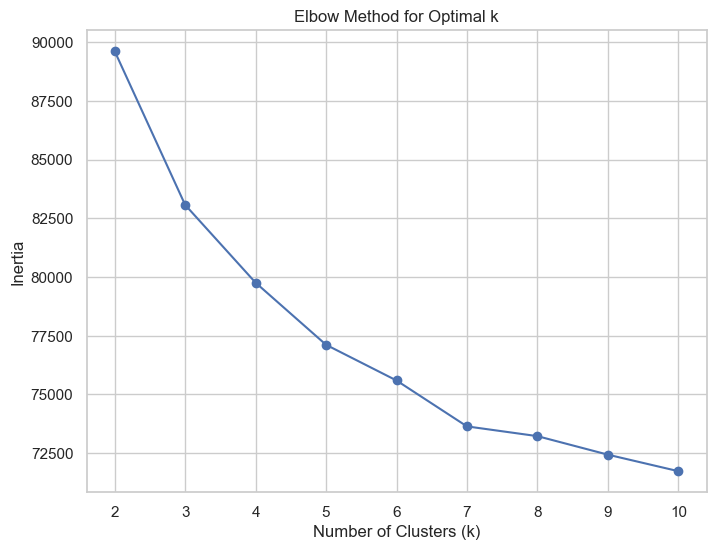


--- Visualizing Silhouette Scores for k in [2, 3, 4, 5, 6, 7, 8, 9, 10] ---


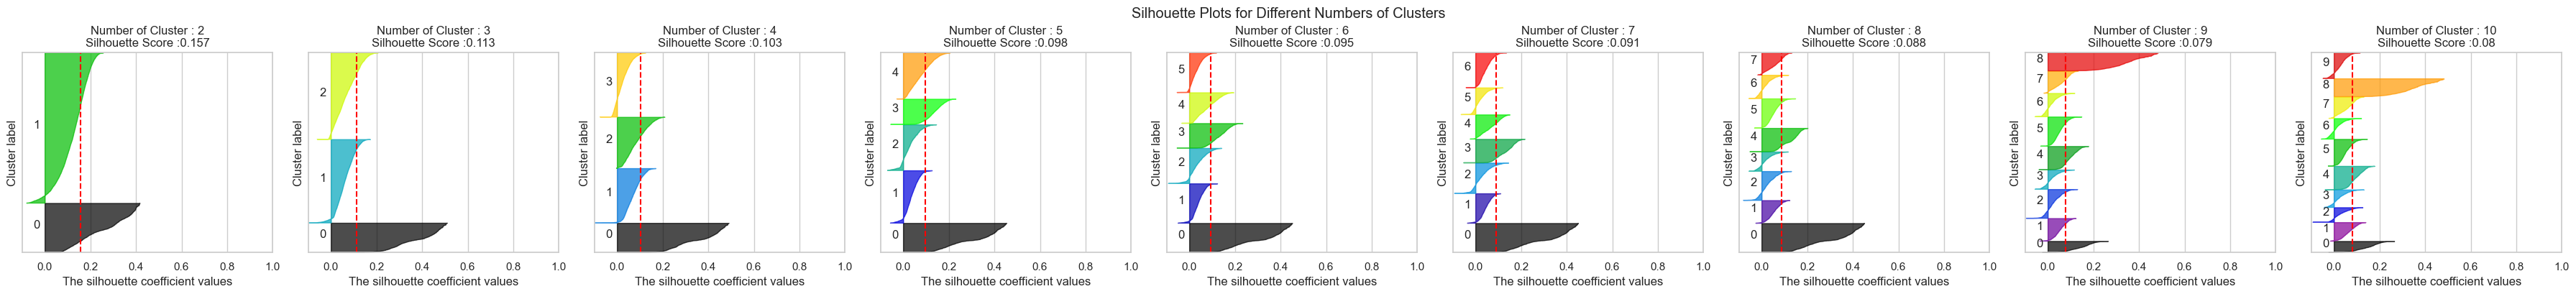


>>> Please examine the plots and set the 'optimal_k' variable in the code. <<<
>>> Currently using optimal_k = 4 (example value). <<<

=== Iteration 1: Baseline Clustering (KMeans, k=4) ===

--- Running Iteration with 25 features ---

--- Preprocessing ---
Numeric columns in current df: ['HE_sbp1', 'HE_dbp1', 'HE_wc', 'HE_HbA1c', 'HE_chol', 'HE_HDL_st2', 'HE_crea', 'HE_ast', 'age', 'L_OUT_FQ', 'LS_VEG1']
Categorical columns in current df: ['DI1_pr', 'DI1_2', 'DI2_pr', 'DI2_2', 'DE1_dg', 'DN1_dg', 'BO1', 'BO2_1', 'BD1_11', 'BP1', 'BP5', 'BE5_1', 'BS3_2', 'BE3_31']
Shape after preprocessing (scaled and OHE): (6929, 967)
PCA reduced dimensions to: 127
Explained variance ratio: 0.9503

--- Running KMeans (k=4) ---
KMeans (k=4): Silhouette Score = 0.1028

Feature Importance (Random Forest) for non-noise clusters:
age           0.148681
HE_HbA1c      0.095638
HE_chol       0.094191
DE1_dg        0.085090
HE_wc         0.075897
HE_sbp1       0.072342
HE_dbp1       0.064199
DI2_2         0.05

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm # For silhouette plot colors
import seaborn as sns

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.ensemble import RandomForestClassifier

# ÌÜµÍ≥Ñ Î∂ÑÏÑùÏùÑ ÏúÑÌïú ÎùºÏù¥Î∏åÎü¨Î¶¨ ÏûÑÌè¨Ìä∏
from scipy import stats
import statsmodels.api as sm # Ïπ¥Ïù¥Ï†úÍ≥± Í≤ÄÏ†ï Í≤∞Í≥ºÎ•º Ï¢Ä Îçî ÏÉÅÏÑ∏Ìûà Î≥¥Ïó¨Ï£ºÍ∏∞ ÏúÑÌï¥ Ï∂îÍ∞Ä (Optional)
from statsmodels.stats.contingency_tables import Table # Ïπ¥Ïù¥Ï†úÍ≥± Í≤ÄÏ†ïÏùÑ ÏúÑÌïú ÌÅ¥ÎûòÏä§

# ÏãúÍ∞ÅÌôî ÏÑ§Ï†ï
sns.set(style="whitegrid")

# Ï†ÑÏ≤òÎ¶¨ Ìï®Ïàò (Ïù¥Ï†Ñ ÏΩîÎìúÏôÄ ÎèôÏùº)
def preprocess_data(df, original_numeric_cols, original_categorical_cols):
    """
    Preprocess data: impute missing values, handle outliers, encode categorical features.
    Processes only the columns present in the input df, based on original_numeric_cols and original_categorical_cols.
    """
    df_processed = df.copy()

    current_numeric_cols = [col for col in original_numeric_cols if col in df_processed.columns]
    current_categorical_cols = [col for col in original_categorical_cols if col in df_processed.columns]

    print(f"\n--- Preprocessing ---")
    print(f"Numeric columns in current df: {current_numeric_cols}")
    print(f"Categorical columns in current df: {current_categorical_cols}")

    # 888, 999 Í∞íÏùÑ NaNÏúºÎ°ú ÎåÄÏ≤¥
    df_processed = df_processed.replace([888, 999], np.nan)

    # Ïà´ÏûêÌòï ÏπºÎüº Í≤∞Ï∏°Ïπò KNN ImputerÎ°ú Ï≤òÎ¶¨
    if current_numeric_cols:
        # ImputerÎäî fit_transform ÏãúÏ†êÏóê Í≤∞Ï∏°ÏπòÎ•º ÌïôÏäµÌïòÍ≥† Ï±ÑÏõÅÎãàÎã§.
        # Ïù¥ Ìï®ÏàòÎäî Îß§Î≤à ÏÉàÎ°úÏö¥ ImputerÎ•º ÏÉùÏÑ±ÌïòÏó¨ fit_transform Ìï©ÎãàÎã§.
        # ÎßåÏïΩ ÏùºÍ¥ÄÎêú ImputerÎ•º ÏÇ¨Ïö©ÌïòÎ†§Î©¥ Ìï®Ïàò Ïô∏Î∂ÄÏóêÏÑú fit Îêú ImputerÎ•º Ï†ÑÎã¨Ìï¥Ïïº Ìï©ÎãàÎã§.
        # ÌòÑÏû¨ ÏΩîÎìú ÌùêÎ¶Ñ ÏÉÅ Í∑∏Î£πÎ≥Ñ/ÌîºÏ≤òÏÖãÎ≥ÑÎ°ú Îã§Î•∏ ImputerÍ∞Ä ÌïÑÏöîÌï† Ïàò ÏûàÏúºÎØÄÎ°ú Ïù¥ Î∞©Ïãù Ïú†ÏßÄ
        numeric_data_for_impute = df_processed[current_numeric_cols].values
        imputer = KNNImputer(n_neighbors=5)
        numeric_data_imputed = imputer.fit_transform(numeric_data_for_impute)
        df_processed[current_numeric_cols] = numeric_data_imputed

    # Î≤îÏ£ºÌòï ÏπºÎüº Í≤∞Ï∏°Ïπò ÏµúÎπàÍ∞íÏúºÎ°ú Ï≤òÎ¶¨
    if current_categorical_cols:
        for col in current_categorical_cols:
             if df_processed[col].isnull().any():
                 try:
                     # mode() Í≤∞Í≥ºÎäî SeriesÏù¥ÎØÄÎ°ú [0]ÏúºÎ°ú Ï≤´ Î≤àÏß∏ Í∞í ÏÑ†ÌÉù
                     mode_val = df_processed[col].mode()[0]
                     df_processed[col] = df_processed[col].fillna(mode_val)
                 except IndexError:
                     # mode()Í∞Ä ÎπÑÏñ¥ÏûàÎäî Í≤ΩÏö∞ (Î™®Îì† Í∞íÏù¥ NaNÏùº Îïå)
                     print(f"Warning: Could not compute mode for {col} or all values are NaN. Skipping fillna for this column.")
                     pass # fillnaÎ•º Í±¥ÎÑàÎõ∞Ïñ¥ Ìï¥Îãπ ÏπºÎüºÏùÄ Ïó¨Ï†ÑÌûà NaNÏùÑ Í∞ÄÏßà Ïàò ÏûàÏùå (Ï£ºÏùò ÌïÑÏöî)
                 except Exception as e:
                     print(f"Error filling categorical missing values for {col}: {e}")
                     pass


    # Ïù¥ÏÉÅÏπò Ï≤òÎ¶¨ (IQR Í∏∞Ï§Ä) - Ïà´ÏûêÌòï ÏπºÎüºÏóêÎßå Ï†ÅÏö©
    if current_numeric_cols:
        for col in current_numeric_cols:
            # IQR Í≥ÑÏÇ∞
            Q1 = df_processed[col].quantile(0.25)
            Q3 = df_processed[col].quantile(0.75)
            IQR = Q3 - Q1
            # Ïù¥ÏÉÅÏπò Í≤ΩÍ≥Ñ Í≥ÑÏÇ∞
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            # Ïù¥ÏÉÅÏπò Í∞íÏùÑ Í≤ΩÍ≥ÑÍ∞íÏúºÎ°ú ÎåÄÏ≤¥ (ÌÅ¥Î¶¨Ìïë)
            df_processed[col] = df_processed[col].clip(lower_bound, upper_bound)

    # Ï†ÑÏ≤òÎ¶¨Î•º ÏúÑÌïú ColumnTransformer ÏÑ§Ï†ï
    transformers = []
    if current_numeric_cols:
        # Ïà´ÏûêÌòï ÏπºÎüºÏóê RobustScaler Ï†ÅÏö© (Ïù¥ÏÉÅÏπòÏóê Í∞ïÌï®)
        transformers.append(('num', RobustScaler(), current_numeric_cols))
    if current_categorical_cols:
        # Î≤îÏ£ºÌòï ÏπºÎüºÏóê OneHotEncoder Ï†ÅÏö©
        # handle_unknown='ignore': ÌïôÏäµ Îç∞Ïù¥ÌÑ∞Ïóê ÏóÜÎçò ÏÉàÎ°úÏö¥ Î≤îÏ£ºÍ∞Ä ÏòàÏ∏° Ïãú ÎÇòÌÉÄÎÇòÎ©¥ Î¨¥Ïãú
        transformers.append(('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), current_categorical_cols))

    # Î≥ÄÌôòÌï† ÏπºÎüºÏù¥ ÏóÜÏúºÎ©¥ Îπà Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ Î∞òÌôò
    if not transformers:
        print("No numeric or categorical columns remaining after filtering.")
        # scaled_df, all_transformed_features, preprocessor, df_processed_subset Î∞òÌôò
        return pd.DataFrame(), [], None, df_processed

    # ColumnTransformer ÏÉùÏÑ± Î∞è ÌïôÏäµ/Î≥ÄÌôò
    preprocessor = ColumnTransformer(
        transformers=transformers,
        remainder='passthrough' # Î≥ÄÌôòÍ∏∞Ïóê ÏßÄÏ†ïÎêòÏßÄ ÏïäÏùÄ ÏπºÎüºÏùÄ Í∑∏ÎåÄÎ°ú Ïú†ÏßÄ
    )

    try:
        # preprocessorÎ•º Îç∞Ïù¥ÌÑ∞Ïóê fit_transform Ìï©ÎãàÎã§.
        scaled_data = preprocessor.fit_transform(df_processed)
        # Î≥ÄÌôò ÌõÑ ÏπºÎüº Ïù¥Î¶Ñ Í∞ÄÏ†∏Ïò§Í∏∞
        all_transformed_features = preprocessor.get_feature_names_out()
        # Î≥ÄÌôòÎêú Îç∞Ïù¥ÌÑ∞Î•º DataFrameÏúºÎ°ú Î≥ÄÌôò (ÏπºÎüº Ïù¥Î¶Ñ Ìè¨Ìï®)
        scaled_df = pd.DataFrame(scaled_data, columns=all_transformed_features)
        print(f"Shape after preprocessing (scaled and OHE): {scaled_df.shape}")
    except Exception as e:
        print(f"Error during preprocessing transformation: {e}")
        # Ïò§Î•ò Î∞úÏÉù Ïãú Îπà Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ Îì± Î∞òÌôò
        return pd.DataFrame(), [], None, df_processed

    # Ï†ÑÏ≤òÎ¶¨Îêú Ïä§ÏºÄÏùºÎßÅ/OHE Îç∞Ïù¥ÌÑ∞, Î≥ÄÌôòÎêú ÌîºÏ≤ò Ïù¥Î¶Ñ Î™©Î°ù, ÌïôÏäµÎêú preprocessor Í∞ùÏ≤¥, Ïù¥ÏÉÅÏπò/Í≤∞Ï∏°Ïπò Ï≤òÎ¶¨Îêú ÏõêÎ≥∏ ÌòïÌÉú Îç∞Ïù¥ÌÑ∞ Î∞òÌôò
    return scaled_df, all_transformed_features, preprocessor, df_processed

# select_features Ìï®Ïàò (Ïù¥Ï†Ñ ÏΩîÎìúÏôÄ ÎèôÏùº)
def select_features(df, columns, corr_threshold=0.8):
    """Remove highly correlated numeric features."""
    # ÏûÖÎ†•Îêú ÏπºÎüº Î™©Î°ù Ï§ë Ïà´ÏûêÌòï ÏπºÎüºÎßå ÏÑ†ÌÉù
    numeric_df = df[columns].select_dtypes(include=[np.number])
    if numeric_df.empty:
        print("No numeric columns provided for correlation check.")
        return [] # Ïà´ÏûêÌòï ÏπºÎüºÏù¥ ÏóÜÏúºÎ©¥ Îπà Î¶¨Ïä§Ìä∏ Î∞òÌôò

    # ÏÉÅÍ¥Ä ÌñâÎ†¨ Í≥ÑÏÇ∞ (Ï†àÎåÄÍ∞í ÏÇ¨Ïö©)
    corr_matrix = numeric_df.corr().abs()
    # ÏÉÅÍ¥Ä ÌñâÎ†¨Ïùò ÏÉÅÏÇºÍ∞Å ÌñâÎ†¨Îßå Í∞ÄÏ†∏Ïò¥ (ÎåÄÍ∞ÅÏÑ† Ï†úÏô∏)
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    # ÏÉÅÍ¥ÄÍ≥ÑÏàòÍ∞Ä ÏûÑÍ≥ÑÍ∞íÎ≥¥Îã§ ÎÜíÏùÄ ÏπºÎüºÎì§ÏùÑ Ï∞æÏùå
    to_drop = [column for column in upper.columns if any(upper[column] > corr_threshold)]
    # Ï†úÍ±∞Ìï† ÏπºÎüºÏùÑ Ï†úÏô∏Ìïú Ïà´ÏûêÌòï ÏπºÎüº Î™©Î°ù ÏÉùÏÑ±
    selected_numeric_cols = [col for col in columns if col not in to_drop]
    print(f"Removed highly correlated numeric features (>{corr_threshold}): {to_drop}")
    print(f"Selected numeric features after correlation check: {selected_numeric_cols}")
    return selected_numeric_cols # ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ ÌïÑÌÑ∞ÎßÅ ÌõÑ Ïà´ÏûêÌòï ÏπºÎüº Î™©Î°ù Î∞òÌôò

# compute_feature_importance Ìï®Ïàò (Ïù¥Ï†Ñ ÏΩîÎìúÏôÄ ÎèôÏùº)
def compute_feature_importance(df_processed, selected_cols, cluster_labels):
    """Compute feature importance using Random Forest."""
    # ÌÅ¥Îü¨Ïä§ÌÑ∞ ÎùºÎ≤®Ïù¥ 2Í∞ú Ïù¥ÏÉÅÏù¥Í≥† ÎÖ∏Ïù¥Ï¶à ÌÅ¥Îü¨Ïä§ÌÑ∞(-1)Îßå ÏûàÎäî Í≤ΩÏö∞Í∞Ä ÏïÑÎãê ÎïåÎßå Ï§ëÏöîÎèÑ Í≥ÑÏÇ∞
    if len(np.unique(cluster_labels[cluster_labels != -1])) < 2:
        print("\nFeature Importance: Not enough non-noise clusters (>= 2 required) or only noise cluster.")
        return pd.Series([], dtype=float) # Í≥ÑÏÇ∞ Î∂àÍ∞Ä Ïãú Îπà Series Î∞òÌôò

    # ÎÖ∏Ïù¥Ï¶à ÌÅ¥Îü¨Ïä§ÌÑ∞(-1)Ïóê Ìï¥ÎãπÌïòÎäî Îç∞Ïù¥ÌÑ∞ Ìè¨Ïù∏Ìä∏ Ï†úÏô∏
    non_noise_indices = cluster_labels != -1
    df_filtered = df_processed.loc[non_noise_indices].copy() # ÌïÑÌÑ∞ÎßÅÎêú Îç∞Ïù¥ÌÑ∞ Î≥µÏÇ¨
    labels_filtered = cluster_labels[non_noise_indices] # ÌïÑÌÑ∞ÎßÅÎêú ÎùºÎ≤®

    # ÌïÑÌÑ∞ÎßÅ ÌõÑ Îç∞Ïù¥ÌÑ∞Í∞Ä ÎπÑÏñ¥ÏûàÏúºÎ©¥ Í≥ÑÏÇ∞ Î∂àÍ∞Ä
    if df_filtered.empty:
        print("\nFeature Importance: No non-noise data points found after filtering.")
        return pd.Series([], dtype=float) # Í≥ÑÏÇ∞ Î∂àÍ∞Ä Ïãú Îπà Series Î∞òÌôò

    try:
        # Random Forest Classifier Î™®Îç∏ ÏÉùÏÑ± Î∞è ÌïôÏäµ
        rf = RandomForestClassifier(random_state=42)
        # ÌïôÏäµ Îç∞Ïù¥ÌÑ∞Îäî ÌïÑÌÑ∞ÎßÅÎêú Îç∞Ïù¥ÌÑ∞ÏôÄ Ìï¥Îãπ ÌîºÏ≤òÎì§, ÌïÑÌÑ∞ÎßÅÎêú ÎùºÎ≤® ÏÇ¨Ïö©
        # df_filteredÎäî Ïù¥ÏÉÅÏπò/Í≤∞Ï∏°Ïπò Ï≤òÎ¶¨Îêú ÏõêÎ≥∏ ÌòïÌÉúÏùò Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏûÖÎãàÎã§.
        # OHEÎêú Îç∞Ïù¥ÌÑ∞Í∞Ä ÌïÑÏöîÌïòÎã§Î©¥ scaled_dfÎ•º ÏÇ¨Ïö©Ìï¥Ïïº Ìï©ÎãàÎã§.
        # ÌòÑÏû¨ ÏΩîÎìúÎäî df_processed_subset (Ïù¥ÏÉÅÏπò/Í≤∞Ï∏°Ïπò Ï≤òÎ¶¨Îêú ÏõêÎ≥∏ ÌòïÌÉú)Î•º ÏÇ¨Ïö©Ìï©ÎãàÎã§.
        # ÎßåÏïΩ OHEÎêú Îç∞Ïù¥ÌÑ∞Î°ú Ï§ëÏöîÎèÑÎ•º Í≥ÑÏÇ∞ÌïòÎ†§Î©¥ scaled_dfÏôÄ all_transformed_featuresÎ•º ÏÇ¨Ïö©ÌïòÎèÑÎ°ù ÏàòÏ†ï ÌïÑÏöî.
        # Ïó¨Í∏∞ÏÑúÎäî Í∏∞Ï°¥ ÏΩîÎìúÎåÄÎ°ú df_processed_subsetÏùÑ ÏÇ¨Ïö©Ìï©ÎãàÎã§.
        rf.fit(df_filtered[selected_cols], labels_filtered)
        # ÌîºÏ≤ò Ï§ëÏöîÎèÑ Ï∂îÏ∂ú Î∞è SeriesÎ°ú Î≥ÄÌôò ÌõÑ ÎÇ¥Î¶ºÏ∞®Ïàú Ï†ïÎ†¨
        importance = pd.Series(rf.feature_importances_, index=selected_cols).sort_values(ascending=False)
        print("\nFeature Importance (Random Forest) for non-noise clusters:")
        print(importance)
        return importance # ÌîºÏ≤ò Ï§ëÏöîÎèÑ Series Î∞òÌôò

    except Exception as e:
        print(f"\nError computing Feature Importance: {e}")
        return pd.Series([], dtype=float) # Ïò§Î•ò Î∞úÏÉù Ïãú Îπà Series Î∞òÌôò

# visualize_silhouette Ìï®Ïàò (Ïù¥Ï†Ñ ÏΩîÎìúÏôÄ ÎèôÏùº)
def visualize_silhouette(cluster_lists, X_features):
    """
    Ï£ºÏñ¥ÏßÑ ÌÅ¥Îü¨Ïä§ÌÑ∞ Í∞úÏàò Î¶¨Ïä§Ìä∏Ïóê ÎåÄÌï¥ K-MeansÎ•º Ï†ÅÏö©ÌïòÍ≥† Ïã§Î£®Ïó£ Í≥ÑÏàòÎ•º ÏãúÍ∞ÅÌôîÌï©ÎãàÎã§.

    Args:
        cluster_lists (list): ÌÖåÏä§Ìä∏Ìï† ÌÅ¥Îü¨Ïä§ÌÑ∞ Í∞úÏàò(k)Ïùò Î¶¨Ïä§Ìä∏.
        X_features (numpy.ndarray or pandas.DataFrame): ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅ ÎåÄÏÉÅ Îç∞Ïù¥ÌÑ∞ (PCA Í≤∞Í≥º Îì±).
    """
    print(f"\n--- Visualizing Silhouette Scores for k in {cluster_lists} ---")

    n_cols = len(cluster_lists)
    # ÏÑúÎ∏åÌîåÎ°Ø ÏÉùÏÑ±. n_colsÍ∞Ä 1Ïùº Îïå axsÍ∞Ä Î∞∞Ïó¥Ïù¥ ÏïÑÎãàÎØÄÎ°ú reshape(-1)Î°ú Ìï≠ÏÉÅ Î∞∞Ïó¥ ÌòïÌÉúÎ°ú ÎßåÎì¶
    fig, axs = plt.subplots(figsize=(4 * n_cols, 4), nrows=1, ncols=n_cols, squeeze=False)
    axs = axs.reshape(-1) # 1D Î∞∞Ïó¥Î°ú ÌèâÌÉÑÌôî

    for ind, n_cluster in enumerate(cluster_lists):
        ax = axs[ind] # Í∞Å ÏÑúÎ∏åÌîåÎ°Ø ÏÑ†ÌÉù

        try:
            # ÌÅ¥Îü¨Ïä§ÌÑ∞ Í∞úÏàòÍ∞Ä 2Í∞ú ÎØ∏ÎßåÏù¥Î©¥ Ïã§Î£®Ïó£ Ï†êÏàò Í≥ÑÏÇ∞ Î∂àÍ∞Ä
            if n_cluster < 2:
                print(f"Skipping silhouette visualization for k={n_cluster} (< 2).")
                ax.set_title(f'k={n_cluster} (Skipped)')
                ax.text(0.5, 0.5, 'k < 2', horizontalalignment='center', verticalalignment='center')
                ax.set_xticks([])
                ax.set_yticks([])
                continue # Îã§Ïùå kÎ°ú ÎÑòÏñ¥Í∞ê

            # K-Means Î™®Îç∏ ÏÉùÏÑ± Î∞è ÌïôÏäµ
            # n_init='auto' ÎòêÎäî Î™ÖÏãúÏ†ÅÏù∏ Ïà´ÏûêÎ°ú ÏßÄÏ†ï ÌïÑÏöî
            clusterer = KMeans(n_clusters=n_cluster, max_iter=500, random_state=0, n_init='auto')
            cluster_labels = clusterer.fit_predict(X_features)

            # Ïã§Î£®Ïó£ Ï†êÏàò Í≥ÑÏÇ∞
            sil_avg = silhouette_score(X_features, cluster_labels)
            sil_values = silhouette_samples(X_features, cluster_labels)

            # Ïã§Î£®Ïó£ ÌîåÎ°Ø Í∑∏Î¶¨Í∏∞ ÏÑ§Ï†ï
            y_lower = 10 # Ï≤´ Î≤àÏß∏ ÌÅ¥Îü¨Ïä§ÌÑ∞ ÌîåÎ°ØÏùò ÏãúÏûë ÏúÑÏπò

            # ÌîåÎ°Ø Ï†úÎ™© ÏÑ§Ï†ï (kÍ∞í Î∞è ÌèâÍ∑† Ïã§Î£®Ïó£ Ï†êÏàò Ìè¨Ìï®)
            ax.set_title('Number of Cluster : ' + str(n_cluster)+'\n' \
                         'Silhouette Score :' + str(round(sil_avg,3)) )
            ax.set_xlabel("The silhouette coefficient values")
            ax.set_ylabel("Cluster label")
            ax.set_xlim([-0.1, 1]) # xÏ∂ï Î≤îÏúÑ ÏÑ§Ï†ï
            ax.set_ylim([0, len(X_features) + (n_cluster + 1) * 10]) # yÏ∂ï Î≤îÏúÑ ÏÑ§Ï†ï
            ax.set_yticks([]) # yÏ∂ï Ìã± Ï†úÍ±∞
            ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1]) # xÏ∂ï Ìã± ÏÑ§Ï†ï

            # Í∞Å ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ Ïã§Î£®Ïó£ ÌîåÎ°Ø Í∑∏Î¶¨Í∏∞
            for i in range(n_cluster):
                # iÎ≤àÏß∏ ÌÅ¥Îü¨Ïä§ÌÑ∞Ïóê Ìï¥ÎãπÌïòÎäî Ïã§Î£®Ïó£ Ï†êÏàò Í∞ÄÏ†∏Ïò§Í∏∞
                ith_cluster_sil_values = sil_values[cluster_labels == i]
                ith_cluster_sil_values.sort() # Ï†êÏàò Ï†ïÎ†¨

                size_cluster_i = ith_cluster_sil_values.shape[0] # ÌÅ¥Îü¨Ïä§ÌÑ∞ iÏùò ÏÉòÌîå Ïàò
                y_upper = y_lower + size_cluster_i # ÌòÑÏû¨ ÌÅ¥Îü¨Ïä§ÌÑ∞ ÌîåÎ°ØÏùò ÎÅù ÏúÑÏπò

                # ÌÅ¥Îü¨Ïä§ÌÑ∞ ÏÉâÏÉÅ ÏÑ§Ï†ï
                color = cm.nipy_spectral(float(i) / n_cluster)
                # fill_betweenxÎ•º ÏÇ¨Ïö©ÌïòÏó¨ Ïã§Î£®Ïó£ Ï†êÏàò ÏòÅÏó≠ Ï±ÑÏö∞Í∏∞
                ax.fill_betweenx(np.arange(y_lower, y_upper),
                                 0, ith_cluster_sil_values,
                                 facecolor=color, edgecolor=color, alpha=0.7)

                # ÌÅ¥Îü¨Ïä§ÌÑ∞ Î≤àÌò∏ ÌÖçÏä§Ìä∏ Ï∂îÍ∞Ä
                ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

                # Îã§Ïùå ÌÅ¥Îü¨Ïä§ÌÑ∞ ÌîåÎ°ØÏùÑ ÏúÑÌïú y_lower ÏúÑÏπò ÏóÖÎç∞Ïù¥Ìä∏
                y_lower = y_upper + 10 # ÌÅ¥Îü¨Ïä§ÌÑ∞ Í∞Ñ Í∞ÑÍ≤© Ï∂îÍ∞Ä

            # ÌèâÍ∑† Ïã§Î£®Ïó£ Ï†êÏàò ÎùºÏù∏ Ï∂îÍ∞Ä
            ax.axvline(x=sil_avg, color="red", linestyle="--")

        except Exception as e:
            print(f"Error visualizing silhouette for k={n_cluster}: {e}")
            ax.set_title(f'k={n_cluster} (Error)')
            ax.text(0.5, 0.5, 'Error', horizontalalignment='center', verticalalignment='center')
            ax.set_xticks([])
            ax.set_yticks([])

    # Ï†ÑÏ≤¥ ÌîåÎ°Ø Î†àÏù¥ÏïÑÏõÉ Ï°∞Ï†ï Î∞è Ï†úÎ™© Ï∂îÍ∞Ä
    plt.tight_layout()
    plt.suptitle('Silhouette Plots for Different Numbers of Clusters', y=1.02)
    plt.show()


# Îã®Ïùº ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅ Ïù¥ÌÑ∞Î†àÏù¥ÏÖòÏùÑ Ïã§ÌñâÌïòÎäî Ìï®Ïàò (Ïù¥Ï†Ñ ÏΩîÎìúÏôÄ ÎèôÏùº)
def run_clustering_iteration(df_original, features_to_use, original_numeric_cols, original_categorical_cols, n_clusters, algorithm):
    """
    Runs one iteration of preprocessing, PCA, clustering, scoring, and importance calculation
    using a specified subset of features.
    Returns scaled_df_pca for direct use in analysis functions.
    """
    print(f"\n--- Running Iteration with {len(features_to_use)} features ---")

    if not features_to_use:
        print("No features selected for this iteration. Skipping.")
        # scaled_df_pca Ï∂îÍ∞Ä Î∞òÌôòÍ∞í None
        return None, None, None, None, None, None, None

    # ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏóêÏÑú ÏÇ¨Ïö©Ìï† ÌîºÏ≤òÎßå ÏÑ†ÌÉùÌïòÏó¨ Î≥µÏÇ¨Î≥∏ ÏÉùÏÑ±
    df_subset = df_original[features_to_use].copy()

    try:
        # Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨ (Í≤∞Ï∏°Ïπò, Ïù¥ÏÉÅÏπò Ï≤òÎ¶¨, Ïä§ÏºÄÏùºÎßÅ, OHE)
        # preprocess_data Ìï®ÏàòÎäî scaled_df (Ïä§ÏºÄÏùºÎßÅ/OHE ÏôÑÎ£å), all_transformed_features,
        # preprocessor Í∞ùÏ≤¥, df_processed_subset (Ïù¥ÏÉÅÏπò/Í≤∞Ï∏°Ïπò Ï≤òÎ¶¨Îêú ÏõêÎ≥∏ ÌòïÌÉú) Î∞òÌôò
        scaled_df, all_transformed_features, preprocessor, df_processed_subset = preprocess_data(
            df_subset,
            original_numeric_cols,
            original_categorical_cols
        )
        # Ï†ÑÏ≤òÎ¶¨ Í≤∞Í≥º Îç∞Ïù¥ÌÑ∞Í∞Ä ÎπÑÏñ¥ÏûàÏúºÎ©¥ Ïä§ÌÇµ
        if scaled_df.empty:
            print("Preprocessing returned empty data. Skipping iteration.")
            return features_to_use, None, None, None, df_processed_subset, None, None

    except Exception as e:
        print(f"An error occurred during preprocessing: {e}. Skipping iteration.")
        return features_to_use, None, None, None, None, None, None

    # PCAÎ•º ÏÇ¨Ïö©ÌïòÏó¨ Ï∞®Ïõê Ï∂ïÏÜå
    pca = PCA(n_components=0.95, random_state=42) # ÏÑ§Î™ÖÎêú Î∂ÑÏÇ∞Ïùò 95%Î•º Ïú†ÏßÄÌïòÎèÑÎ°ù Ï∞®Ïõê Ï∂ïÏÜå
    scaled_df_pca = None # PCA Í≤∞Í≥º Î≥ÄÏàò Ï¥àÍ∏∞Ìôî
    try:
        # Ïä§ÏºÄÏùºÎßÅ/OHE ÏôÑÎ£åÎêú Îç∞Ïù¥ÌÑ∞Ïóê PCA Ï†ÅÏö©
        scaled_df_pca = pca.fit_transform(scaled_df)
        print(f"PCA reduced dimensions to: {scaled_df_pca.shape[1]}")
        print(f"Explained variance ratio: {sum(pca.explained_variance_ratio_):.4f}")
    except Exception as e:
        print(f"PCA failed: {e}. Skipping clustering and importance.")
        # PCA Ïã§Ìå® Ïãú Í¥ÄÎ†® Î≥ÄÏàò NoneÏúºÎ°ú Î∞òÌôò
        return features_to_use, None, None, None, df_processed_subset, scaled_df, None

    # PCA Í≤∞Í≥º Îç∞Ïù¥ÌÑ∞Í∞Ä ÎπÑÏñ¥ÏûàÍ±∞ÎÇò Ìñâ ÏàòÍ∞Ä 0Ïù¥Î©¥ Ïä§ÌÇµ
    if scaled_df_pca is None or scaled_df_pca.shape[0] == 0:
        print("PCA returned no data. Skipping clustering and importance.")
        return features_to_use, None, None, None, df_processed_subset, scaled_df, None


    # ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅ ÏïåÍ≥†Î¶¨Ï¶ò ÏÑ†ÌÉù Î∞è Ïã§Ìñâ
    clusters = None # ÌÅ¥Îü¨Ïä§ÌÑ∞ ÎùºÎ≤® Î≥ÄÏàò Ï¥àÍ∏∞Ìôî
    score = None # Ïã§Î£®Ïó£ Ï†êÏàò Î≥ÄÏàò Ï¥àÍ∏∞Ìôî
    algorithm_used = None # ÏÇ¨Ïö©Îêú ÏïåÍ≥†Î¶¨Ï¶ò Ïù¥Î¶Ñ Î≥ÄÏàò Ï¥àÍ∏∞Ìôî

    try:
        if algorithm == 'Agglomerative':
            algorithm_used = f'Agglomerative (k={n_clusters})'
            print(f"\n--- Running {algorithm_used} ---")
            # Agglomerative Clustering Î™®Îç∏ ÏÉùÏÑ± Î∞è ÌïôÏäµ/ÏòàÏ∏°
            model = AgglomerativeClustering(n_clusters=n_clusters)
            clusters = model.fit_predict(scaled_df_pca)

        elif algorithm == 'KMeans':
            algorithm_used = f'KMeans (k={n_clusters})'
            print(f"\n--- Running {algorithm_used} ---")
            # K-Means Î™®Îç∏ ÏÉùÏÑ± Î∞è ÌïôÏäµ/ÏòàÏ∏°
            # n_init='auto' ÎòêÎäî Î™ÖÏãúÏ†ÅÏù∏ Ïà´ÏûêÎ°ú ÏßÄÏ†ï ÌïÑÏöî
            model = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
            clusters = model.fit_predict(scaled_df_pca)

        # DBSCAN ÏïåÍ≥†Î¶¨Ï¶ò (ÌïÑÏöîÌïòÎã§Î©¥ Ï∂îÍ∞Ä)
        # elif algorithm == 'DBSCAN':
        #     algorithm_used = f'DBSCAN (eps={eps}, min_samples={min_samples})'
        #     print(f"\n--- Running {algorithm_used} ---")
        #     model = DBSCAN(eps=eps, min_samples=min_samples)
        #     clusters = model.fit_predict(scaled_df_pca)

        else:
            # ÏßÄÏõêÌïòÏßÄ ÏïäÎäî ÏïåÍ≥†Î¶¨Ï¶òÏù∏ Í≤ΩÏö∞ Ïò§Î•ò Î∞úÏÉù
            raise ValueError(f"Unsupported algorithm: {algorithm}")

        # Ïã§Î£®Ïó£ Ïä§ÏΩîÏñ¥ Í≥ÑÏÇ∞
        # ÌÅ¥Îü¨Ïä§ÌÑ∞ Í∞úÏàòÍ∞Ä 1Í∞úÎ≥¥Îã§ ÎßéÍ≥†, Î™®Îì† Îç∞Ïù¥ÌÑ∞Í∞Ä ÎÖ∏Ïù¥Ï¶à ÌÅ¥Îü¨Ïä§ÌÑ∞(-1)Ïóê ÏÜçÌïòÏßÄ ÏïäÏùÑ ÎïåÎßå Í≥ÑÏÇ∞ Í∞ÄÎä•
        # Agglomerative/KMeansÎäî Í∏∞Î≥∏Ï†ÅÏúºÎ°ú Î™®Îì† Îç∞Ïù¥ÌÑ∞Ïóê ÎùºÎ≤®ÏùÑ Ìï†ÎãπÌïòÎØÄÎ°ú -1 ÌÅ¥Îü¨Ïä§ÌÑ∞Îäî ÏóÜÏäµÎãàÎã§.
        if len(np.unique(clusters)) > 1: # ÌÅ¥Îü¨Ïä§ÌÑ∞ Í∞úÏàòÍ∞Ä 2Í∞ú Ïù¥ÏÉÅÏùº Îïå
             score = silhouette_score(scaled_df_pca, clusters)
             print(f"{algorithm_used}: Silhouette Score = {score:.4f}")
        else:
             print(f"{algorithm_used}: Silhouette Score not computable (less than 2 clusters).")
             score = None # Í≥ÑÏÇ∞ Î∂àÍ∞Ä Ïãú score None ÏÑ§Ï†ï

    except Exception as e:
        print(f"{algorithm_used} failed: {e}")
        clusters = None # ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅ Ïã§Ìå® Ïãú clusters None ÏÑ§Ï†ï
        score = None # Ïä§ÏΩîÏñ¥ Í≥ÑÏÇ∞ Ïã§Ìå® Ïãú score None ÏÑ§Ï†ï


    # ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅÏù¥ ÏÑ±Í≥µÌïòÍ≥† Ïã§Î£®Ïó£ Ïä§ÏΩîÏñ¥ Í≥ÑÏÇ∞Ïù¥ Í∞ÄÎä•ÌñàÏùÑ ÎïåÎßå ÌîºÏ≤ò Ï§ëÏöîÎèÑ Í≥ÑÏÇ∞
    if clusters is None or score is None:
        print("Clustering failed or score could not be computed. Skipping importance calculation.")
        # features_to_use, clusters, score, importance, df_processed_subset, scaled_df, scaled_df_pca Î∞òÌôò
        return features_to_use, clusters, score, None, df_processed_subset, scaled_df, scaled_df_pca # importance None


    # ÌîºÏ≤ò Ï§ëÏöîÎèÑ Í≥ÑÏÇ∞
    # compute_feature_importance Ìï®ÏàòÎäî Ïù¥ÏÉÅÏπò/Í≤∞Ï∏°Ïπò Ï≤òÎ¶¨Îêú ÏõêÎ≥∏ ÌòïÌÉú Îç∞Ïù¥ÌÑ∞(df_processed_subset)ÏôÄ ÌÅ¥Îü¨Ïä§ÌÑ∞ ÎùºÎ≤® ÏÇ¨Ïö©
    importance = compute_feature_importance(df_processed_subset, features_to_use, clusters)

    # ÏÇ¨Ïö©Îêú ÌîºÏ≤ò Î™©Î°ù, ÌÅ¥Îü¨Ïä§ÌÑ∞ ÎùºÎ≤®, Ïã§Î£®Ïó£ Ï†êÏàò, ÌîºÏ≤ò Ï§ëÏöîÎèÑ, Ïù¥ÏÉÅÏπò/Í≤∞Ï∏°Ïπò Ï≤òÎ¶¨Îêú Îç∞Ïù¥ÌÑ∞,
    # Ïä§ÏºÄÏùºÎßÅ/OHE ÏôÑÎ£åÎêú Îç∞Ïù¥ÌÑ∞, PCA Í≤∞Í≥º Îç∞Ïù¥ÌÑ∞ Î∞òÌôò
    return features_to_use, clusters, score, importance, df_processed_subset, scaled_df, scaled_df_pca


def main():
    """K-Means Clustering analysis using Elbow and Silhouette methods for optimal k."""
    # Îç∞Ïù¥ÌÑ∞ Î°úÎìú
    df_original = pd.read_csv("processed_health_data.csv")
    print(f"Data loaded. Shape: {df_original.shape}")

    # ÏõêÎ≥∏ Ï†ÑÏ≤¥ ÌîºÏ≤ò Ï†ïÏùò (Ïã§Ï†ú Îç∞Ïù¥ÌÑ∞ ÏπºÎüºÎ™ÖÍ≥º ÏùºÏπòÌï¥Ïïº Ìï©ÎãàÎã§)
    # Ïù¥ Î™©Î°ùÏùÄ Îç∞Ïù¥ÌÑ∞ÏÖãÏóê Ï°¥Ïû¨ÌïòÎäî Î™®Îì† Ïû†Ïû¨Ï†ÅÏù∏ Ïà´ÏûêÌòï/Î≤îÏ£ºÌòï ÌîºÏ≤òÎ•º Ìè¨Ìï®Ìï¥Ïïº Ìï©ÎãàÎã§.
    original_numeric_cols = [
        'HE_sbp1', 'HE_dbp1', 'HE_wc', 'HE_HbA1c',
        'HE_chol', 'HE_HDL_st2', 'HE_LDL_drct', 'HE_crea',
        'HE_ast', 'HE_alt', 'HE_BMI',
        'age', 'L_OUT_FQ', 'LS_VEG1'
    ]
    original_categorical_cols = ['DI1_pr', 'DI1_2', 'DI2_pr', 'DI2_2', 'DE1_dg', 'DN1_dg', 
                     'BO1', 'BO2_1', 'BD1_11', 'BP1', 'BP5', 'BE5_1', 'BS3_2','BE3_31']

    # Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏóê Ïã§Ï†úÎ°ú Ï°¥Ïû¨ÌïòÎäî ÏπºÎüºÎì§Îßå ÌïÑÌÑ∞ÎßÅ
    original_numeric_cols = [col for col in original_numeric_cols if col in df_original.columns]
    original_categorical_cols = [col for col in original_categorical_cols if col in df_original.columns]

    print(f"\nNumeric columns found in data: {original_numeric_cols}")
    print(f"Categorical columns found in data: {original_categorical_cols}")

    # Ï¥àÍ∏∞ Ïà´ÏûêÌòï ÌîºÏ≤ò ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ Í∏∞Î∞ò ÌïÑÌÑ∞ÎßÅ (ÌõÑÎ≥¥Íµ∞ Ï∂ïÏÜå)
    # Ï†ÑÏ≤¥ Ïà´ÏûêÌòï ÏπºÎüºÏùÑ ÎåÄÏÉÅÏúºÎ°ú ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ ÌïÑÌÑ∞ÎßÅ ÏàòÌñâ
    selected_numeric_after_corr = select_features(df_original.copy(), original_numeric_cols, corr_threshold=0.8)

    # Íµ∞Ïßë Î∂ÑÏÑùÏóê ÏÇ¨Ïö©Ìï† Ï¥àÍ∏∞ Ï†ÑÏ≤¥ ÌîºÏ≤ò Î™©Î°ù (ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ ÌïÑÌÑ∞ÎßÅÎêú Ïà´ÏûêÌòï + Ï†ÑÏ≤¥ Î≤îÏ£ºÌòï)
    current_features_for_clustering = selected_numeric_after_corr + original_categorical_cols

    if not current_features_for_clustering:
        print("No features remaining for clustering after initial filtering. Exiting.")
        return

    print(f"\nInitial features for clustering ({len(current_features_for_clustering)}): {current_features_for_clustering}")

    # --- Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨ (ÏóòÎ≥¥Ïö∞ Î∞è Ïã§Î£®Ïó£ ÏãúÍ∞ÅÌôîÎ•º ÏúÑÌï¥ ÌïÑÏöî) ---
    # Íµ∞Ïßë Î∂ÑÏÑùÏóê ÏÇ¨Ïö©Ìï† Ï¥àÍ∏∞ Ï†ÑÏ≤¥ ÌîºÏ≤ò Î™©Î°ùÏúºÎ°ú Îç∞Ïù¥ÌÑ∞Î•º Ï†ÑÏ≤òÎ¶¨Ìï©ÎãàÎã§.
    # Ïù¥ Ï†ÑÏ≤òÎ¶¨ Í≤∞Í≥ºÎäî ÏóòÎ≥¥Ïö∞ Î∞©Î≤ï Î∞è Ïã§Î£®Ïó£ ÏãúÍ∞ÅÌôîÏóê ÏÇ¨Ïö©Îê©ÎãàÎã§.
    try:
        scaled_df_initial, all_transformed_features_initial, preprocessor_initial, df_processed_initial = preprocess_data(
            df_original[current_features_for_clustering].copy(), # Ï¥àÍ∏∞ ÌîºÏ≤ò Î™©Î°ùÏúºÎ°ú ÏÑúÎ∏åÏÖã ÎßåÎì§Í≥† Î≥µÏÇ¨
            original_numeric_cols,
            original_categorical_cols
        )
        if scaled_df_initial.empty:
            print("Initial preprocessing returned empty data. Cannot proceed with Elbow/Silhouette.")
            return
    except Exception as e:
        print(f"An error occurred during initial preprocessing: {e}. Cannot proceed.")
        return

    # --- PCA Ï†ÅÏö© (ÏóòÎ≥¥Ïö∞ Î∞è Ïã§Î£®Ïó£ ÏãúÍ∞ÅÌôîÎ•º ÏúÑÌï¥ ÌïÑÏöî) ---
    # Ï†ÑÏ≤òÎ¶¨Îêú Îç∞Ïù¥ÌÑ∞Ïóê PCAÎ•º Ï†ÅÏö©Ìï©ÎãàÎã§.
    pca_initial = PCA(n_components=0.95, random_state=42)
    try:
        scaled_df_pca_initial = pca_initial.fit_transform(scaled_df_initial)
        print(f"\nInitial PCA reduced dimensions to: {scaled_df_pca_initial.shape[1]}")
        print(f"Initial Explained variance ratio: {sum(pca_initial.explained_variance_ratio_):.4f}")
        if scaled_df_pca_initial.shape[0] == 0:
             print("Initial PCA returned no data. Cannot proceed.")
             return
    except Exception as e:
        print(f"Initial PCA failed: {e}. Cannot proceed.")
        return


    # --- ÏóòÎ≥¥Ïö∞ Î∞©Î≤ï Î∞è Ïã§Î£®Ïó£ ÏãúÍ∞ÅÌôîÎ•º ÌÜµÌïú ÏµúÏ†Å k ÌÉêÏÉâ ---
    print("\n=== Exploring Optimal k using Elbow and Silhouette Methods ===")
    k_range_for_viz = range(2, 11) # ÏãúÍ∞ÅÌôîÎ•º ÏúÑÌïú k Î≤îÏúÑ (ÏµúÏÜå 2Î∂ÄÌÑ∞ ÏãúÏûë)

    # ÏóòÎ≥¥Ïö∞ Î∞©Î≤ï: Í∞Å kÏóê ÎåÄÌï¥ Í¥ÄÏÑ±(Inertia) Í≥ÑÏÇ∞ Î∞è ÏãúÍ∞ÅÌôî
    # PCA Í≤∞Í≥º Îç∞Ïù¥ÌÑ∞Î•º ÏÇ¨Ïö©Ìï©ÎãàÎã§.
    inertias = []
    for k in k_range_for_viz:
        # n_init='auto' ÎòêÎäî Î™ÖÏãúÏ†ÅÏù∏ Ïà´ÏûêÎ°ú ÏßÄÏ†ï ÌïÑÏöî
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        kmeans.fit(scaled_df_pca_initial)
        inertias.append(kmeans.inertia_)

    # ÏóòÎ≥¥Ïö∞ ÌîåÎ°Ø ÏãúÍ∞ÅÌôî
    plt.figure(figsize=(8, 6))
    plt.plot(k_range_for_viz, inertias, marker='o')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.xticks(k_range_for_viz) # xÏ∂ï Ìã±ÏùÑ k Î≤îÏúÑÎ°ú ÏÑ§Ï†ï
    plt.grid(True)
    plt.show()

    # Ïã§Î£®Ïó£ Ïä§ÏΩîÏñ¥ ÏãúÍ∞ÅÌôî
    # PCA Í≤∞Í≥º Îç∞Ïù¥ÌÑ∞Î•º ÏÇ¨Ïö©Ìï©ÎãàÎã§.
    visualize_silhouette(list(k_range_for_viz), scaled_df_pca_initial)

    # --- ÏÇ¨Ïö©Ïûê ÏûÖÎ†•: ÏµúÏ†Å k Í∞í ÏÑ§Ï†ï ---
    # TODO: ÏúÑÏùò ÏóòÎ≥¥Ïö∞ ÌîåÎ°ØÍ≥º Ïã§Î£®Ïó£ ÌîåÎ°ØÏùÑ Î≥¥Í≥† ÏµúÏ†ÅÏùò k Í∞íÏùÑ Í≤∞Ï†ïÌïòÏÑ∏Ïöî.
    # Í≤∞Ï†ïÎêú k Í∞íÏùÑ ÏïÑÎûò optimal_k Î≥ÄÏàòÏóê Ìï†ÎãπÌïòÏÑ∏Ïöî.
    optimal_k = 4 # ÏòàÏãú Í∞íÏûÖÎãàÎã§. Ïã§Ï†ú Î∂ÑÏÑù Í≤∞Í≥ºÎ•º Î≥¥Í≥† Ï†ÅÏ†àÌïú kÎ°ú Î≥ÄÍ≤ΩÌïòÏÑ∏Ïöî.
    print(f"\n>>> Please examine the plots and set the 'optimal_k' variable in the code. <<<")
    print(f">>> Currently using optimal_k = {optimal_k} (example value). <<<")

    # Í≤∞Ï†ïÎêú ÏµúÏ†Å kÏôÄ K-Means ÏïåÍ≥†Î¶¨Ï¶ò ÏÇ¨Ïö© ÏÑ§Ï†ï
    n_clusters_to_use = optimal_k
    clustering_algorithm = 'KMeans'


    # --- Iteration 1: Clustering with initial feature set using K-Means and optimal k ---
    print(f"\n=== Iteration 1: Baseline Clustering ({clustering_algorithm}, k={n_clusters_to_use}) ===")
    # run_clustering_iteration Ìï®ÏàòÎäî Ïù¥Ï†ú scaled_df_pcaÎèÑ Î∞òÌôò
    # Iteration 1ÏùÄ Ï¥àÍ∏∞ ÌïÑÌÑ∞ÎßÅÎêú Ï†ÑÏ≤¥ ÌîºÏ≤òÏÖãÏùÑ ÏÇ¨Ïö©Ìï©ÎãàÎã§.
    features_iter1, clusters_iter1, score_iter1, importance_iter1, df_processed_iter1, scaled_df_iter1, scaled_df_pca_iter1 = run_clustering_iteration(
        df_original,
        current_features_for_clustering, # Ï¥àÍ∏∞ Ï†ÑÏ≤¥ ÌîºÏ≤òÏÖã ÏÇ¨Ïö©
        original_numeric_cols,
        original_categorical_cols,
        n_clusters=n_clusters_to_use, # ÏµúÏ†Å k ÏÇ¨Ïö©
        algorithm=clustering_algorithm # K-Means ÏÇ¨Ïö©
    )

    print(f"\nIteration 1 Silhouette Score ({clustering_algorithm}, k={n_clusters_to_use}): {score_iter1 if score_iter1 is not None else 'N/A':.4f}")


    # --- ÌîºÏ≤ò Ï§ëÏöîÎèÑ Í∏∞Î∞ò Ïù¥ÌÑ∞Î†àÏù¥ÏÖò (Iteration 2) Ï§ÄÎπÑ ---
    best_features = features_iter1
    best_clusters = clusters_iter1
    best_score = score_iter1
    best_df_processed = df_processed_iter1
    best_scaled_df = scaled_df_iter1
    best_scaled_df_pca = scaled_df_pca_iter1 # PCA Í≤∞Í≥ºÎèÑ Ï†ÄÏû•
    selected_iteration = 1 # Í∏∞Î≥∏Í∞í

    # Iteration 1 Í≤∞Í≥ºÍ∞Ä Ïú†Ìö®ÌïòÍ≥† ÌîºÏ≤ò Ï§ëÏöîÎèÑ Í≥ÑÏÇ∞Ïù¥ Í∞ÄÎä•ÌñàÏùÑ Í≤ΩÏö∞ÏóêÎßå Iteration 2 ÏßÑÌñâ
    if importance_iter1 is not None and not importance_iter1.empty and score_iter1 is not None:
        print("\n--- Analyzing Feature Importance for Selection ---")
        # ÌîºÏ≤ò Ï§ëÏöîÎèÑ Ï§ëÏïôÍ∞íÏùÑ ÏûÑÍ≥ÑÍ∞íÏúºÎ°ú ÏÑ§Ï†ï
        importance_threshold = importance_iter1.median()
        print(f"Feature importance threshold for removal (median): {importance_threshold:.6f}")

        # ÏûÑÍ≥ÑÍ∞íÎ≥¥Îã§ Ï§ëÏöîÎèÑÍ∞Ä ÎÇÆÏùÄ ÌîºÏ≤ò Î™©Î°ù
        low_importance_features = importance_iter1[importance_iter1 < importance_threshold].index.tolist()
        # Iteration 2ÏóêÏÑú ÏÇ¨Ïö©Ìï† ÌîºÏ≤ò Î™©Î°ù (Ï§ëÏöîÎèÑ ÎÇÆÏùÄ ÌîºÏ≤ò Ï†úÏô∏)
        features_for_iteration_2 = [f for f in current_features_for_clustering if f not in low_importance_features]

        print(f"\nIdentified {len(low_importance_features)} low importance features to potentially remove.")
        print(f"Remaining features for Iteration 2: {len(features_for_iteration_2)}")

        # ÏµúÏÜå ÌîºÏ≤ò Í∞úÏàò ÏÑ§Ï†ï (ÎÑàÎ¨¥ Ï†ÅÏùÄ ÌîºÏ≤òÎ°ú Íµ∞ÏßëÌôîÌïòÎäî Í≤É Î∞©ÏßÄ)
        min_features = 5
        if len(features_for_iteration_2) < min_features:
             print(f"\nWarning: Number of features dropped too low. Keeping minimum {min_features} features (top by importance).")
             # Ï§ëÏöîÎèÑ ÏÉÅÏúÑ min_features Í∞úÎßå ÎÇ®ÍπÄ
             features_for_iteration_2 = importance_iter1.nlargest(min_features).index.tolist()
             print(f"Features kept (top {min_features}): {features_for_iteration_2}")

        # Iteration 2Î•º ÏßÑÌñâÌï† Ï∂©Î∂ÑÌïú ÌîºÏ≤òÍ∞Ä ÏûàÎäîÏßÄ ÌôïÏù∏ (ÏµúÏÜå 2Í∞ú ÌîºÏ≤ò ÌïÑÏöî)
        if not features_for_iteration_2 or len(features_for_iteration_2) < 2:
             print(f"\nNot enough features remaining ({len(features_for_iteration_2)}) for Iteration 2. Skipping.")
        else:
            # --- Iteration 2: Clustering with Selected Features using K-Means and optimal k ---
            print(f"\n=== Iteration 2: Clustering with Selected Features ({clustering_algorithm}, k={n_clusters_to_use}) ===")
            # Iteration 2Îäî ÌîºÏ≤ò Ï§ëÏöîÎèÑ Í∏∞Î∞òÏúºÎ°ú ÏÑ†ÌÉùÎêú ÌîºÏ≤òÏÖãÏùÑ ÏÇ¨Ïö©Ìï©ÎãàÎã§.
            features_iter2, clusters_iter2, score_iter2, importance_iter2, df_processed_iter2, scaled_df_iter2, scaled_df_pca_iter2 = run_clustering_iteration(
                df_original,
                features_for_iteration_2, # ÏÑ†ÌÉùÎêú ÌîºÏ≤òÏÖã ÏÇ¨Ïö©
                original_numeric_cols,
                original_categorical_cols,
                n_clusters=n_clusters_to_use, # ÏµúÏ†Å k ÏÇ¨Ïö©
                algorithm=clustering_algorithm # K-Means ÏÇ¨Ïö©
            )

            print(f"\nIteration 2 Silhouette Score ({clustering_algorithm}, k={n_clusters_to_use}): {score_iter2 if score_iter2 is not None else 'N/A':.4f}")

            # --- Compare Results and Select Best ---
            print("\n--- Comparing Iteration Results ---")
            print(f"Iteration 1 Score: {score_iter1 if score_iter1 is not None else 'N/A':.4f}")
            print(f"Iteration 2 Score: {score_iter2 if score_iter2 is not None else 'N/A':.4f}")

            # Iteration 2 Í≤∞Í≥ºÍ∞Ä Ïú†Ìö®ÌïòÍ≥† Iteration 1Î≥¥Îã§ Ïã§Î£®Ïó£ Ï†êÏàòÍ∞Ä ÎÜíÏúºÎ©¥ Iteration 2 Í≤∞Í≥º ÏÑ†ÌÉù
            if score_iter2 is not None and (score_iter1 is None or score_iter2 > score_iter1):
                print("Iteration 2 resulted in a better (or the first valid) Silhouette Score. Selecting Iteration 2 results.")
                best_features = features_iter2
                best_clusters = clusters_iter2
                best_score = score_iter2
                best_df_processed = df_processed_iter2
                best_scaled_df = scaled_df_iter2
                best_scaled_df_pca = scaled_df_pca_iter2
                selected_iteration = 2
            elif score_iter1 is not None:
                print("Iteration 1 resulted in a better or equal Silhouette Score. Selecting Iteration 1 results.")
                pass # best_ variables already hold Iteration 1 results
            else:
                print("Neither iteration produced a valid Silhouette Score.")
                # Î∂ÑÏÑùÌï† Ïú†Ìö®Ìïú Í≤∞Í≥ºÍ∞Ä ÏóÜÏúºÎØÄÎ°ú best_clusters Îì±ÏùÑ NoneÏúºÎ°ú ÏÑ§Ï†ï
                best_clusters = None
                best_score = None
                best_features = [] # ÌîºÏ≤ò Î™©Î°ùÎèÑ ÎπÑÏõÄ


    # --- ÏµúÏ¢Ö Î∂ÑÏÑù Î∞è ÏãúÍ∞ÅÌôî (ÏµúÏ†ÅÏùò Í≤∞Í≥º ÏÇ¨Ïö©) ---
    # Ïú†Ìö®Ìïú ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅ Í≤∞Í≥ºÍ∞Ä ÏûàÏùÑ ÎïåÎßå ÏµúÏ¢Ö Î∂ÑÏÑù ÏßÑÌñâ
    if best_clusters is None or best_score is None:
        print("\nNo valid clustering results to analyze after iterations. Exiting.")
        return

    print(f"\n--- Final Analysis using Result from Iteration {selected_iteration} ({clustering_algorithm}, k={n_clusters_to_use}) ---")
    print(f"Best Silhouette Score: {best_score:.4f}")
    print(f"Features used in best result ({len(best_features)}): {best_features}")


    # ÌÅ¥Îü¨Ïä§ÌÑ∞ Í≤∞Í≥º Ï†ÄÏû• (ÏõêÎ≥∏ dfÏóê 'Cluster' ÏπºÎüº Ï∂îÍ∞Ä)
    # best_clustersÎäî NumPy Î∞∞Ïó¥ ÌòïÌÉúÏù¥ÎØÄÎ°ú, ÏõêÎ≥∏ dfÏôÄ Ïù∏Îç±Ïä§Í∞Ä ÏùºÏπòÌï¥Ïïº Ìï©ÎãàÎã§.
    # run_clustering_iterationÏóêÏÑú df_subsetÏùÑ copy() ÌñàÍ≥†, Ï†ÑÏ≤òÎ¶¨ Í≥ºÏ†ïÏóêÏÑú Ìñâ ÏàúÏÑúÍ∞Ä Î∞îÎÄåÏßÄ ÏïäÏïòÎã§Î©¥ Ïù∏Îç±Ïä§Í∞Ä Ïú†ÏßÄÎê©ÎãàÎã§.
    # ÎßåÏïΩ Ï†ÑÏ≤òÎ¶¨ Í≥ºÏ†ïÏóêÏÑú ÌñâÏù¥ ÏÇ≠Ï†úÎêòÍ±∞ÎÇò ÏàúÏÑúÍ∞Ä Î∞îÎÄåÏóàÎã§Î©¥ Îã§Î•∏ Î∞©ÏãùÏúºÎ°ú Îß§ÌïëÌï¥Ïïº Ìï©ÎãàÎã§.
    # ÌòÑÏû¨ ÏΩîÎìúÎäî Ïù∏Îç±Ïä§Í∞Ä Ïú†ÏßÄÎêúÎã§Í≥† Í∞ÄÏ†ïÌï©ÎãàÎã§.
    try:
        df_original['Cluster'] = best_clusters
    except ValueError as e:
        print(f"\nError assigning cluster labels to original DataFrame: {e}")
        print("This might happen if the number of rows in the clustering result does not match the original DataFrame.")
        print("Check if any rows were dropped during preprocessing or if indexing was altered.")
        # Ïò§Î•ò Î∞úÏÉù Ïãú ÌÅ¥Îü¨Ïä§ÌÑ∞ ÎùºÎ≤® Ï†ÄÏû•ÏùÑ Í±¥ÎÑàÎõ∞Í≥† ÏßÑÌñâ
        pass


    # Íµ∞ÏßëÎ≥Ñ ÌäπÏßï Î∂ÑÏÑù (ÌèâÍ∑†Í∞í)
    # best_df_processedÎäî Ïù¥ÏÉÅÏπò/Í≤∞Ï∏°Ïπò Ï≤òÎ¶¨Îêú ÏõêÎ≥∏ ÌòïÌÉúÏùò Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏûÖÎãàÎã§.
    # Ïó¨Í∏∞Ïóê best_clusters ÎùºÎ≤®ÏùÑ Ï∂îÍ∞ÄÌïòÏó¨ ÏÇ¨Ïö©Ìï©ÎãàÎã§.
    df_with_labels = best_df_processed.copy()
    df_with_labels['Cluster'] = best_clusters

    # ÎÖ∏Ïù¥Ï¶à(-1) Íµ∞ÏßëÏùÄ ÌäπÏßï Í≥ÑÏÇ∞ÏóêÏÑú Ï†úÏô∏ (KMeansÎäî -1 ÌÅ¥Îü¨Ïä§ÌÑ∞ ÏóÜÏùå)
    # DBSCAN ÏÇ¨Ïö© ÏãúÏóêÎßå Ïú†Ìö®Ìï©ÎãàÎã§. KMeans ÏÇ¨Ïö© ÏãúÏóêÎäî Î™®Îì† ÌÅ¥Îü¨Ïä§ÌÑ∞ Ìè¨Ìï®.
    if -1 in np.unique(best_clusters):
         cluster_characteristics = df_with_labels[df_with_labels['Cluster'] != -1].groupby('Cluster')[best_features].mean()
         print("\nCluster Characteristics (Mean values per feature, excluding noise points):")
    else:
         cluster_characteristics = df_with_labels.groupby('Cluster')[best_features].mean()
         print("\nCluster Characteristics (Mean values per feature):")

    print(cluster_characteristics)
    print("-" * 60)


    # --- Íµ∞ÏßëÎ≥Ñ ÌîºÏ≤ò ÌÜµÍ≥ÑÏ†Å Ï∞®Ïù¥ Î∂ÑÏÑù Ïã§Ìñâ (ANOVA, Chi-squared) ---
    # analyze_cluster_differences Ìï®ÏàòÎäî Ïù¥ÏÉÅÏπò/Í≤∞Ï∏°Ïπò Ï≤òÎ¶¨Îêú ÏõêÎ≥∏ ÌòïÌÉú Îç∞Ïù¥ÌÑ∞(df_processed)ÏôÄ ÌÅ¥Îü¨Ïä§ÌÑ∞ ÎùºÎ≤® ÏÇ¨Ïö©
    # alpha Í∞íÏùÑ Ï°∞Ï†ïÌïòÏó¨ Ïú†ÏùòÏàòÏ§Ä Î≥ÄÍ≤Ω Í∞ÄÎä• (Ïòà: 0.01)
    analyze_cluster_differences(best_df_processed, best_clusters, best_features, original_numeric_cols, original_categorical_cols, alpha=0.05)


    # ÌîºÏ≤ò Ï§ëÏöîÎèÑ Ï∂úÎ†• (Best Ïù¥ÌÑ∞Î†àÏù¥ÏÖò Í≤∞Í≥º ÏÇ¨Ïö©)
    print(f"\nFeature Importance from Iteration {selected_iteration}:")
    if selected_iteration == 1 and importance_iter1 is not None:
        print(importance_iter1)
    elif selected_iteration == 2 and importance_iter2 is not None:
        print(importance_iter2)
    else:
        print("Feature importance not available for the selected iteration.")


    # PCA ÏãúÍ∞ÅÌôî (2D) - Best Ïù¥ÌÑ∞Î†àÏù¥ÏÖò Í≤∞Í≥ºÎ°ú Í∑∏Î¶¨Í∏∞
    # best_scaled_dfÎäî OHEÍπåÏßÄ Îêú Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏûÖÎãàÎã§.
    # best_scaled_df_pcaÎäî best_scaled_dfÏóê PCAÎ•º Ï†ÅÏö©Ìïú Í≤∞Í≥º (NumPy Î∞∞Ïó¥)ÏûÖÎãàÎã§.
    # ÏãúÍ∞ÅÌôîÏóêÎäî best_scaled_df_pcaÏôÄ best_clustersÎ•º ÏÇ¨Ïö©Ìï©ÎãàÎã§.
    if best_scaled_df_pca is not None and best_scaled_df_pca.shape[0] > 0:
        # PCA Í≤∞Í≥ºÎ•º DataFrameÏúºÎ°ú Î≥ÄÌôò
        pca_df_2d = pd.DataFrame(data=best_scaled_df_pca, columns=[f'PC{i+1}' for i in range(best_scaled_df_pca.shape[1])])
        # 2Ï∞®Ïõê ÏãúÍ∞ÅÌôîÏù¥ÎØÄÎ°ú Ï≤òÏùå 2Í∞ú Ï£ºÏÑ±Î∂ÑÎßå ÏÇ¨Ïö©
        if pca_df_2d.shape[1] >= 2:
            pca_df_2d = pca_df_2d[['PC1', 'PC2']]
            # ÌÅ¥Îü¨Ïä§ÌÑ∞ ÎùºÎ≤®ÏùÑ Î¨∏ÏûêÏó¥Î°ú Î≥ÄÌôòÌïòÏó¨ hueÎ°ú ÏÇ¨Ïö© (seabornÏù¥ Î≤îÏ£ºÌòïÏúºÎ°ú Ïù∏ÏãùÌïòÎèÑÎ°ù)
            pca_df_2d['Cluster'] = best_clusters.astype(str)

            plt.figure(figsize=(8, 6))
            # ÏÇ∞Ï†êÎèÑ Í∑∏Î¶¨Í∏∞
            sns.scatterplot(data=pca_df_2d, x='PC1', y='PC2', hue='Cluster', palette='tab10', s=60, alpha=0.7)
            # Ï†úÎ™© ÏÑ§Ï†ï
            plt.title(f'PCA Visualization ({clustering_algorithm}, k={n_clusters_to_use}) Iteration {selected_iteration}')
            # Ï∂ï ÎùºÎ≤® ÏÑ§Ï†ï (PCA ÏÑ§Î™ÖÎêú Î∂ÑÏÇ∞ ÎπÑÏú® Ìè¨Ìï®)
            # best_scaled_df_pcaÎ•º ÎßåÎì§ Îïå ÏÇ¨Ïö©Îêú PCA Í∞ùÏ≤¥Ïùò ÏÑ§Î™ÖÎêú Î∂ÑÏÇ∞ ÎπÑÏú®ÏùÑ ÏÇ¨Ïö©Ìï¥Ïïº Ìï©ÎãàÎã§.
            # run_clustering_iteration Ìï®ÏàòÏóêÏÑú PCA Í∞ùÏ≤¥Î•º Î∞òÌôòÌïòÎèÑÎ°ù ÏàòÏ†ïÌïòÍ±∞ÎÇò,
            # Ïó¨Í∏∞ÏÑúÎäî ÏûÑÏãúÎ°ú Iteration 1 ÎòêÎäî 2ÏóêÏÑú ÏÇ¨Ïö©Îêú PCA Í∞ùÏ≤¥Ïùò ÎπÑÏú®ÏùÑ ÏÇ¨Ïö©Ìï©ÎãàÎã§.
            # Ï†ïÌôïÌïòÍ≤å ÌïòÎ†§Î©¥ run_clustering_iterationÏóêÏÑú PCA Í∞ùÏ≤¥ÎèÑ Î∞òÌôòÎ∞õÏïÑ ÏÇ¨Ïö©Ìï¥Ïïº Ìï©ÎãàÎã§.
            # Ïó¨Í∏∞ÏÑúÎäî best_scaled_df_pcaÍ∞Ä ÏÉùÏÑ±Îê† Îïå ÏÇ¨Ïö©Îêú pca Í∞ùÏ≤¥Ïùò explained_variance_ratioÎ•º ÏÇ¨Ïö©ÌïúÎã§Í≥† Í∞ÄÏ†ïÌï©ÎãàÎã§.
            # (run_clustering_iteration Ìï®Ïàò ÎÇ¥Î∂ÄÏùò pca Í∞ùÏ≤¥)
            # ÏûÑÏãú Î∞©Ìé∏ÏúºÎ°ú, PCA Í∞ùÏ≤¥ ÏûêÏ≤¥Î•º Î∞òÌôòÎ∞õÏßÄ ÏïäÏúºÎØÄÎ°ú, ÏÑ§Î™ÖÎêú Î∂ÑÏÇ∞ ÎπÑÏú®ÏùÄ Iteration Ï∂úÎ†•ÏóêÏÑú ÌôïÏù∏ÌïòÍ±∞ÎÇò,
            # run_clustering_iteration Ìï®Ïàò Î∞òÌôòÍ∞íÏóê pca.explained_variance_ratio_Î•º Ï∂îÍ∞ÄÌï¥Ïïº Ìï©ÎãàÎã§.
            # Ïó¨Í∏∞ÏÑúÎäî Í∑∏ÎÉ• 'PC1', 'PC2'Î°úÎßå ÎùºÎ≤®ÎßÅÌï©ÎãàÎã§.
            plt.xlabel('PC1') # ({pca_2d.explained_variance_ratio_[0]*100:.1f}%)
            plt.ylabel('PC2') # ({pca_2d.explained_variance_ratio_[1]*100:.1f}%)

            plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.tight_layout()
            # ÌååÏùº Ïù¥Î¶ÑÏóê ÏïåÍ≥†Î¶¨Ï¶ò, k, Ïù¥ÌÑ∞Î†àÏù¥ÏÖò Ï†ïÎ≥¥ Ìè¨Ìï®
            plt.savefig(f'pca_plot_iter{selected_iteration}_{clustering_algorithm.lower()}_k{n_clusters_to_use}.png')
            plt.close() # ÌîåÎ°Ø Ï∞Ω Îã´Í∏∞
            print(f"\nPCA plot saved as 'pca_plot_iter{selected_iteration}_{clustering_algorithm.lower()}_k{n_clusters_to_use}.png'")
        else:
            print("\nPCA resulted in less than 2 components. Cannot generate 2D PCA visualization.")

    else:
        print("\nCould not generate PCA visualization (PCA result for best result is None or empty).")


    # ÌÅ¥Îü¨Ïä§ÌÑ∞ Î∂ÑÌè¨ Ï∂úÎ†• (ÏõêÎ≥∏ df ÏÇ¨Ïö©, 'Cluster' ÏπºÎüº Ï∂îÍ∞ÄÎêú ÏÉÅÌÉú)
    if 'Cluster' in df_original.columns:
        print("\nCluster Distribution:")
        # value_counts() Í≤∞Í≥ºÎäî Í∞úÏàòÍ∞Ä ÎßéÏùÄ ÏàúÏÑúÎåÄÎ°ú Ï†ïÎ†¨ÎêòÎØÄÎ°ú sort_index()Î°ú ÌÅ¥Îü¨Ïä§ÌÑ∞ ÎùºÎ≤® ÏàúÏÑúÎåÄÎ°ú Ï†ïÎ†¨
        print(df_original['Cluster'].value_counts().sort_index())

        # HE_HPÏôÄ ÌÅ¥Îü¨Ïä§ÌÑ∞ ÍµêÏ∞®Ìëú (ÏõêÎ≥∏ df ÏÇ¨Ïö©)
        # 'HE_HP' ÏπºÎüºÏù¥ df_originalÏóê ÏûàÎäîÏßÄ ÌôïÏù∏
        if 'HE_HP' in df_original.columns:
             print("\nCross-tabulation with HE_HP:")
             # pd.crosstab(Ìñâ, Ïó¥) ÌòïÌÉúÎ°ú ÏÇ¨Ïö©
             print(pd.crosstab(df_original['Cluster'], df_original['HE_HP']))
        else:
             print("\n'HE_HP' column not found in the original DataFrame. Skipping cross-tabulation.")
    else:
        print("\nCluster column not found in the original DataFrame. Skipping cluster distribution and cross-tabulation.")


    # Í≤∞Í≥º CSV Ï†ÄÏû• (ÏõêÎ≥∏ dfÏóê ÌÅ¥Îü¨Ïä§ÌÑ∞ ÏπºÎüº Ï∂îÍ∞ÄÎêú ÏÉÅÌÉú)
    if 'Cluster' in df_original.columns:
        try:
            df_original.to_csv(f'clustering_results_iter{selected_iteration}_{clustering_algorithm.lower()}_k{n_clusters_to_use}.csv', index=False)
            print(f"\nClustering results saved to 'clustering_results_iter{selected_iteration}_{clustering_algorithm.lower()}_k{n_clusters_to_use}.csv'")
        except Exception as e:
            print(f"\nError saving clustering results to CSV: {e}")
    else:
        print("\nCould not save clustering results to CSV as 'Cluster' column was not added to the original DataFrame.")


# Ïä§ÌÅ¨Î¶ΩÌä∏ Ïã§Ìñâ
if __name__ == "__main__":
    main()